In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np
import math
import random

In [4]:
import time

In [5]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
import gym

In [7]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [8]:
###### PARAMS ######
learning_rate = 0.00025
num_episodes = 100000
gamma=0.99
#gamma=0.85
egreedy = 1.0
egreedy_final = 0.1
egreedy_decay = 1000000

report_interval=10

score_to_solve = 195

hidden_layer_size=256

replay_memory_size=1000000

batch_size=32

update_target_frequency = 10000

clip_error=False

In [9]:
env = gym.make('Breakout-ramDeterministic-v4')

In [10]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
env = gym.wrappers.Monitor(env, '../mp4/breakout_DQN_p3',video_callable=lambda episode_id: episode_id%100==0,force=True)

In [11]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [12]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [13]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity=capacity
        self.memory=[]
        self.position=0
        
    
    def push(self, state,
             action, new_state,
             reward, done):
        
            transition=(state,action,new_state,reward,done)
            
            if self.position>=len(self.memory):
                self.memory.append(transition)
            else:
                self.memory[self.position]=transition
                
            self.position=(self.position+1)%self.capacity
        
    
    def sample(self,batch_size):
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
    

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size,hidden_layer_size)
        self.linear3 = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        o = self.linear1(x)
        o = self.activation(o)
        o = self.linear2(o)
        o = self.activation(o)
        o = self.linear3(o)  
        return o

In [15]:
class QNet_Agent():
    def __init__(self):
        
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
        self.update_target_counter = 0
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                predicted_value_from_nn=self.nn(state)
                action=torch.argmax(predicted_value_from_nn).item()
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self):
        
        if len(memory)<batch_size:
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state=torch.Tensor(state).to(device)
        new_state=torch.Tensor(new_state).to(device)
        reward=torch.Tensor(reward).to(device)
        
        #the view call below is to transform into column vector
        #so that it can be used in the gather call
        #i.e. we will use it to pick out from the computed value
        #tensor only values indexed by selected action
        action=(torch.Tensor(action).view(-1,1).long()).to(device)
        #print('action: ')
        #print(action)
        #print('contiguous?', action.is_contiguous())
        done=torch.Tensor(done).to(device)
        
        #print('shape of: state, new state, reward, action, done:')
        #print(state.shape)
        #print(new_state.shape)
        #print(reward.shape)
        #print(action.shape)
        #print(done.shape)
        
        
        self.nn.eval()
        self.target_nn.eval()
            
        new_state_values=self.target_nn(new_state).detach()
        #print('shape of: new_state_values')
        #print(new_state_values.shape)
        
        max_new_state_values=torch.max(new_state_values,dim=1)[0]
        #print('shape of: max_new_state_values')
        #print(max_new_state_values.shape)
        target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
        
        #print('shape of: target_value')
        #print(target_value.shape)
        self.nn.train()
        
        #this will select only the values of the desired actions
        predicted_value=torch.gather(self.nn(state),1,action)
        #print('shape of: predicted_value')
        #print(predicted_value.shape)
        
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.clamp_(-1.0,1.0)
        
        self.optimizer.step()
        
        if self.update_target_counter % update_target_frequency == 0:
            #print("***********************")
            #print("UPDATING TARGET NETWORK")
            #print("update counter: {}".format(self.update_target_counter))
            #print("***********************")
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        self.update_target_counter+=1
        

In [16]:
a=torch.randn([3,3])
print(a)

tensor([[ 0.1013, -0.2780,  0.2915],
        [-1.0235,  1.2351,  2.0717],
        [ 1.4385, -0.7858,  1.0655]])


In [17]:
a.clamp_(-1.0,1.0)

tensor([[ 0.1013, -0.2780,  0.2915],
        [-1.0000,  1.0000,  1.0000],
        [ 1.0000, -0.7858,  1.0000]])

In [18]:
a

tensor([[ 0.1013, -0.2780,  0.2915],
        [-1.0000,  1.0000,  1.0000],
        [ 1.0000, -0.7858,  1.0000]])

In [19]:
memory=ExperienceReplay(replay_memory_size)

In [20]:
qnet_agent=QNet_Agent()

In [21]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [22]:
%%time

steps_total=np.full([num_episodes],-999,dtype=np.int32)
reward_total=np.full([num_episodes],-999,dtype=np.int32)

frames_total=0

solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    #for step in range(100):
    step=0
    reward_total[i_episode]=0
    
    while True:
        
        step+=1
        frames_total += 1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        action=qnet_agent.select_action(state,epsilon)
        
        new_state, reward, done, info = env.step(action)
        memory.push(state, action, new_state,
                     reward, done)
        
        reward_total[i_episode]+=reward
        
        qnet_agent.optimize()
        
        state=new_state
        
        if done:
            steps_total[i_episode]=step
            
            if i_episode>100:
                mean_reward_100 = np.sum(reward_total[i_episode-100:i_episode])/100
            
                if (mean_reward_100 > score_to_solve and solved == False):
                    print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
            
            if (i_episode % report_interval == 0 and i_episode>1):
                print("**** Episode  {} **** ".format(i_episode))
                recent_avg_reward=np.average(reward_total[i_episode-report_interval:i_episode])
                print("Recent average reward: {}".format(recent_avg_reward))
                if i_episode>100:
                    print("Reward over last 100: {}".format(mean_reward_100))
                full_avg_so_far=np.average(reward_total[:i_episode])
                print("Average over all episodes so far: {}".format(full_avg_so_far))
                print("epsilon: {}".format(epsilon))
            
                #print("Episode {} finished after: {}".format(i_episode,step))
            break
            
if solved:
    print("Solved after %i episodes" % solved_after)
        

**** Episode  10 **** 
Recent average reward: 1.2
Average over all episodes so far: 1.2
epsilon: 0.998300606432788
**** Episode  20 **** 
Recent average reward: 0.9
Average over all episodes so far: 1.05
epsilon: 0.9966779462631721
**** Episode  30 **** 
Recent average reward: 0.6
Average over all episodes so far: 0.9
epsilon: 0.9953518444600946
**** Episode  40 **** 
Recent average reward: 0.5
Average over all episodes so far: 0.8
epsilon: 0.9939231087136404
**** Episode  50 **** 
Recent average reward: 0.7
Average over all episodes so far: 0.78
epsilon: 0.9924216862670142
**** Episode  60 **** 
Recent average reward: 0.7
Average over all episodes so far: 0.7666666666666667
epsilon: 0.9910243565783722
**** Episode  70 **** 
Recent average reward: 1.3
Average over all episodes so far: 0.8428571428571429
epsilon: 0.9893508044199506
**** Episode  80 **** 
Recent average reward: 1.1
Average over all episodes so far: 0.875
epsilon: 0.9878259871069924
**** Episode  90 **** 
Recent average r

**** Episode  560 **** 
Recent average reward: 0.4
Reward over last 100: 1.03
Average over all episodes so far: 1.0607142857142857
epsilon: 0.9152890910780676
**** Episode  570 **** 
Recent average reward: 1.0
Reward over last 100: 1.05
Average over all episodes so far: 1.0596491228070175
epsilon: 0.9137830143456847
**** Episode  580 **** 
Recent average reward: 1.2
Reward over last 100: 1.04
Average over all episodes so far: 1.0620689655172413
epsilon: 0.9124690030016249
**** Episode  590 **** 
Recent average reward: 0.8
Reward over last 100: 0.93
Average over all episodes so far: 1.0576271186440678
epsilon: 0.911033015840436
**** Episode  600 **** 
Recent average reward: 1.1
Reward over last 100: 0.98
Average over all episodes so far: 1.0583333333333333
epsilon: 0.9095833748655833
**** Episode  610 **** 
Recent average reward: 1.2
Reward over last 100: 1.01
Average over all episodes so far: 1.060655737704918
epsilon: 0.9081524878681421
**** Episode  620 **** 
Recent average reward: 0

**** Episode  1080 **** 
Recent average reward: 0.7
Reward over last 100: 1.14
Average over all episodes so far: 1.0805555555555555
epsilon: 0.8430339697011856
**** Episode  1090 **** 
Recent average reward: 0.8
Reward over last 100: 1.14
Average over all episodes so far: 1.0779816513761469
epsilon: 0.8417385060448238
**** Episode  1100 **** 
Recent average reward: 1.0
Reward over last 100: 1.11
Average over all episodes so far: 1.0772727272727274
epsilon: 0.8404497436864635
**** Episode  1110 **** 
Recent average reward: 1.4
Reward over last 100: 1.09
Average over all episodes so far: 1.0801801801801802
epsilon: 0.8391040898459031
**** Episode  1120 **** 
Recent average reward: 0.9
Reward over last 100: 1.12
Average over all episodes so far: 1.0785714285714285
epsilon: 0.8378523695462535
**** Episode  1130 **** 
Recent average reward: 0.9
Reward over last 100: 1.09
Average over all episodes so far: 1.0769911504424778
epsilon: 0.836551208726212
**** Episode  1140 **** 
Recent average r

**** Episode  1600 **** 
Recent average reward: 1.3
Reward over last 100: 1.27
Average over all episodes so far: 1.088125
epsilon: 0.7772278423401799
**** Episode  1610 **** 
Recent average reward: 1.4
Reward over last 100: 1.27
Average over all episodes so far: 1.0900621118012421
epsilon: 0.7760031686096165
**** Episode  1620 **** 
Recent average reward: 1.3
Reward over last 100: 1.27
Average over all episodes so far: 1.0913580246913581
epsilon: 0.774771937441433
**** Episode  1630 **** 
Recent average reward: 1.1
Reward over last 100: 1.31
Average over all episodes so far: 1.0914110429447852
epsilon: 0.7735645024822368
**** Episode  1640 **** 
Recent average reward: 0.7
Reward over last 100: 1.31
Average over all episodes so far: 1.0890243902439025
epsilon: 0.7723948640871099
**** Episode  1650 **** 
Recent average reward: 0.6
Reward over last 100: 1.21
Average over all episodes so far: 1.0860606060606062
epsilon: 0.7713541306987429
**** Episode  1660 **** 
Recent average reward: 0.6

**** Episode  2120 **** 
Recent average reward: 0.9
Reward over last 100: 1.11
Average over all episodes so far: 1.0938679245283018
epsilon: 0.7169844144183267
**** Episode  2130 **** 
Recent average reward: 1.2
Reward over last 100: 1.1
Average over all episodes so far: 1.0943661971830987
epsilon: 0.7158791525266647
**** Episode  2140 **** 
Recent average reward: 0.6
Reward over last 100: 0.96
Average over all episodes so far: 1.0920560747663552
epsilon: 0.7148484184269788
**** Episode  2150 **** 
Recent average reward: 1.0
Reward over last 100: 0.94
Average over all episodes so far: 1.0916279069767443
epsilon: 0.7138028364614726
**** Episode  2160 **** 
Recent average reward: 0.9
Reward over last 100: 0.94
Average over all episodes so far: 1.0907407407407408
epsilon: 0.71272716992165
**** Episode  2170 **** 
Recent average reward: 0.9
Reward over last 100: 0.93
Average over all episodes so far: 1.0898617511520738
epsilon: 0.7117035460815401
**** Episode  2180 **** 
Recent average rew

**** Episode  2640 **** 
Recent average reward: 1.7
Reward over last 100: 1.36
Average over all episodes so far: 1.103409090909091
epsilon: 0.661783061229276
**** Episode  2650 **** 
Recent average reward: 1.4
Reward over last 100: 1.39
Average over all episodes so far: 1.1045283018867924
epsilon: 0.6607200510996727
**** Episode  2660 **** 
Recent average reward: 1.5
Reward over last 100: 1.41
Average over all episodes so far: 1.106015037593985
epsilon: 0.6596528961901068
**** Episode  2670 **** 
Recent average reward: 1.4
Reward over last 100: 1.36
Average over all episodes so far: 1.1071161048689138
epsilon: 0.6586073231896754
**** Episode  2680 **** 
Recent average reward: 1.0
Reward over last 100: 1.38
Average over all episodes so far: 1.1067164179104478
epsilon: 0.6576373068503435
**** Episode  2690 **** 
Recent average reward: 1.1
Reward over last 100: 1.39
Average over all episodes so far: 1.1066914498141265
epsilon: 0.6566472652685394
**** Episode  2700 **** 
Recent average rew

**** Episode  3160 **** 
Recent average reward: 1.3
Reward over last 100: 1.47
Average over all episodes so far: 1.1322784810126583
epsilon: 0.6101300857667051
**** Episode  3170 **** 
Recent average reward: 1.7
Reward over last 100: 1.54
Average over all episodes so far: 1.1340694006309149
epsilon: 0.6091159363094172
**** Episode  3180 **** 
Recent average reward: 1.6
Reward over last 100: 1.61
Average over all episodes so far: 1.1355345911949686
epsilon: 0.6081017705916667
**** Episode  3190 **** 
Recent average reward: 1.8
Reward over last 100: 1.66
Average over all episodes so far: 1.1376175548589342
epsilon: 0.6070784692564796
**** Episode  3200 **** 
Recent average reward: 1.1
Reward over last 100: 1.6
Average over all episodes so far: 1.1375
epsilon: 0.6061452904376549
**** Episode  3210 **** 
Recent average reward: 1.3
Reward over last 100: 1.59
Average over all episodes so far: 1.138006230529595
epsilon: 0.6051734134623898
**** Episode  3220 **** 
Recent average reward: 1.4
Re

**** Episode  3680 **** 
Recent average reward: 1.6
Reward over last 100: 1.32
Average over all episodes so far: 1.1540760869565216
epsilon: 0.5626703268027544
**** Episode  3690 **** 
Recent average reward: 1.7
Reward over last 100: 1.31
Average over all episodes so far: 1.1555555555555554
epsilon: 0.5617075875530544
**** Episode  3700 **** 
Recent average reward: 1.2
Reward over last 100: 1.34
Average over all episodes so far: 1.1556756756756756
epsilon: 0.5608933923996129
**** Episode  3710 **** 
Recent average reward: 1.1
Reward over last 100: 1.27
Average over all episodes so far: 1.1555256064690027
epsilon: 0.5601215820317059
**** Episode  3720 **** 
Recent average reward: 0.4
Reward over last 100: 1.17
Average over all episodes so far: 1.153494623655914
epsilon: 0.5594057301637786
**** Episode  3730 **** 
Recent average reward: 0.8
Reward over last 100: 1.09
Average over all episodes so far: 1.1525469168900804
epsilon: 0.5585974285913815
**** Episode  3740 **** 
Recent average r

**** Episode  4200 **** 
Recent average reward: 1.2
Reward over last 100: 1.4
Average over all episodes so far: 1.1730952380952382
epsilon: 0.519434243250686
**** Episode  4210 **** 
Recent average reward: 1.6
Reward over last 100: 1.42
Average over all episodes so far: 1.1741092636579573
epsilon: 0.5185744466365575
**** Episode  4220 **** 
Recent average reward: 0.5
Reward over last 100: 1.38
Average over all episodes so far: 1.1725118483412322
epsilon: 0.517926158797139
**** Episode  4230 **** 
Recent average reward: 0.9
Reward over last 100: 1.35
Average over all episodes so far: 1.1718676122931442
epsilon: 0.5171845806554274
**** Episode  4240 **** 
Recent average reward: 0.8
Reward over last 100: 1.31
Average over all episodes so far: 1.1709905660377358
epsilon: 0.5164913792545203
**** Episode  4250 **** 
Recent average reward: 1.4
Reward over last 100: 1.27
Average over all episodes so far: 1.171529411764706
epsilon: 0.5156434341731285
**** Episode  4260 **** 
Recent average rewa

**** Episode  4720 **** 
Recent average reward: 1.5
Reward over last 100: 1.48
Average over all episodes so far: 1.1798728813559323
epsilon: 0.4806436986091739
**** Episode  4730 **** 
Recent average reward: 1.6
Reward over last 100: 1.51
Average over all episodes so far: 1.1807610993657505
epsilon: 0.47989836762287175
**** Episode  4740 **** 
Recent average reward: 0.9
Reward over last 100: 1.41
Average over all episodes so far: 1.180168776371308
epsilon: 0.4792352645638064
**** Episode  4750 **** 
Recent average reward: 0.4
Reward over last 100: 1.25
Average over all episodes so far: 1.1785263157894736
epsilon: 0.478667595427827
**** Episode  4760 **** 
Recent average reward: 1.1
Reward over last 100: 1.15
Average over all episodes so far: 1.1783613445378152
epsilon: 0.4779537234253167
**** Episode  4770 **** 
Recent average reward: 1.7
Reward over last 100: 1.22
Average over all episodes so far: 1.179454926624738
epsilon: 0.4772117735632617
**** Episode  4780 **** 
Recent average re

**** Episode  5240 **** 
Recent average reward: 1.8
Reward over last 100: 1.34
Average over all episodes so far: 1.1875954198473282
epsilon: 0.4450291006983189
**** Episode  5250 **** 
Recent average reward: 1.0
Reward over last 100: 1.29
Average over all episodes so far: 1.1872380952380952
epsilon: 0.4444079181124626
**** Episode  5260 **** 
Recent average reward: 1.8
Reward over last 100: 1.36
Average over all episodes so far: 1.188403041825095
epsilon: 0.44368198353555166
**** Episode  5270 **** 
Recent average reward: 1.3
Reward over last 100: 1.34
Average over all episodes so far: 1.1886148007590134
epsilon: 0.4430152007791388
**** Episode  5280 **** 
Recent average reward: 1.3
Reward over last 100: 1.37
Average over all episodes so far: 1.1888257575757575
epsilon: 0.4423069206188506
**** Episode  5290 **** 
Recent average reward: 2.2
Reward over last 100: 1.39
Average over all episodes so far: 1.1907372400756144
epsilon: 0.4415850728877697
**** Episode  5300 **** 
Recent average 

**** Episode  5760 **** 
Recent average reward: 2.0
Reward over last 100: 1.39
Average over all episodes so far: 1.2027777777777777
epsilon: 0.41198239605727793
**** Episode  5770 **** 
Recent average reward: 0.6
Reward over last 100: 1.32
Average over all episodes so far: 1.2017331022530329
epsilon: 0.41142600420777375
**** Episode  5780 **** 
Recent average reward: 1.5
Reward over last 100: 1.27
Average over all episodes so far: 1.2022491349480968
epsilon: 0.41080346383272026
**** Episode  5790 **** 
Recent average reward: 1.7
Reward over last 100: 1.36
Average over all episodes so far: 1.2031088082901555
epsilon: 0.4101595254436644
**** Episode  5800 **** 
Recent average reward: 1.2
Reward over last 100: 1.39
Average over all episodes so far: 1.203103448275862
epsilon: 0.40959028540248055
**** Episode  5810 **** 
Recent average reward: 0.8
Reward over last 100: 1.3
Average over all episodes so far: 1.202409638554217
epsilon: 0.4090597930901979
**** Episode  5820 **** 
Recent average

**** Episode  6280 **** 
Recent average reward: 1.7
Reward over last 100: 1.45
Average over all episodes so far: 1.2144904458598726
epsilon: 0.381968049063084
**** Episode  6290 **** 
Recent average reward: 1.7
Reward over last 100: 1.46
Average over all episodes so far: 1.215262321144674
epsilon: 0.38140608355218664
**** Episode  6300 **** 
Recent average reward: 2.0
Reward over last 100: 1.57
Average over all episodes so far: 1.2165079365079365
epsilon: 0.38080732649685956
**** Episode  6310 **** 
Recent average reward: 1.6
Reward over last 100: 1.57
Average over all episodes so far: 1.2171156893819335
epsilon: 0.3801678151124612
**** Episode  6320 **** 
Recent average reward: 1.5
Reward over last 100: 1.56
Average over all episodes so far: 1.2175632911392404
epsilon: 0.3795789617204617
**** Episode  6330 **** 
Recent average reward: 1.8
Reward over last 100: 1.58
Average over all episodes so far: 1.218483412322275
epsilon: 0.379034313949269
**** Episode  6340 **** 
Recent average re

**** Episode  6800 **** 
Recent average reward: 1.0
Reward over last 100: 1.51
Average over all episodes so far: 1.2270588235294118
epsilon: 0.35464254140912654
**** Episode  6810 **** 
Recent average reward: 0.7
Reward over last 100: 1.44
Average over all episodes so far: 1.2262848751835536
epsilon: 0.35421586373640856
**** Episode  6820 **** 
Recent average reward: 2.6
Reward over last 100: 1.55
Average over all episodes so far: 1.228299120234604
epsilon: 0.35361966509946396
**** Episode  6830 **** 
Recent average reward: 1.5
Reward over last 100: 1.52
Average over all episodes so far: 1.228696925329429
epsilon: 0.35308129553138334
**** Episode  6840 **** 
Recent average reward: 1.4
Reward over last 100: 1.53
Average over all episodes so far: 1.2289473684210526
epsilon: 0.3525897833974554
**** Episode  6850 **** 
Recent average reward: 2.1
Reward over last 100: 1.58
Average over all episodes so far: 1.2302189781021897
epsilon: 0.35199261041319496
**** Episode  6860 **** 
Recent avera

**** Episode  7320 **** 
Recent average reward: 1.4
Reward over last 100: 1.36
Average over all episodes so far: 1.2393442622950819
epsilon: 0.3298453665171193
**** Episode  7330 **** 
Recent average reward: 1.1
Reward over last 100: 1.34
Average over all episodes so far: 1.2391541609822647
epsilon: 0.32943522905429534
**** Episode  7340 **** 
Recent average reward: 1.1
Reward over last 100: 1.26
Average over all episodes so far: 1.2389645776566758
epsilon: 0.3289974260018125
**** Episode  7350 **** 
Recent average reward: 0.8
Reward over last 100: 1.26
Average over all episodes so far: 1.2383673469387755
epsilon: 0.32858880160917486
**** Episode  7360 **** 
Recent average reward: 1.8
Reward over last 100: 1.3
Average over all episodes so far: 1.2391304347826086
epsilon: 0.32808326583701475
**** Episode  7370 **** 
Recent average reward: 1.3
Reward over last 100: 1.32
Average over all episodes so far: 1.2392130257801899
epsilon: 0.3276790048089717
**** Episode  7380 **** 
Recent averag

**** Episode  7840 **** 
Recent average reward: 1.1
Reward over last 100: 1.39
Average over all episodes so far: 1.245408163265306
epsilon: 0.3077145462476028
**** Episode  7850 **** 
Recent average reward: 1.0
Reward over last 100: 1.43
Average over all episodes so far: 1.2450955414012739
epsilon: 0.3073422404098246
**** Episode  7860 **** 
Recent average reward: 1.2
Reward over last 100: 1.42
Average over all episodes so far: 1.2450381679389313
epsilon: 0.306962944119356
**** Episode  7870 **** 
Recent average reward: 0.9
Reward over last 100: 1.38
Average over all episodes so far: 1.244599745870394
epsilon: 0.3065616186571801
**** Episode  7880 **** 
Recent average reward: 1.6
Reward over last 100: 1.4
Average over all episodes so far: 1.2450507614213198
epsilon: 0.30614148704071054
**** Episode  7890 **** 
Recent average reward: 1.5
Reward over last 100: 1.37
Average over all episodes so far: 1.2453738910012675
epsilon: 0.3057324963096719
**** Episode  7900 **** 
Recent average rew

**** Episode  8360 **** 
Recent average reward: 1.2
Reward over last 100: 1.52
Average over all episodes so far: 1.2545454545454546
epsilon: 0.28744955389622173
**** Episode  8370 **** 
Recent average reward: 1.0
Reward over last 100: 1.47
Average over all episodes so far: 1.2542413381123059
epsilon: 0.28709747978825595
**** Episode  8380 **** 
Recent average reward: 0.9
Reward over last 100: 1.34
Average over all episodes so far: 1.2538186157517899
epsilon: 0.28676679692174145
**** Episode  8390 **** 
Recent average reward: 1.8
Reward over last 100: 1.41
Average over all episodes so far: 1.2544696066746126
epsilon: 0.28637462543124614
**** Episode  8400 **** 
Recent average reward: 1.2
Reward over last 100: 1.33
Average over all episodes so far: 1.2544047619047618
epsilon: 0.28601192104967
**** Episode  8410 **** 
Recent average reward: 1.4
Reward over last 100: 1.36
Average over all episodes so far: 1.2545778834720571
epsilon: 0.28565679170271047
**** Episode  8420 **** 
Recent avera

**** Episode  8880 **** 
Recent average reward: 1.1
Reward over last 100: 1.35
Average over all episodes so far: 1.2614864864864865
epsilon: 0.26905866135838563
**** Episode  8890 **** 
Recent average reward: 1.2
Reward over last 100: 1.32
Average over all episodes so far: 1.2614173228346457
epsilon: 0.2687262810823004
**** Episode  8900 **** 
Recent average reward: 2.5
Reward over last 100: 1.44
Average over all episodes so far: 1.262808988764045
epsilon: 0.2683536393820326
**** Episode  8910 **** 
Recent average reward: 1.5
Reward over last 100: 1.44
Average over all episodes so far: 1.2630751964085298
epsilon: 0.2680036597385983
**** Episode  8920 **** 
Recent average reward: 1.9
Reward over last 100: 1.48
Average over all episodes so far: 1.2637892376681614
epsilon: 0.26763479322729455
**** Episode  8930 **** 
Recent average reward: 1.1
Reward over last 100: 1.51
Average over all episodes so far: 1.2636058230683092
epsilon: 0.26731140277554094
**** Episode  8940 **** 
Recent averag

**** Episode  9400 **** 
Recent average reward: 1.8
Reward over last 100: 1.5
Average over all episodes so far: 1.2738297872340425
epsilon: 0.25207301438756313
**** Episode  9410 **** 
Recent average reward: 2.2
Reward over last 100: 1.64
Average over all episodes so far: 1.2748140276301807
epsilon: 0.251738062810664
**** Episode  9420 **** 
Recent average reward: 1.0
Reward over last 100: 1.59
Average over all episodes so far: 1.2745222929936306
epsilon: 0.2514463994479439
**** Episode  9430 **** 
Recent average reward: 2.0
Reward over last 100: 1.66
Average over all episodes so far: 1.2752916224814421
epsilon: 0.2511353455236853
**** Episode  9440 **** 
Recent average reward: 2.0
Reward over last 100: 1.72
Average over all episodes so far: 1.2760593220338983
epsilon: 0.25079461770482236
**** Episode  9450 **** 
Recent average reward: 1.3
Reward over last 100: 1.71
Average over all episodes so far: 1.2760846560846562
epsilon: 0.25048655781021767
**** Episode  9460 **** 
Recent average

**** Episode  9920 **** 
Recent average reward: 1.4
Reward over last 100: 1.61
Average over all episodes so far: 1.288709677419355
epsilon: 0.23653237463610363
**** Episode  9930 **** 
Recent average reward: 1.7
Reward over last 100: 1.62
Average over all episodes so far: 1.2891238670694865
epsilon: 0.23626843993036317
**** Episode  9940 **** 
Recent average reward: 1.2
Reward over last 100: 1.54
Average over all episodes so far: 1.2890342052313883
epsilon: 0.2360161683130092
**** Episode  9950 **** 
Recent average reward: 1.2
Reward over last 100: 1.48
Average over all episodes so far: 1.2889447236180904
epsilon: 0.23574087851873324
**** Episode  9960 **** 
Recent average reward: 1.0
Reward over last 100: 1.41
Average over all episodes so far: 1.2886546184738956
epsilon: 0.23549906817032135
**** Episode  9970 **** 
Recent average reward: 1.5
Reward over last 100: 1.43
Average over all episodes so far: 1.2888665997993982
epsilon: 0.23522779993926032
**** Episode  9980 **** 
Recent aver

**** Episode  10430 **** 
Recent average reward: 1.5
Reward over last 100: 1.51
Average over all episodes so far: 1.2953978906999042
epsilon: 0.2231956526228117
**** Episode  10440 **** 
Recent average reward: 1.1
Reward over last 100: 1.4
Average over all episodes so far: 1.2952107279693486
epsilon: 0.22297852705264032
**** Episode  10450 **** 
Recent average reward: 1.0
Reward over last 100: 1.26
Average over all episodes so far: 1.2949282296650717
epsilon: 0.22275355939035327
**** Episode  10460 **** 
Recent average reward: 1.4
Reward over last 100: 1.3
Average over all episodes so far: 1.2950286806883364
epsilon: 0.22250008983412528
**** Episode  10470 **** 
Recent average reward: 1.1
Reward over last 100: 1.23
Average over all episodes so far: 1.2948424068767908
epsilon: 0.22226963920232962
**** Episode  10480 **** 
Recent average reward: 1.3
Reward over last 100: 1.27
Average over all episodes so far: 1.2948473282442747
epsilon: 0.2220337643395034
**** Episode  10490 **** 
Recent

**** Episode  10940 **** 
Recent average reward: 1.5
Reward over last 100: 1.31
Average over all episodes so far: 1.3019195612431445
epsilon: 0.2111550155250595
**** Episode  10950 **** 
Recent average reward: 1.9
Reward over last 100: 1.39
Average over all episodes so far: 1.3024657534246575
epsilon: 0.2108989873731732
**** Episode  10960 **** 
Recent average reward: 0.8
Reward over last 100: 1.35
Average over all episodes so far: 1.302007299270073
epsilon: 0.21069932734563962
**** Episode  10970 **** 
Recent average reward: 1.9
Reward over last 100: 1.41
Average over all episodes so far: 1.3025524156791248
epsilon: 0.21046003301111615
**** Episode  10980 **** 
Recent average reward: 2.0
Reward over last 100: 1.47
Average over all episodes so far: 1.3031876138433516
epsilon: 0.21021343051827496
**** Episode  10990 **** 
Recent average reward: 1.5
Reward over last 100: 1.53
Average over all episodes so far: 1.3033666969972701
epsilon: 0.21000147373838063
**** Episode  11000 **** 
Recen

**** Episode  11450 **** 
Recent average reward: 1.9
Reward over last 100: 1.46
Average over all episodes so far: 1.3099563318777292
epsilon: 0.20009860631771606
**** Episode  11460 **** 
Recent average reward: 1.4
Reward over last 100: 1.47
Average over all episodes so far: 1.3100349040139616
epsilon: 0.19989561225557403
**** Episode  11470 **** 
Recent average reward: 0.9
Reward over last 100: 1.38
Average over all episodes so far: 1.3096774193548386
epsilon: 0.19969661886707846
**** Episode  11480 **** 
Recent average reward: 1.9
Reward over last 100: 1.45
Average over all episodes so far: 1.310191637630662
epsilon: 0.19948210346606654
**** Episode  11490 **** 
Recent average reward: 1.1
Reward over last 100: 1.45
Average over all episodes so far: 1.3100087032201915
epsilon: 0.1992836359412259
**** Episode  11500 **** 
Recent average reward: 1.2
Reward over last 100: 1.36
Average over all episodes so far: 1.3099130434782609
epsilon: 0.1990981490263336
**** Episode  11510 **** 
Recen

**** Episode  11960 **** 
Recent average reward: 1.3
Reward over last 100: 1.36
Average over all episodes so far: 1.3123745819397994
epsilon: 0.19031005121134792
**** Episode  11970 **** 
Recent average reward: 0.7
Reward over last 100: 1.25
Average over all episodes so far: 1.3118629908103592
epsilon: 0.1901449349450946
**** Episode  11980 **** 
Recent average reward: 2.3
Reward over last 100: 1.34
Average over all episodes so far: 1.3126878130217028
epsilon: 0.18992794722710094
**** Episode  11990 **** 
Recent average reward: 2.3
Reward over last 100: 1.46
Average over all episodes so far: 1.313511259382819
epsilon: 0.18972260673334645
**** Episode  12000 **** 
Recent average reward: 1.3
Reward over last 100: 1.47
Average over all episodes so far: 1.3135
epsilon: 0.18953734164266176
**** Episode  12010 **** 
Recent average reward: 2.5
Reward over last 100: 1.6
Average over all episodes so far: 1.314487926727727
epsilon: 0.189332893053438
**** Episode  12020 **** 
Recent average rewar

**** Episode  12470 **** 
Recent average reward: 1.4
Reward over last 100: 1.63
Average over all episodes so far: 1.323336006415397
epsilon: 0.18118542721975073
**** Episode  12480 **** 
Recent average reward: 1.4
Reward over last 100: 1.55
Average over all episodes so far: 1.3233974358974359
epsilon: 0.18102597346423782
**** Episode  12490 **** 
Recent average reward: 1.4
Reward over last 100: 1.51
Average over all episodes so far: 1.3234587670136109
epsilon: 0.18085607831327433
**** Episode  12500 **** 
Recent average reward: 1.3
Reward over last 100: 1.45
Average over all episodes so far: 1.32344
epsilon: 0.18069073520737117
**** Episode  12510 **** 
Recent average reward: 1.7
Reward over last 100: 1.47
Average over all episodes so far: 1.3237410071942446
epsilon: 0.18053418585821684
**** Episode  12520 **** 
Recent average reward: 1.7
Reward over last 100: 1.43
Average over all episodes so far: 1.3240415335463258
epsilon: 0.1803737606886643
**** Episode  12530 **** 
Recent average 

**** Episode  12980 **** 
Recent average reward: 1.1
Reward over last 100: 1.38
Average over all episodes so far: 1.330662557781202
epsilon: 0.17295835240365226
**** Episode  12990 **** 
Recent average reward: 0.6
Reward over last 100: 1.34
Average over all episodes so far: 1.3301000769822942
epsilon: 0.17282831073462274
**** Episode  13000 **** 
Recent average reward: 1.2
Reward over last 100: 1.39
Average over all episodes so far: 1.33
epsilon: 0.1726870880844067
**** Episode  13010 **** 
Recent average reward: 1.6
Reward over last 100: 1.4
Average over all episodes so far: 1.3302075326671792
epsilon: 0.17253134137852388
**** Episode  13020 **** 
Recent average reward: 1.8
Reward over last 100: 1.43
Average over all episodes so far: 1.330568356374808
epsilon: 0.1723691977429236
**** Episode  13030 **** 
Recent average reward: 1.5
Reward over last 100: 1.47
Average over all episodes so far: 1.3306983883346124
epsilon: 0.1722144932525988
**** Episode  13040 **** 
Recent average reward:

**** Episode  13490 **** 
Recent average reward: 1.8
Reward over last 100: 1.58
Average over all episodes so far: 1.3365455893254263
epsilon: 0.16556196744897647
**** Episode  13500 **** 
Recent average reward: 1.6
Reward over last 100: 1.56
Average over all episodes so far: 1.3367407407407408
epsilon: 0.16542547857961293
**** Episode  13510 **** 
Recent average reward: 1.8
Reward over last 100: 1.56
Average over all episodes so far: 1.3370836417468541
epsilon: 0.16527327994410884
**** Episode  13520 **** 
Recent average reward: 1.7
Reward over last 100: 1.58
Average over all episodes so far: 1.3373520710059172
epsilon: 0.16512690579709183
**** Episode  13530 **** 
Recent average reward: 1.9
Reward over last 100: 1.66
Average over all episodes so far: 1.3377679231337767
epsilon: 0.16498547369628644
**** Episode  13540 **** 
Recent average reward: 2.2
Reward over last 100: 1.7
Average over all episodes so far: 1.3384047267355983
epsilon: 0.16482801001777037
**** Episode  13550 **** 
Rec

**** Episode  14000 **** 
Recent average reward: 2.5
Reward over last 100: 1.55
Average over all episodes so far: 1.3445
epsilon: 0.15885552801763902
**** Episode  14010 **** 
Recent average reward: 1.0
Reward over last 100: 1.52
Average over all episodes so far: 1.3442541042112777
epsilon: 0.15874110652833448
**** Episode  14020 **** 
Recent average reward: 2.1
Reward over last 100: 1.58
Average over all episodes so far: 1.344793152639087
epsilon: 0.1586047507036022
**** Episode  14030 **** 
Recent average reward: 2.7
Reward over last 100: 1.68
Average over all episodes so far: 1.3457590876692802
epsilon: 0.15846619730132766
**** Episode  14040 **** 
Recent average reward: 2.0
Reward over last 100: 1.69
Average over all episodes so far: 1.3462250712250712
epsilon: 0.15833607961866392
**** Episode  14050 **** 
Recent average reward: 0.7
Reward over last 100: 1.6
Average over all episodes so far: 1.34576512455516
epsilon: 0.1582258703278308
**** Episode  14060 **** 
Recent average rewar

**** Episode  14510 **** 
Recent average reward: 1.0
Reward over last 100: 1.3
Average over all episodes so far: 1.348104755341144
epsilon: 0.1529539550508137
**** Episode  14520 **** 
Recent average reward: 1.4
Reward over last 100: 1.33
Average over all episodes so far: 1.3481404958677685
epsilon: 0.1528432911716247
**** Episode  14530 **** 
Recent average reward: 1.6
Reward over last 100: 1.37
Average over all episodes so far: 1.3483138334480385
epsilon: 0.152737921156704
**** Episode  14540 **** 
Recent average reward: 0.9
Reward over last 100: 1.32
Average over all episodes so far: 1.3480055020632737
epsilon: 0.15263270861783984
**** Episode  14550 **** 
Recent average reward: 1.3
Reward over last 100: 1.3
Average over all episodes so far: 1.3479725085910652
epsilon: 0.15253826510881985
**** Episode  14560 **** 
Recent average reward: 1.0
Reward over last 100: 1.25
Average over all episodes so far: 1.3477335164835165
epsilon: 0.1524357580078284
**** Episode  14570 **** 
Recent ave

**** Episode  15020 **** 
Recent average reward: 1.2
Reward over last 100: 1.31
Average over all episodes so far: 1.3522636484687083
epsilon: 0.14761452031358857
**** Episode  15030 **** 
Recent average reward: 1.4
Reward over last 100: 1.27
Average over all episodes so far: 1.3522954091816368
epsilon: 0.14750940841512478
**** Episode  15040 **** 
Recent average reward: 1.5
Reward over last 100: 1.31
Average over all episodes so far: 1.3523936170212767
epsilon: 0.14741235094999866
**** Episode  15050 **** 
Recent average reward: 1.0
Reward over last 100: 1.32
Average over all episodes so far: 1.3521594684385383
epsilon: 0.14731790491619348
**** Episode  15060 **** 
Recent average reward: 1.6
Reward over last 100: 1.37
Average over all episodes so far: 1.352324037184595
epsilon: 0.14721897211050086
**** Episode  15070 **** 
Recent average reward: 1.4
Reward over last 100: 1.42
Average over all episodes so far: 1.3523556735235567
epsilon: 0.1471211885689739
**** Episode  15080 **** 
Rece

**** Episode  15530 **** 
Recent average reward: 1.3
Reward over last 100: 1.51
Average over all episodes so far: 1.3567289117836445
epsilon: 0.14275134955080204
**** Episode  15540 **** 
Recent average reward: 1.9
Reward over last 100: 1.47
Average over all episodes so far: 1.357078507078507
epsilon: 0.1426522813833538
**** Episode  15550 **** 
Recent average reward: 1.2
Reward over last 100: 1.48
Average over all episodes so far: 1.3569774919614148
epsilon: 0.14256395478619477
**** Episode  15560 **** 
Recent average reward: 1.1
Reward over last 100: 1.42
Average over all episodes so far: 1.3568123393316196
epsilon: 0.14248732360510064
**** Episode  15570 **** 
Recent average reward: 1.9
Reward over last 100: 1.49
Average over all episodes so far: 1.3571612074502248
epsilon: 0.14239429339012366
**** Episode  15580 **** 
Recent average reward: 1.7
Reward over last 100: 1.53
Average over all episodes so far: 1.3573812580231066
epsilon: 0.14229829438299674
**** Episode  15590 **** 
Rece

**** Episode  16040 **** 
Recent average reward: 1.9
Reward over last 100: 1.71
Average over all episodes so far: 1.3659600997506234
epsilon: 0.1382904211094219
**** Episode  16050 **** 
Recent average reward: 1.8
Reward over last 100: 1.71
Average over all episodes so far: 1.3662305295950157
epsilon: 0.13820585451117381
**** Episode  16060 **** 
Recent average reward: 1.4
Reward over last 100: 1.6
Average over all episodes so far: 1.3662515566625155
epsilon: 0.13812826090957372
**** Episode  16070 **** 
Recent average reward: 1.2
Reward over last 100: 1.51
Average over all episodes so far: 1.3661481020535158
epsilon: 0.1380519664373936
**** Episode  16080 **** 
Recent average reward: 1.3
Reward over last 100: 1.51
Average over all episodes so far: 1.3661069651741293
epsilon: 0.13797479929667333
**** Episode  16090 **** 
Recent average reward: 1.6
Reward over last 100: 1.56
Average over all episodes so far: 1.366252330640149
epsilon: 0.1378902856270287
**** Episode  16100 **** 
Recent 

**** Episode  16550 **** 
Recent average reward: 2.5
Reward over last 100: 1.82
Average over all episodes so far: 1.3732326283987915
epsilon: 0.13433209954469127
**** Episode  16560 **** 
Recent average reward: 1.6
Reward over last 100: 1.78
Average over all episodes so far: 1.3733695652173914
epsilon: 0.13425791946805038
**** Episode  16570 **** 
Recent average reward: 1.2
Reward over last 100: 1.75
Average over all episodes so far: 1.3732649366324683
epsilon: 0.1341964132666396
**** Episode  16580 **** 
Recent average reward: 1.7
Reward over last 100: 1.75
Average over all episodes so far: 1.3734620024125452
epsilon: 0.1341223216276941
**** Episode  16590 **** 
Recent average reward: 1.5
Reward over last 100: 1.71
Average over all episodes so far: 1.3735382760699217
epsilon: 0.13405050158500964
**** Episode  16600 **** 
Recent average reward: 1.6
Reward over last 100: 1.75
Average over all episodes so far: 1.3736746987951807
epsilon: 0.13397574077475496
**** Episode  16610 **** 
Rece

**** Episode  17060 **** 
Recent average reward: 1.4
Reward over last 100: 1.69
Average over all episodes so far: 1.3770808909730363
epsilon: 0.13081879599190313
**** Episode  17070 **** 
Recent average reward: 1.8
Reward over last 100: 1.73
Average over all episodes so far: 1.3773286467486818
epsilon: 0.13074903966395351
**** Episode  17080 **** 
Recent average reward: 1.3
Reward over last 100: 1.66
Average over all episodes so far: 1.3772833723653395
epsilon: 0.130689413663719
**** Episode  17090 **** 
Recent average reward: 1.3
Reward over last 100: 1.59
Average over all episodes so far: 1.377238150965477
epsilon: 0.13062261423575305
**** Episode  17100 **** 
Recent average reward: 1.3
Reward over last 100: 1.54
Average over all episodes so far: 1.3771929824561404
epsilon: 0.13055852701373427
**** Episode  17110 **** 
Recent average reward: 0.9
Reward over last 100: 1.41
Average over all episodes so far: 1.3769140853302162
epsilon: 0.13050073444002633
**** Episode  17120 **** 
Recen

**** Episode  17570 **** 
Recent average reward: 1.8
Reward over last 100: 1.49
Average over all episodes so far: 1.3809334092202619
epsilon: 0.12766629162529308
**** Episode  17580 **** 
Recent average reward: 1.2
Reward over last 100: 1.42
Average over all episodes so far: 1.380830489192264
epsilon: 0.1276101307994337
**** Episode  17590 **** 
Recent average reward: 1.1
Reward over last 100: 1.37
Average over all episodes so far: 1.3806708357021034
epsilon: 0.12755711509245196
**** Episode  17600 **** 
Recent average reward: 1.0
Reward over last 100: 1.29
Average over all episodes so far: 1.3804545454545454
epsilon: 0.12750282600812
**** Episode  17610 **** 
Recent average reward: 1.8
Reward over last 100: 1.28
Average over all episodes so far: 1.3806927881885291
epsilon: 0.12743947756017776
**** Episode  17620 **** 
Recent average reward: 1.3
Reward over last 100: 1.29
Average over all episodes so far: 1.3806469920544835
epsilon: 0.1273893914023125
**** Episode  17630 **** 
Recent a

**** Episode  18080 **** 
Recent average reward: 2.2
Reward over last 100: 1.65
Average over all episodes so far: 1.3841814159292036
epsilon: 0.12484766447768327
**** Episode  18090 **** 
Recent average reward: 1.9
Reward over last 100: 1.67
Average over all episodes so far: 1.3844665561083471
epsilon: 0.12479524158836372
**** Episode  18100 **** 
Recent average reward: 0.6
Reward over last 100: 1.6
Average over all episodes so far: 1.3840331491712707
epsilon: 0.12474990778933466
**** Episode  18110 **** 
Recent average reward: 1.1
Reward over last 100: 1.55
Average over all episodes so far: 1.383876311430149
epsilon: 0.12470189010866672
**** Episode  18120 **** 
Recent average reward: 1.3
Reward over last 100: 1.55
Average over all episodes so far: 1.3838300220750552
epsilon: 0.12464733456301683
**** Episode  18130 **** 
Recent average reward: 2.0
Reward over last 100: 1.63
Average over all episodes so far: 1.3841698841698842
epsilon: 0.12459287491354143
**** Episode  18140 **** 
Rece

**** Episode  18590 **** 
Recent average reward: 1.6
Reward over last 100: 1.39
Average over all episodes so far: 1.3880580957504034
epsilon: 0.12230314641428919
**** Episode  18600 **** 
Recent average reward: 1.7
Reward over last 100: 1.38
Average over all episodes so far: 1.3882258064516129
epsilon: 0.12225600285195577
**** Episode  18610 **** 
Recent average reward: 1.5
Reward over last 100: 1.41
Average over all episodes so far: 1.3882858678130037
epsilon: 0.12220553902359661
**** Episode  18620 **** 
Recent average reward: 0.8
Reward over last 100: 1.37
Average over all episodes so far: 1.38796992481203
epsilon: 0.1221649178816486
**** Episode  18630 **** 
Recent average reward: 1.9
Reward over last 100: 1.4
Average over all episodes so far: 1.388244766505636
epsilon: 0.12211393080991573
**** Episode  18640 **** 
Recent average reward: 1.0
Reward over last 100: 1.33
Average over all episodes so far: 1.3880364806866954
epsilon: 0.1220707182369253
**** Episode  18650 **** 
Recent a

**** Episode  19100 **** 
Recent average reward: 2.2
Reward over last 100: 1.65
Average over all episodes so far: 1.3912041884816755
epsilon: 0.12003928833427398
**** Episode  19110 **** 
Recent average reward: 1.5
Reward over last 100: 1.65
Average over all episodes so far: 1.3912611198325484
epsilon: 0.11999926980873621
**** Episode  19120 **** 
Recent average reward: 1.4
Reward over last 100: 1.64
Average over all episodes so far: 1.391265690376569
epsilon: 0.11995861267733748
**** Episode  19130 **** 
Recent average reward: 1.4
Reward over last 100: 1.58
Average over all episodes so far: 1.391270256142185
epsilon: 0.1199162257400651
**** Episode  19140 **** 
Recent average reward: 2.3
Reward over last 100: 1.7
Average over all episodes so far: 1.3917450365726227
epsilon: 0.1198706101527007
**** Episode  19150 **** 
Recent average reward: 1.3
Reward over last 100: 1.66
Average over all episodes so far: 1.391697127937337
epsilon: 0.11982892565542122
**** Episode  19160 **** 
Recent a

**** Episode  19610 **** 
Recent average reward: 1.8
Reward over last 100: 1.43
Average over all episodes so far: 1.395104538500765
epsilon: 0.11799632847220523
**** Episode  19620 **** 
Recent average reward: 1.4
Reward over last 100: 1.43
Average over all episodes so far: 1.3951070336391438
epsilon: 0.11796047954648865
**** Episode  19630 **** 
Recent average reward: 1.9
Reward over last 100: 1.53
Average over all episodes so far: 1.395364238410596
epsilon: 0.11791590316391008
**** Episode  19640 **** 
Recent average reward: 1.8
Reward over last 100: 1.57
Average over all episodes so far: 1.3955702647657842
epsilon: 0.11787742535057898
**** Episode  19650 **** 
Recent average reward: 1.9
Reward over last 100: 1.67
Average over all episodes so far: 1.3958269720101781
epsilon: 0.1178331086006959
**** Episode  19660 **** 
Recent average reward: 2.7
Reward over last 100: 1.78
Average over all episodes so far: 1.3964903357070193
epsilon: 0.11779621444986375
**** Episode  19670 **** 
Recen

**** Episode  20120 **** 
Recent average reward: 1.5
Reward over last 100: 1.51
Average over all episodes so far: 1.3990556660039761
epsilon: 0.11614537713730147
**** Episode  20130 **** 
Recent average reward: 1.7
Reward over last 100: 1.51
Average over all episodes so far: 1.3992051664182812
epsilon: 0.11611012189090286
**** Episode  20140 **** 
Recent average reward: 1.8
Reward over last 100: 1.53
Average over all episodes so far: 1.3994041708043694
epsilon: 0.11607523297988839
**** Episode  20150 **** 
Recent average reward: 1.4
Reward over last 100: 1.55
Average over all episodes so far: 1.3994044665012406
epsilon: 0.11604106125571693
**** Episode  20160 **** 
Recent average reward: 2.0
Reward over last 100: 1.54
Average over all episodes so far: 1.399702380952381
epsilon: 0.11600460932115754
**** Episode  20170 **** 
Recent average reward: 1.7
Reward over last 100: 1.5
Average over all episodes so far: 1.3998512642538423
epsilon: 0.11597250430985945
**** Episode  20180 **** 
Rece

**** Episode  20630 **** 
Recent average reward: 1.7
Reward over last 100: 1.86
Average over all episodes so far: 1.4061076102762966
epsilon: 0.11446172874707565
**** Episode  20640 **** 
Recent average reward: 1.4
Reward over last 100: 1.85
Average over all episodes so far: 1.4061046511627906
epsilon: 0.11443169404490149
**** Episode  20650 **** 
Recent average reward: 1.9
Reward over last 100: 1.86
Average over all episodes so far: 1.4063438256658596
epsilon: 0.114401361681467
**** Episode  20660 **** 
Recent average reward: 1.2
Reward over last 100: 1.74
Average over all episodes so far: 1.406243949661181
epsilon: 0.11437219968700495
**** Episode  20670 **** 
Recent average reward: 2.3
Reward over last 100: 1.8
Average over all episodes so far: 1.4066763425253992
epsilon: 0.11433804886246213
**** Episode  20680 **** 
Recent average reward: 1.3
Reward over last 100: 1.78
Average over all episodes so far: 1.406624758220503
epsilon: 0.11430885767480432
**** Episode  20690 **** 
Recent 

**** Episode  21140 **** 
Recent average reward: 1.1
Reward over last 100: 1.53
Average over all episodes so far: 1.4094134342478712
epsilon: 0.11298823260526211
**** Episode  21150 **** 
Recent average reward: 1.2
Reward over last 100: 1.5
Average over all episodes so far: 1.4093144208037824
epsilon: 0.11296274874976305
**** Episode  21160 **** 
Recent average reward: 1.2
Reward over last 100: 1.43
Average over all episodes so far: 1.4092155009451797
epsilon: 0.11293523215540585
**** Episode  21170 **** 
Recent average reward: 1.0
Reward over last 100: 1.37
Average over all episodes so far: 1.409022201228153
epsilon: 0.11291060108378562
**** Episode  21180 **** 
Recent average reward: 1.8
Reward over last 100: 1.42
Average over all episodes so far: 1.4092067988668555
epsilon: 0.11288320806876397
**** Episode  21190 **** 
Recent average reward: 2.5
Reward over last 100: 1.5
Average over all episodes so far: 1.4097215667767815
epsilon: 0.11284929265245182
**** Episode  21200 **** 
Recen

**** Episode  21650 **** 
Recent average reward: 1.2
Reward over last 100: 1.42
Average over all episodes so far: 1.4111778290993071
epsilon: 0.11165915564138049
**** Episode  21660 **** 
Recent average reward: 1.3
Reward over last 100: 1.35
Average over all episodes so far: 1.4111265004616804
epsilon: 0.11163598862804218
**** Episode  21670 **** 
Recent average reward: 1.1
Reward over last 100: 1.32
Average over all episodes so far: 1.4109829257037378
epsilon: 0.11161309990777356
**** Episode  21680 **** 
Recent average reward: 0.9
Reward over last 100: 1.23
Average over all episodes so far: 1.4107472324723247
epsilon: 0.11158951445839374
**** Episode  21690 **** 
Recent average reward: 2.1
Reward over last 100: 1.3
Average over all episodes so far: 1.4110650069156294
epsilon: 0.11156276201483536
**** Episode  21700 **** 
Recent average reward: 2.2
Reward over last 100: 1.35
Average over all episodes so far: 1.4114285714285715
epsilon: 0.11153293394009371
**** Episode  21710 **** 
Rec

**** Episode  22160 **** 
Recent average reward: 1.2
Reward over last 100: 1.67
Average over all episodes so far: 1.4149819494584837
epsilon: 0.11043756965120773
**** Episode  22170 **** 
Recent average reward: 1.8
Reward over last 100: 1.63
Average over all episodes so far: 1.4151556156968876
epsilon: 0.11041393448139575
**** Episode  22180 **** 
Recent average reward: 1.9
Reward over last 100: 1.63
Average over all episodes so far: 1.4153742110009018
epsilon: 0.11039128800566268
**** Episode  22190 **** 
Recent average reward: 1.4
Reward over last 100: 1.57
Average over all episodes so far: 1.4153672825597117
epsilon: 0.110368918891388
**** Episode  22200 **** 
Recent average reward: 1.9
Reward over last 100: 1.59
Average over all episodes so far: 1.4155855855855857
epsilon: 0.1103462047673993
**** Episode  22210 **** 
Recent average reward: 2.2
Reward over last 100: 1.71
Average over all episodes so far: 1.4159387663214769
epsilon: 0.11032234293967305
**** Episode  22220 **** 
Recen

**** Episode  22670 **** 
Recent average reward: 2.1
Reward over last 100: 1.65
Average over all episodes so far: 1.4209969122187913
epsilon: 0.10933394507700787
**** Episode  22680 **** 
Recent average reward: 1.8
Reward over last 100: 1.65
Average over all episodes so far: 1.421164021164021
epsilon: 0.10931244579785626
**** Episode  22690 **** 
Recent average reward: 2.7
Reward over last 100: 1.77
Average over all episodes so far: 1.4217276333186426
epsilon: 0.10928856211681914
**** Episode  22700 **** 
Recent average reward: 1.0
Reward over last 100: 1.69
Average over all episodes so far: 1.4215418502202644
epsilon: 0.10927175575358085
**** Episode  22710 **** 
Recent average reward: 1.0
Reward over last 100: 1.62
Average over all episodes so far: 1.4213562307353589
epsilon: 0.10925348061383273
**** Episode  22720 **** 
Recent average reward: 1.7
Reward over last 100: 1.63
Average over all episodes so far: 1.4214788732394366
epsilon: 0.10923256366365935
**** Episode  22730 **** 
Rec

**** Episode  23180 **** 
Recent average reward: 1.6
Reward over last 100: 1.6
Average over all episodes so far: 1.425711820534944
epsilon: 0.10835034423134925
**** Episode  23190 **** 
Recent average reward: 2.6
Reward over last 100: 1.74
Average over all episodes so far: 1.4262181974989219
epsilon: 0.10832981097066734
**** Episode  23200 **** 
Recent average reward: 2.0
Reward over last 100: 1.83
Average over all episodes so far: 1.4264655172413794
epsilon: 0.10831008438396574
**** Episode  23210 **** 
Recent average reward: 1.3
Reward over last 100: 1.75
Average over all episodes so far: 1.4264110297285653
epsilon: 0.10829358864024351
**** Episode  23220 **** 
Recent average reward: 1.2
Reward over last 100: 1.75
Average over all episodes so far: 1.4263135228251507
epsilon: 0.10827645522099709
**** Episode  23230 **** 
Recent average reward: 2.2
Reward over last 100: 1.83
Average over all episodes so far: 1.4266465777012485
epsilon: 0.10825713572876518
**** Episode  23240 **** 
Rece

**** Episode  23690 **** 
Recent average reward: 1.3
Reward over last 100: 1.35
Average over all episodes so far: 1.4273955255382018
epsilon: 0.1074951396464152
**** Episode  23700 **** 
Recent average reward: 1.4
Reward over last 100: 1.38
Average over all episodes so far: 1.4273839662447256
epsilon: 0.10747949864241053
**** Episode  23710 **** 
Recent average reward: 2.2
Reward over last 100: 1.49
Average over all episodes so far: 1.4277098270771826
epsilon: 0.10746147983110721
**** Episode  23720 **** 
Recent average reward: 1.9
Reward over last 100: 1.6
Average over all episodes so far: 1.4279089376053964
epsilon: 0.10744663880390863
**** Episode  23730 **** 
Recent average reward: 1.6
Reward over last 100: 1.58
Average over all episodes so far: 1.4279814580699537
epsilon: 0.107429501497862
**** Episode  23740 **** 
Recent average reward: 0.9
Reward over last 100: 1.52
Average over all episodes so far: 1.4277590564448188
epsilon: 0.10741503550113568
**** Episode  23750 **** 
Recent

**** Episode  24280 **** 
Recent average reward: 1.2
Reward over last 100: 1.53
Average over all episodes so far: 1.4320428336079079
epsilon: 0.10659391835804687
**** Episode  24290 **** 
Recent average reward: 1.7
Reward over last 100: 1.51
Average over all episodes so far: 1.4321531494442157
epsilon: 0.10658015146009817
**** Episode  24300 **** 
Recent average reward: 1.6
Reward over last 100: 1.47
Average over all episodes so far: 1.4322222222222223
epsilon: 0.10656563194822789
**** Episode  24310 **** 
Recent average reward: 2.0
Reward over last 100: 1.51
Average over all episodes so far: 1.4324557795146031
epsilon: 0.1065504762919016
**** Episode  24320 **** 
Recent average reward: 1.7
Reward over last 100: 1.63
Average over all episodes so far: 1.4325657894736843
epsilon: 0.10653750610559161
**** Episode  24330 **** 
Recent average reward: 2.4
Reward over last 100: 1.67
Average over all episodes so far: 1.4329634196465268
epsilon: 0.1065213457846268
**** Episode  24340 **** 
Rece

**** Episode  24790 **** 
Recent average reward: 0.9
Reward over last 100: 1.57
Average over all episodes so far: 1.4340863251311013
epsilon: 0.10591575282566629
**** Episode  24800 **** 
Recent average reward: 1.2
Reward over last 100: 1.43
Average over all episodes so far: 1.433991935483871
epsilon: 0.10590376783582317
**** Episode  24810 **** 
Recent average reward: 1.4
Reward over last 100: 1.4
Average over all episodes so far: 1.4339782345828296
epsilon: 0.10589068778989655
**** Episode  24820 **** 
Recent average reward: 1.6
Reward over last 100: 1.37
Average over all episodes so far: 1.4340451248992747
epsilon: 0.10587623801227483
**** Episode  24830 **** 
Recent average reward: 1.2
Reward over last 100: 1.36
Average over all episodes so far: 1.4339508658880387
epsilon: 0.10586513068080455
**** Episode  24840 **** 
Recent average reward: 1.8
Reward over last 100: 1.45
Average over all episodes so far: 1.434098228663446
epsilon: 0.1058524112939867
**** Episode  24850 **** 
Recent

**** Episode  25300 **** 
Recent average reward: 1.8
Reward over last 100: 1.62
Average over all episodes so far: 1.4367588932806323
epsilon: 0.10529998909667226
**** Episode  25310 **** 
Recent average reward: 1.5
Reward over last 100: 1.66
Average over all episodes so far: 1.4367838798893717
epsilon: 0.10528900831029736
**** Episode  25320 **** 
Recent average reward: 2.3
Reward over last 100: 1.74
Average over all episodes so far: 1.4371248025276462
epsilon: 0.10527668343646501
**** Episode  25330 **** 
Recent average reward: 1.4
Reward over last 100: 1.72
Average over all episodes so far: 1.4371101460718516
epsilon: 0.1052650401075453
**** Episode  25340 **** 
Recent average reward: 2.1
Reward over last 100: 1.77
Average over all episodes so far: 1.4373717442778216
epsilon: 0.10525153683017802
**** Episode  25350 **** 
Recent average reward: 1.8
Reward over last 100: 1.72
Average over all episodes so far: 1.4375147928994083
epsilon: 0.10524067215166057
**** Episode  25360 **** 
Rec

**** Episode  25810 **** 
Recent average reward: 1.7
Reward over last 100: 1.61
Average over all episodes so far: 1.4410693529639675
epsilon: 0.10474386765197359
**** Episode  25820 **** 
Recent average reward: 1.9
Reward over last 100: 1.63
Average over all episodes so far: 1.4412470952749807
epsilon: 0.10473339528069533
**** Episode  25830 **** 
Recent average reward: 1.7
Reward over last 100: 1.57
Average over all episodes so far: 1.4413472706155632
epsilon: 0.10472253987190895
**** Episode  25840 **** 
Recent average reward: 1.4
Reward over last 100: 1.56
Average over all episodes so far: 1.4413312693498452
epsilon: 0.10471270834682327
**** Episode  25850 **** 
Recent average reward: 1.1
Reward over last 100: 1.49
Average over all episodes so far: 1.4411992263056093
epsilon: 0.10470242232066135
**** Episode  25860 **** 
Recent average reward: 1.9
Reward over last 100: 1.48
Average over all episodes so far: 1.4413766434648105
epsilon: 0.10469205551857369
**** Episode  25870 **** 
Re

**** Episode  26320 **** 
Recent average reward: 1.5
Reward over last 100: 1.56
Average over all episodes so far: 1.4453647416413373
epsilon: 0.10424125308003084
**** Episode  26330 **** 
Recent average reward: 1.8
Reward over last 100: 1.58
Average over all episodes so far: 1.4454994303076338
epsilon: 0.10423205107533572
**** Episode  26340 **** 
Recent average reward: 1.2
Reward over last 100: 1.53
Average over all episodes so far: 1.44540622627183
epsilon: 0.10422349829006948
**** Episode  26350 **** 
Recent average reward: 1.2
Reward over last 100: 1.5
Average over all episodes so far: 1.4453130929791271
epsilon: 0.10421513982175319
**** Episode  26360 **** 
Recent average reward: 2.3
Reward over last 100: 1.51
Average over all episodes so far: 1.4456373292867981
epsilon: 0.10420554025062921
**** Episode  26370 **** 
Recent average reward: 1.3
Reward over last 100: 1.48
Average over all episodes so far: 1.4455821008722032
epsilon: 0.1041969109362941
**** Episode  26380 **** 
Recent

**** Episode  26830 **** 
Recent average reward: 1.9
Reward over last 100: 1.62
Average over all episodes so far: 1.448825941110697
epsilon: 0.10379748408029256
**** Episode  26840 **** 
Recent average reward: 0.8
Reward over last 100: 1.63
Average over all episodes so far: 1.4485842026825633
epsilon: 0.10379010136198703
**** Episode  26850 **** 
Recent average reward: 1.3
Reward over last 100: 1.62
Average over all episodes so far: 1.4485288640595904
epsilon: 0.10378222614421985
**** Episode  26860 **** 
Recent average reward: 0.8
Reward over last 100: 1.55
Average over all episodes so far: 1.4482874162323156
epsilon: 0.10377517509091343
**** Episode  26870 **** 
Recent average reward: 2.1
Reward over last 100: 1.45
Average over all episodes so far: 1.4485299590621512
epsilon: 0.1037663213781264
**** Episode  26880 **** 
Recent average reward: 1.5
Reward over last 100: 1.45
Average over all episodes so far: 1.4485491071428571
epsilon: 0.10375834523450433
**** Episode  26890 **** 
Rece

**** Episode  27340 **** 
Recent average reward: 1.1
Reward over last 100: 1.66
Average over all episodes so far: 1.4504754937820044
epsilon: 0.10340096346427101
**** Episode  27350 **** 
Recent average reward: 1.5
Reward over last 100: 1.62
Average over all episodes so far: 1.450493601462523
epsilon: 0.10339422603608919
**** Episode  27360 **** 
Recent average reward: 1.5
Reward over last 100: 1.6
Average over all episodes so far: 1.4505116959064328
epsilon: 0.10338687532509283
**** Episode  27370 **** 
Recent average reward: 1.3
Reward over last 100: 1.54
Average over all episodes so far: 1.4504567044208987
epsilon: 0.10338026383223975
**** Episode  27380 **** 
Recent average reward: 1.5
Reward over last 100: 1.54
Average over all episodes so far: 1.4504747991234477
epsilon: 0.10337303780224853
**** Episode  27390 **** 
Recent average reward: 1.9
Reward over last 100: 1.51
Average over all episodes so far: 1.4506389193136182
epsilon: 0.10336573970905708
**** Episode  27400 **** 
Rece

**** Episode  27850 **** 
Recent average reward: 1.8
Reward over last 100: 1.75
Average over all episodes so far: 1.4549730700179533
epsilon: 0.10304271972950976
**** Episode  27860 **** 
Recent average reward: 2.2
Reward over last 100: 1.73
Average over all episodes so far: 1.4552404881550611
epsilon: 0.10303540774568443
**** Episode  27870 **** 
Recent average reward: 1.4
Reward over last 100: 1.72
Average over all episodes so far: 1.4552206673842842
epsilon: 0.10302906431022743
**** Episode  27880 **** 
Recent average reward: 1.4
Reward over last 100: 1.72
Average over all episodes so far: 1.4552008608321378
epsilon: 0.10302267972264148
**** Episode  27890 **** 
Recent average reward: 1.4
Reward over last 100: 1.74
Average over all episodes so far: 1.4551810684833273
epsilon: 0.10301642623066196
**** Episode  27900 **** 
Recent average reward: 1.6
Reward over last 100: 1.7
Average over all episodes so far: 1.4552329749103943
epsilon: 0.1030096920462907
**** Episode  27910 **** 
Rece

**** Episode  28360 **** 
Recent average reward: 2.2
Reward over last 100: 1.65
Average over all episodes so far: 1.4589210155148096
epsilon: 0.10271864545919253
**** Episode  28370 **** 
Recent average reward: 1.6
Reward over last 100: 1.67
Average over all episodes so far: 1.458970743743391
epsilon: 0.10271291787777666
**** Episode  28380 **** 
Recent average reward: 1.2
Reward over last 100: 1.62
Average over all episodes so far: 1.458879492600423
epsilon: 0.10270739999608716
**** Episode  28390 **** 
Recent average reward: 1.5
Reward over last 100: 1.66
Average over all episodes so far: 1.4588939767523776
epsilon: 0.10270145296465329
**** Episode  28400 **** 
Recent average reward: 2.2
Reward over last 100: 1.74
Average over all episodes so far: 1.4591549295774648
epsilon: 0.1026950176764642
**** Episode  28410 **** 
Recent average reward: 1.2
Reward over last 100: 1.73
Average over all episodes so far: 1.4590637099612813
epsilon: 0.10268924574828388
**** Episode  28420 **** 
Recen

**** Episode  28870 **** 
Recent average reward: 1.7
Reward over last 100: 1.77
Average over all episodes so far: 1.4635261517145826
epsilon: 0.1024281672709901
**** Episode  28880 **** 
Recent average reward: 1.5
Reward over last 100: 1.72
Average over all episodes so far: 1.4635387811634348
epsilon: 0.10242321643563612
**** Episode  28890 **** 
Recent average reward: 1.5
Reward over last 100: 1.72
Average over all episodes so far: 1.4635514018691589
epsilon: 0.1024182587667617
**** Episode  28900 **** 
Recent average reward: 0.7
Reward over last 100: 1.6
Average over all episodes so far: 1.463287197231834
epsilon: 0.10241408362397501
**** Episode  28910 **** 
Recent average reward: 1.8
Reward over last 100: 1.68
Average over all episodes so far: 1.4634036665513663
epsilon: 0.10240856892319099
**** Episode  28920 **** 
Recent average reward: 2.2
Reward over last 100: 1.7
Average over all episodes so far: 1.4636583679114799
epsilon: 0.10240265833347961
**** Episode  28930 **** 
Recent 

**** Episode  29380 **** 
Recent average reward: 1.5
Reward over last 100: 1.8
Average over all episodes so far: 1.465861130020422
epsilon: 0.1021741390852843
**** Episode  29390 **** 
Recent average reward: 1.7
Reward over last 100: 1.8
Average over all episodes so far: 1.46594079618918
epsilon: 0.10216949574142331
**** Episode  29400 **** 
Recent average reward: 1.1
Reward over last 100: 1.79
Average over all episodes so far: 1.4658163265306123
epsilon: 0.10216512427861513
**** Episode  29410 **** 
Recent average reward: 1.6
Reward over last 100: 1.74
Average over all episodes so far: 1.465861951717103
epsilon: 0.10216062982172217
**** Episode  29420 **** 
Recent average reward: 1.1
Reward over last 100: 1.55
Average over all episodes so far: 1.4657375934738273
epsilon: 0.10215621584856258
**** Episode  29430 **** 
Recent average reward: 1.7
Reward over last 100: 1.53
Average over all episodes so far: 1.4658171933401292
epsilon: 0.10215153547858732
**** Episode  29440 **** 
Recent av

**** Episode  29890 **** 
Recent average reward: 1.2
Reward over last 100: 1.71
Average over all episodes so far: 1.4672465707594513
epsilon: 0.10194846476662126
**** Episode  29900 **** 
Recent average reward: 1.1
Reward over last 100: 1.7
Average over all episodes so far: 1.467123745819398
epsilon: 0.10194451339514399
**** Episode  29910 **** 
Recent average reward: 2.4
Reward over last 100: 1.73
Average over all episodes so far: 1.4674356402540956
epsilon: 0.10193982112133051
**** Episode  29920 **** 
Recent average reward: 1.6
Reward over last 100: 1.74
Average over all episodes so far: 1.4674799465240642
epsilon: 0.1019357149923545
**** Episode  29930 **** 
Recent average reward: 1.0
Reward over last 100: 1.67
Average over all episodes so far: 1.467323755429335
epsilon: 0.10193164266624513
**** Episode  29940 **** 
Recent average reward: 1.5
Reward over last 100: 1.67
Average over all episodes so far: 1.4673346693386773
epsilon: 0.10192800109343844
**** Episode  29950 **** 
Recent

**** Episode  30400 **** 
Recent average reward: 2.0
Reward over last 100: 1.72
Average over all episodes so far: 1.4693092105263157
epsilon: 0.1017451888326004
**** Episode  30410 **** 
Recent average reward: 1.2
Reward over last 100: 1.71
Average over all episodes so far: 1.4692206511016113
epsilon: 0.10174167407597896
**** Episode  30420 **** 
Recent average reward: 2.4
Reward over last 100: 1.82
Average over all episodes so far: 1.469526627218935
epsilon: 0.10173750080770748
**** Episode  30430 **** 
Recent average reward: 1.0
Reward over last 100: 1.72
Average over all episodes so far: 1.4693723299375616
epsilon: 0.10173395298316841
**** Episode  30440 **** 
Recent average reward: 0.9
Reward over last 100: 1.64
Average over all episodes so far: 1.469185282522996
epsilon: 0.10173083813679071
**** Episode  30450 **** 
Recent average reward: 1.2
Reward over last 100: 1.56
Average over all episodes so far: 1.4690968801313629
epsilon: 0.10172726764384099
**** Episode  30460 **** 
Recen

**** Episode  30910 **** 
Recent average reward: 1.7
Reward over last 100: 1.59
Average over all episodes so far: 1.4699450016175994
epsilon: 0.10156580452177487
**** Episode  30920 **** 
Recent average reward: 2.0
Reward over last 100: 1.66
Average over all episodes so far: 1.4701164294954723
epsilon: 0.101561951128763
**** Episode  30930 **** 
Recent average reward: 2.0
Reward over last 100: 1.73
Average over all episodes so far: 1.47028774652441
epsilon: 0.10155829576120363
**** Episode  30940 **** 
Recent average reward: 1.9
Reward over last 100: 1.77
Average over all episodes so far: 1.4704266321913382
epsilon: 0.10155499878351328
**** Episode  30950 **** 
Recent average reward: 1.5
Reward over last 100: 1.78
Average over all episodes so far: 1.4704361873990306
epsilon: 0.10155182516395478
**** Episode  30960 **** 
Recent average reward: 1.2
Reward over last 100: 1.77
Average over all episodes so far: 1.4703488372093023
epsilon: 0.10154860691661098
**** Episode  30970 **** 
Recent

**** Episode  31420 **** 
Recent average reward: 1.7
Reward over last 100: 1.68
Average over all episodes so far: 1.473742838956079
epsilon: 0.10139992653931172
**** Episode  31430 **** 
Recent average reward: 1.1
Reward over last 100: 1.61
Average over all episodes so far: 1.4736239261851733
epsilon: 0.10139697720540611
**** Episode  31440 **** 
Recent average reward: 1.4
Reward over last 100: 1.52
Average over all episodes so far: 1.4736005089058524
epsilon: 0.10139399087070436
**** Episode  31450 **** 
Recent average reward: 1.2
Reward over last 100: 1.47
Average over all episodes so far: 1.4735135135135136
epsilon: 0.10139117924243024
**** Episode  31460 **** 
Recent average reward: 2.0
Reward over last 100: 1.48
Average over all episodes so far: 1.4736808645899555
epsilon: 0.1013879360163955
**** Episode  31470 **** 
Recent average reward: 1.5
Reward over last 100: 1.48
Average over all episodes so far: 1.4736892278360343
epsilon: 0.10138482497986318
**** Episode  31480 **** 
Rece

**** Episode  31930 **** 
Recent average reward: 1.9
Reward over last 100: 1.7
Average over all episodes so far: 1.4744127779517695
epsilon: 0.10125513453158956
**** Episode  31940 **** 
Recent average reward: 1.4
Reward over last 100: 1.71
Average over all episodes so far: 1.4743894802755166
epsilon: 0.10125262301324808
**** Episode  31950 **** 
Recent average reward: 1.6
Reward over last 100: 1.7
Average over all episodes so far: 1.4744287949921753
epsilon: 0.1012498002809694
**** Episode  31960 **** 
Recent average reward: 1.9
Reward over last 100: 1.75
Average over all episodes so far: 1.4745619524405507
epsilon: 0.10124703628402101
**** Episode  31970 **** 
Recent average reward: 1.6
Reward over last 100: 1.74
Average over all episodes so far: 1.474601188614326
epsilon: 0.10124428586548537
**** Episode  31980 **** 
Recent average reward: 1.8
Reward over last 100: 1.77
Average over all episodes so far: 1.4747029393370856
epsilon: 0.10124141860664845
**** Episode  31990 **** 
Recent

**** Episode  32440 **** 
Recent average reward: 1.8
Reward over last 100: 1.71
Average over all episodes so far: 1.47731196054254
epsilon: 0.10112185073481274
**** Episode  32450 **** 
Recent average reward: 2.0
Reward over last 100: 1.69
Average over all episodes so far: 1.4774730354391372
epsilon: 0.1011193685854304
**** Episode  32460 **** 
Recent average reward: 2.2
Reward over last 100: 1.76
Average over all episodes so far: 1.4776956253850893
epsilon: 0.10111663507232055
**** Episode  32470 **** 
Recent average reward: 1.1
Reward over last 100: 1.7
Average over all episodes so far: 1.4775793039728982
epsilon: 0.1011143438577649
**** Episode  32480 **** 
Recent average reward: 0.7
Reward over last 100: 1.63
Average over all episodes so far: 1.4773399014778326
epsilon: 0.10111203621564518
**** Episode  32490 **** 
Recent average reward: 1.7
Reward over last 100: 1.57
Average over all episodes so far: 1.477408433364112
epsilon: 0.10110962460377292
**** Episode  32500 **** 
Recent a

**** Episode  32950 **** 
Recent average reward: 1.7
Reward over last 100: 1.57
Average over all episodes so far: 1.478907435508346
epsilon: 0.10100511479947852
**** Episode  32960 **** 
Recent average reward: 2.3
Reward over last 100: 1.65
Average over all episodes so far: 1.4791565533980582
epsilon: 0.10100277159711742
**** Episode  32970 **** 
Recent average reward: 1.1
Reward over last 100: 1.57
Average over all episodes so far: 1.4790415529269032
epsilon: 0.10100084411939272
**** Episode  32980 **** 
Recent average reward: 1.6
Reward over last 100: 1.54
Average over all episodes so far: 1.4790782292298363
epsilon: 0.10099859974459804
**** Episode  32990 **** 
Recent average reward: 1.9
Reward over last 100: 1.6
Average over all episodes so far: 1.479205819945438
epsilon: 0.10099651584712033
**** Episode  33000 **** 
Recent average reward: 1.2
Reward over last 100: 1.57
Average over all episodes so far: 1.479121212121212
epsilon: 0.10099437961710704
**** Episode  33010 **** 
Recent

**** Episode  33460 **** 
Recent average reward: 2.2
Reward over last 100: 1.65
Average over all episodes so far: 1.4820980274955171
epsilon: 0.10089844459667864
**** Episode  33470 **** 
Recent average reward: 2.1
Reward over last 100: 1.67
Average over all episodes so far: 1.482282641171198
epsilon: 0.1008962550641787
**** Episode  33480 **** 
Recent average reward: 2.1
Reward over last 100: 1.75
Average over all episodes so far: 1.4824671445639188
epsilon: 0.10089402616519974
**** Episode  33490 **** 
Recent average reward: 2.2
Reward over last 100: 1.84
Average over all episodes so far: 1.4826813974320692
epsilon: 0.10089193837360491
**** Episode  33500 **** 
Recent average reward: 1.6
Reward over last 100: 1.8
Average over all episodes so far: 1.4827164179104477
epsilon: 0.10089015360908095
**** Episode  33510 **** 
Recent average reward: 1.0
Reward over last 100: 1.81
Average over all episodes so far: 1.482572366457774
epsilon: 0.10088834487674445
**** Episode  33520 **** 
Recent

**** Episode  33970 **** 
Recent average reward: 1.7
Reward over last 100: 1.57
Average over all episodes so far: 1.4837503679717399
epsilon: 0.10080493299852322
**** Episode  33980 **** 
Recent average reward: 1.8
Reward over last 100: 1.64
Average over all episodes so far: 1.4838434373160683
epsilon: 0.10080316650193252
**** Episode  33990 **** 
Recent average reward: 1.4
Reward over last 100: 1.6
Average over all episodes so far: 1.4838187702265373
epsilon: 0.10080143193170142
**** Episode  34000 **** 
Recent average reward: 2.5
Reward over last 100: 1.66
Average over all episodes so far: 1.4841176470588235
epsilon: 0.1007994676289263
**** Episode  34010 **** 
Recent average reward: 1.8
Reward over last 100: 1.75
Average over all episodes so far: 1.4842105263157894
epsilon: 0.10079759826415217
**** Episode  34020 **** 
Recent average reward: 2.7
Reward over last 100: 1.89
Average over all episodes so far: 1.4845679012345678
epsilon: 0.10079551526939405
**** Episode  34030 **** 
Rece

**** Episode  34480 **** 
Recent average reward: 2.3
Reward over last 100: 1.74
Average over all episodes so far: 1.485991879350348
epsilon: 0.10072091990496966
**** Episode  34490 **** 
Recent average reward: 1.5
Reward over last 100: 1.73
Average over all episodes so far: 1.485995940852421
epsilon: 0.10071947878655964
**** Episode  34500 **** 
Recent average reward: 1.0
Reward over last 100: 1.63
Average over all episodes so far: 1.485855072463768
epsilon: 0.10071805347379056
**** Episode  34510 **** 
Recent average reward: 2.2
Reward over last 100: 1.68
Average over all episodes so far: 1.486062011011301
epsilon: 0.10071638522233911
**** Episode  34520 **** 
Recent average reward: 0.9
Reward over last 100: 1.6
Average over all episodes so far: 1.4858922363847045
epsilon: 0.10071496746796302
**** Episode  34530 **** 
Recent average reward: 1.8
Reward over last 100: 1.64
Average over all episodes so far: 1.4859832030118738
epsilon: 0.10071344620797329
**** Episode  34540 **** 
Recent 

**** Episode  34990 **** 
Recent average reward: 1.0
Reward over last 100: 1.68
Average over all episodes so far: 1.4863103743926835
epsilon: 0.10064632859943207
**** Episode  35000 **** 
Recent average reward: 1.3
Reward over last 100: 1.67
Average over all episodes so far: 1.486257142857143
epsilon: 0.1006449740234775
**** Episode  35010 **** 
Recent average reward: 1.3
Reward over last 100: 1.62
Average over all episodes so far: 1.486203941730934
epsilon: 0.1006437593925925
**** Episode  35020 **** 
Recent average reward: 1.5
Reward over last 100: 1.63
Average over all episodes so far: 1.4862078812107367
epsilon: 0.10064246223851729
**** Episode  35030 **** 
Recent average reward: 1.8
Reward over last 100: 1.6
Average over all episodes so far: 1.4862974593205824
epsilon: 0.10064098947831865
**** Episode  35040 **** 
Recent average reward: 1.2
Reward over last 100: 1.57
Average over all episodes so far: 1.4862157534246576
epsilon: 0.10063973756802957
**** Episode  35050 **** 
Recent 

**** Episode  35500 **** 
Recent average reward: 1.2
Reward over last 100: 1.64
Average over all episodes so far: 1.4879718309859156
epsilon: 0.10057907444376599
**** Episode  35510 **** 
Recent average reward: 1.7
Reward over last 100: 1.6
Average over all episodes so far: 1.4880315404111517
epsilon: 0.10057777530204758
**** Episode  35520 **** 
Recent average reward: 1.7
Reward over last 100: 1.57
Average over all episodes so far: 1.4880912162162163
epsilon: 0.10057649291059095
**** Episode  35530 **** 
Recent average reward: 1.1
Reward over last 100: 1.46
Average over all episodes so far: 1.4879819870531945
epsilon: 0.10057531576253687
**** Episode  35540 **** 
Recent average reward: 1.9
Reward over last 100: 1.55
Average over all episodes so far: 1.4880979178390545
epsilon: 0.1005739848729958
**** Episode  35550 **** 
Recent average reward: 1.9
Reward over last 100: 1.53
Average over all episodes so far: 1.4882137834036568
epsilon: 0.10057276244082232
**** Episode  35560 **** 
Rece

**** Episode  36010 **** 
Recent average reward: 1.0
Reward over last 100: 1.58
Average over all episodes so far: 1.4899194668147737
epsilon: 0.10051857104695634
**** Episode  36020 **** 
Recent average reward: 1.0
Reward over last 100: 1.54
Average over all episodes so far: 1.4897834536368684
epsilon: 0.10051756858217795
**** Episode  36030 **** 
Recent average reward: 1.4
Reward over last 100: 1.51
Average over all episodes so far: 1.4897585345545379
epsilon: 0.10051649522433229
**** Episode  36040 **** 
Recent average reward: 1.1
Reward over last 100: 1.48
Average over all episodes so far: 1.4896503884572696
epsilon: 0.10051552357891612
**** Episode  36050 **** 
Recent average reward: 1.4
Reward over last 100: 1.4
Average over all episodes so far: 1.489625520110957
epsilon: 0.1005143942744425
**** Episode  36060 **** 
Recent average reward: 2.3
Reward over last 100: 1.54
Average over all episodes so far: 1.4898502495840267
epsilon: 0.10051317609034573
**** Episode  36070 **** 
Recen

**** Episode  36520 **** 
Recent average reward: 1.2
Reward over last 100: 1.38
Average over all episodes so far: 1.4905531215772179
epsilon: 0.10046523797194679
**** Episode  36530 **** 
Recent average reward: 2.0
Reward over last 100: 1.51
Average over all episodes so far: 1.4906925814399123
epsilon: 0.10046409953407137
**** Episode  36540 **** 
Recent average reward: 1.9
Reward over last 100: 1.49
Average over all episodes so far: 1.4908045977011495
epsilon: 0.10046305416871446
**** Episode  36550 **** 
Recent average reward: 1.5
Reward over last 100: 1.52
Average over all episodes so far: 1.4908071135430916
epsilon: 0.10046202086033676
**** Episode  36560 **** 
Recent average reward: 0.9
Reward over last 100: 1.49
Average over all episodes so far: 1.4906455142231947
epsilon: 0.10046113555360718
**** Episode  36570 **** 
Recent average reward: 1.6
Reward over last 100: 1.45
Average over all episodes so far: 1.4906754170084768
epsilon: 0.10046009134336667
**** Episode  36580 **** 
Re

**** Episode  37030 **** 
Recent average reward: 1.4
Reward over last 100: 1.5
Average over all episodes so far: 1.4914393734809615
epsilon: 0.10041664729239971
**** Episode  37040 **** 
Recent average reward: 1.3
Reward over last 100: 1.53
Average over all episodes so far: 1.4913876889848812
epsilon: 0.10041582273111108
**** Episode  37050 **** 
Recent average reward: 1.9
Reward over last 100: 1.58
Average over all episodes so far: 1.491497975708502
epsilon: 0.10041488071380833
**** Episode  37060 **** 
Recent average reward: 2.1
Reward over last 100: 1.68
Average over all episodes so far: 1.491662169454938
epsilon: 0.10041385970612754
**** Episode  37070 **** 
Recent average reward: 1.6
Reward over last 100: 1.63
Average over all episodes so far: 1.4916913946587538
epsilon: 0.10041291594213497
**** Episode  37080 **** 
Recent average reward: 1.4
Reward over last 100: 1.7
Average over all episodes so far: 1.4916666666666667
epsilon: 0.10041205632134753
**** Episode  37090 **** 
Recent

**** Episode  37540 **** 
Recent average reward: 2.0
Reward over last 100: 1.61
Average over all episodes so far: 1.492647842301545
epsilon: 0.10037334765717067
**** Episode  37550 **** 
Recent average reward: 1.4
Reward over last 100: 1.64
Average over all episodes so far: 1.4926231691078562
epsilon: 0.10037256705770652
**** Episode  37560 **** 
Recent average reward: 1.8
Reward over last 100: 1.66
Average over all episodes so far: 1.4927050053248136
epsilon: 0.10037167434057742
**** Episode  37570 **** 
Recent average reward: 2.4
Reward over last 100: 1.71
Average over all episodes so far: 1.492946499866915
epsilon: 0.1003707448322587
**** Episode  37580 **** 
Recent average reward: 1.7
Reward over last 100: 1.75
Average over all episodes so far: 1.493001596593933
epsilon: 0.10036993933854049
**** Episode  37590 **** 
Recent average reward: 1.5
Reward over last 100: 1.76
Average over all episodes so far: 1.4930034583665868
epsilon: 0.10036916143526331
**** Episode  37600 **** 
Recent

**** Episode  38050 **** 
Recent average reward: 1.4
Reward over last 100: 1.72
Average over all episodes so far: 1.4942444152431011
epsilon: 0.10033394357524278
**** Episode  38060 **** 
Recent average reward: 1.2
Reward over last 100: 1.68
Average over all episodes so far: 1.4941671045717289
epsilon: 0.1003332590256145
**** Episode  38070 **** 
Recent average reward: 1.8
Reward over last 100: 1.73
Average over all episodes so far: 1.49424743892829
epsilon: 0.10033257587924183
**** Episode  38080 **** 
Recent average reward: 0.8
Reward over last 100: 1.67
Average over all episodes so far: 1.49406512605042
epsilon: 0.10033196616208999
**** Episode  38090 **** 
Recent average reward: 1.5
Reward over last 100: 1.6
Average over all episodes so far: 1.4940666841690733
epsilon: 0.1003312912978574
**** Episode  38100 **** 
Recent average reward: 1.3
Reward over last 100: 1.52
Average over all episodes so far: 1.4940157480314962
epsilon: 0.10033057185289589
**** Episode  38110 **** 
Recent av

**** Episode  38560 **** 
Recent average reward: 1.2
Reward over last 100: 1.45
Average over all episodes so far: 1.4941908713692946
epsilon: 0.10029974228105694
**** Episode  38570 **** 
Recent average reward: 2.2
Reward over last 100: 1.54
Average over all episodes so far: 1.4943738656987295
epsilon: 0.10029900671828129
**** Episode  38580 **** 
Recent average reward: 1.7
Reward over last 100: 1.59
Average over all episodes so far: 1.4944271643338518
epsilon: 0.1002983875193757
**** Episode  38590 **** 
Recent average reward: 2.1
Reward over last 100: 1.66
Average over all episodes so far: 1.4945840891422648
epsilon: 0.10029760646970015
**** Episode  38600 **** 
Recent average reward: 3.0
Reward over last 100: 1.82
Average over all episodes so far: 1.4949740932642488
epsilon: 0.10029685061792057
**** Episode  38610 **** 
Recent average reward: 3.7
Reward over last 100: 2.09
Average over all episodes so far: 1.4955451955451955
epsilon: 0.10029604368926671
**** Episode  38620 **** 
Rec

**** Episode  39070 **** 
Recent average reward: 1.4
Reward over last 100: 1.54
Average over all episodes so far: 1.4967494241105708
epsilon: 0.10026796142733733
**** Episode  39080 **** 
Recent average reward: 1.7
Reward over last 100: 1.57
Average over all episodes so far: 1.4968014329580348
epsilon: 0.10026736801489368
**** Episode  39090 **** 
Recent average reward: 1.5
Reward over last 100: 1.66
Average over all episodes so far: 1.4968022512151444
epsilon: 0.10026684475365423
**** Episode  39100 **** 
Recent average reward: 1.5
Reward over last 100: 1.67
Average over all episodes so far: 1.4968030690537084
epsilon: 0.10026624076801662
**** Episode  39110 **** 
Recent average reward: 1.2
Reward over last 100: 1.56
Average over all episodes so far: 1.4967271797494246
epsilon: 0.10026571466426562
**** Episode  39120 **** 
Recent average reward: 1.5
Reward over last 100: 1.63
Average over all episodes so far: 1.4967280163599181
epsilon: 0.1002651811141879
**** Episode  39130 **** 
Rec

**** Episode  39580 **** 
Recent average reward: 1.7
Reward over last 100: 1.39
Average over all episodes so far: 1.4972966144517432
epsilon: 0.10024032929425068
**** Episode  39590 **** 
Recent average reward: 1.2
Reward over last 100: 1.38
Average over all episodes so far: 1.4972215205860067
epsilon: 0.10023984072142833
**** Episode  39600 **** 
Recent average reward: 2.0
Reward over last 100: 1.46
Average over all episodes so far: 1.4973484848484848
epsilon: 0.10023927847530906
**** Episode  39610 **** 
Recent average reward: 1.6
Reward over last 100: 1.46
Average over all episodes so far: 1.4973744004039384
epsilon: 0.10023876028149964
**** Episode  39620 **** 
Recent average reward: 1.8
Reward over last 100: 1.54
Average over all episodes so far: 1.4974507824331147
epsilon: 0.1002382084289479
**** Episode  39630 **** 
Recent average reward: 1.1
Reward over last 100: 1.5
Average over all episodes so far: 1.4973504920514762
epsilon: 0.10023773248818942
**** Episode  39640 **** 
Rece

**** Episode  40090 **** 
Recent average reward: 2.1
Reward over last 100: 1.79
Average over all episodes so far: 1.4986779745572463
epsilon: 0.10021532468296243
**** Episode  40100 **** 
Recent average reward: 2.0
Reward over last 100: 1.8
Average over all episodes so far: 1.4988029925187032
epsilon: 0.10021483795414626
**** Episode  40110 **** 
Recent average reward: 1.0
Reward over last 100: 1.75
Average over all episodes so far: 1.4986786337571678
epsilon: 0.10021435875621826
**** Episode  40120 **** 
Recent average reward: 2.1
Reward over last 100: 1.84
Average over all episodes so far: 1.49882851445663
epsilon: 0.10021391399512587
**** Episode  40130 **** 
Recent average reward: 2.0
Reward over last 100: 1.9
Average over all episodes so far: 1.4989534014453028
epsilon: 0.10021340036351416
**** Episode  40140 **** 
Recent average reward: 1.5
Reward over last 100: 1.88
Average over all episodes so far: 1.4989536621823618
epsilon: 0.100212943323257
**** Episode  40150 **** 
Recent a

**** Episode  40600 **** 
Recent average reward: 0.8
Reward over last 100: 1.46
Average over all episodes so far: 1.4992857142857143
epsilon: 0.10019309746130628
**** Episode  40610 **** 
Recent average reward: 1.8
Reward over last 100: 1.49
Average over all episodes so far: 1.4993597636050233
epsilon: 0.10019265827858616
**** Episode  40620 **** 
Recent average reward: 1.6
Reward over last 100: 1.51
Average over all episodes so far: 1.4993845396356476
epsilon: 0.10019225700454885
**** Episode  40630 **** 
Recent average reward: 1.7
Reward over last 100: 1.52
Average over all episodes so far: 1.4994339158257446
epsilon: 0.1001918709560784
**** Episode  40640 **** 
Recent average reward: 1.3
Reward over last 100: 1.5
Average over all episodes so far: 1.499384842519685
epsilon: 0.1001914902784976
**** Episode  40650 **** 
Recent average reward: 1.4
Reward over last 100: 1.53
Average over all episodes so far: 1.4993603936039361
epsilon: 0.10019106602373234
**** Episode  40660 **** 
Recent

**** Episode  41110 **** 
Recent average reward: 2.0
Reward over last 100: 1.64
Average over all episodes so far: 1.5000729749452688
epsilon: 0.10017297395643142
**** Episode  41120 **** 
Recent average reward: 1.5
Reward over last 100: 1.6
Average over all episodes so far: 1.5000729571984437
epsilon: 0.10017259728392859
**** Episode  41130 **** 
Recent average reward: 1.6
Reward over last 100: 1.61
Average over all episodes so far: 1.500097252613664
epsilon: 0.10017223297089992
**** Episode  41140 **** 
Recent average reward: 1.4
Reward over last 100: 1.6
Average over all episodes so far: 1.5000729217306756
epsilon: 0.10017188403637413
**** Episode  41150 **** 
Recent average reward: 1.1
Reward over last 100: 1.5
Average over all episodes so far: 1.4999756986634265
epsilon: 0.10017153237808864
**** Episode  41160 **** 
Recent average reward: 1.3
Reward over last 100: 1.49
Average over all episodes so far: 1.499927113702624
epsilon: 0.10017119496313022
**** Episode  41170 **** 
Recent 

**** Episode  41620 **** 
Recent average reward: 1.6
Reward over last 100: 1.74
Average over all episodes so far: 1.5008169149447381
epsilon: 0.10015496775179016
**** Episode  41630 **** 
Recent average reward: 1.1
Reward over last 100: 1.65
Average over all episodes so far: 1.500720634158059
epsilon: 0.10015463879495802
**** Episode  41640 **** 
Recent average reward: 1.7
Reward over last 100: 1.71
Average over all episodes so far: 1.5007684918347743
epsilon: 0.10015430420981467
**** Episode  41650 **** 
Recent average reward: 1.5
Reward over last 100: 1.7
Average over all episodes so far: 1.5007683073229292
epsilon: 0.10015394309825845
**** Episode  41660 **** 
Recent average reward: 0.9
Reward over last 100: 1.57
Average over all episodes so far: 1.500624099855977
epsilon: 0.1001536671719201
**** Episode  41670 **** 
Recent average reward: 1.3
Reward over last 100: 1.53
Average over all episodes so far: 1.500575953923686
epsilon: 0.100153353703715
**** Episode  41680 **** 
Recent av

**** Episode  42130 **** 
Recent average reward: 1.7
Reward over last 100: 1.72
Average over all episodes so far: 1.5013054830287207
epsilon: 0.10013875781041291
**** Episode  42140 **** 
Recent average reward: 1.5
Reward over last 100: 1.7
Average over all episodes so far: 1.5013051732320835
epsilon: 0.10013845910929753
**** Episode  42150 **** 
Recent average reward: 1.5
Reward over last 100: 1.69
Average over all episodes so far: 1.5013048635824437
epsilon: 0.10013817873693637
**** Episode  42160 **** 
Recent average reward: 1.7
Reward over last 100: 1.63
Average over all episodes so far: 1.5013519924098673
epsilon: 0.10013785701741035
**** Episode  42170 **** 
Recent average reward: 1.4
Reward over last 100: 1.63
Average over all episodes so far: 1.5013279582641688
epsilon: 0.10013755984273358
**** Episode  42180 **** 
Recent average reward: 1.8
Reward over last 100: 1.66
Average over all episodes so far: 1.501398767188241
epsilon: 0.10013725232804283
**** Episode  42190 **** 
Rece

**** Episode  42640 **** 
Recent average reward: 1.2
Reward over last 100: 1.62
Average over all episodes so far: 1.5021341463414635
epsilon: 0.10012430012974315
**** Episode  42650 **** 
Recent average reward: 2.0
Reward over last 100: 1.7
Average over all episodes so far: 1.502250879249707
epsilon: 0.10012401804042317
**** Episode  42660 **** 
Recent average reward: 1.2
Reward over last 100: 1.64
Average over all episodes so far: 1.5021800281293953
epsilon: 0.10012376344503647
**** Episode  42670 **** 
Recent average reward: 1.8
Reward over last 100: 1.67
Average over all episodes so far: 1.5022498242324818
epsilon: 0.10012349294665188
**** Episode  42680 **** 
Recent average reward: 1.7
Reward over last 100: 1.66
Average over all episodes so far: 1.5022961574507967
epsilon: 0.10012321515344856
**** Episode  42690 **** 
Recent average reward: 2.1
Reward over last 100: 1.69
Average over all episodes so far: 1.5024361677207776
epsilon: 0.10012292987149239
**** Episode  42700 **** 
Rece

**** Episode  43150 **** 
Recent average reward: 1.0
Reward over last 100: 1.69
Average over all episodes so far: 1.5038238702201623
epsilon: 0.10011105527410807
**** Episode  43160 **** 
Recent average reward: 1.3
Reward over last 100: 1.58
Average over all episodes so far: 1.5037766450417054
epsilon: 0.10011083593471959
**** Episode  43170 **** 
Recent average reward: 1.4
Reward over last 100: 1.54
Average over all episodes so far: 1.5037526059763724
epsilon: 0.10011060939622506
**** Episode  43180 **** 
Recent average reward: 1.1
Reward over last 100: 1.46
Average over all episodes so far: 1.50365910143585
epsilon: 0.10011038011968457
**** Episode  43190 **** 
Recent average reward: 1.5
Reward over last 100: 1.41
Average over all episodes so far: 1.5036582542255152
epsilon: 0.10011014592111728
**** Episode  43200 **** 
Recent average reward: 1.2
Reward over last 100: 1.38
Average over all episodes so far: 1.503587962962963
epsilon: 0.10010993233523655
**** Episode  43210 **** 
Recen

**** Episode  43720 **** 
Recent average reward: 1.3
Reward over last 100: 1.5
Average over all episodes so far: 1.504711802378774
epsilon: 0.1000982143212503
**** Episode  43730 **** 
Recent average reward: 1.6
Reward over last 100: 1.44
Average over all episodes so far: 1.5047335924994283
epsilon: 0.10009800887563822
**** Episode  43740 **** 
Recent average reward: 1.8
Reward over last 100: 1.5
Average over all episodes so far: 1.50480109739369
epsilon: 0.10009777227423379
**** Episode  43750 **** 
Recent average reward: 1.6
Reward over last 100: 1.57
Average over all episodes so far: 1.5048228571428572
epsilon: 0.10009757263180931
**** Episode  43760 **** 
Recent average reward: 1.3
Reward over last 100: 1.53
Average over all episodes so far: 1.5047760511882997
epsilon: 0.10009737583140256
**** Episode  43770 **** 
Recent average reward: 1.6
Reward over last 100: 1.5
Average over all episodes so far: 1.5047978067169294
epsilon: 0.10009716203437415
**** Episode  43780 **** 
Recent av

**** Episode  44230 **** 
Recent average reward: 1.9
Reward over last 100: 1.74
Average over all episodes so far: 1.506511417589871
epsilon: 0.10008778617624658
**** Episode  44240 **** 
Recent average reward: 1.6
Reward over last 100: 1.73
Average over all episodes so far: 1.5065325497287523
epsilon: 0.10008759352172586
**** Episode  44250 **** 
Recent average reward: 2.1
Reward over last 100: 1.79
Average over all episodes so far: 1.5066666666666666
epsilon: 0.10008740146480526
**** Episode  44260 **** 
Recent average reward: 1.7
Reward over last 100: 1.85
Average over all episodes so far: 1.5067103479439674
epsilon: 0.1000871981436531
**** Episode  44270 **** 
Recent average reward: 2.1
Reward over last 100: 1.82
Average over all episodes so far: 1.506844364129207
epsilon: 0.10008698729228589
**** Episode  44280 **** 
Recent average reward: 2.0
Reward over last 100: 1.89
Average over all episodes so far: 1.506955736224029
epsilon: 0.10008679673817286
**** Episode  44290 **** 
Recent

**** Episode  44780 **** 
Recent average reward: 1.7
Reward over last 100: 1.61
Average over all episodes so far: 1.5087092451987494
epsilon: 0.10007782440277159
**** Episode  44790 **** 
Recent average reward: 1.6
Reward over last 100: 1.57
Average over all episodes so far: 1.5087296271489172
epsilon: 0.10007766782215402
**** Episode  44800 **** 
Recent average reward: 1.4
Reward over last 100: 1.53
Average over all episodes so far: 1.5087053571428573
epsilon: 0.10007751109150452
**** Episode  44810 **** 
Recent average reward: 1.6
Reward over last 100: 1.54
Average over all episodes so far: 1.5087257308636466
epsilon: 0.10007735189241314
**** Episode  44820 **** 
Recent average reward: 1.6
Reward over last 100: 1.5
Average over all episodes so far: 1.5087460954930834
epsilon: 0.1000771806704036
**** Episode  44830 **** 
Recent average reward: 1.4
Reward over last 100: 1.5
Average over all episodes so far: 1.508721838054874
epsilon: 0.10007703023771045
**** Episode  44840 **** 
Recent

**** Episode  45290 **** 
Recent average reward: 1.6
Reward over last 100: 1.55
Average over all episodes so far: 1.5095385294767056
epsilon: 0.10006970353559011
**** Episode  45300 **** 
Recent average reward: 1.2
Reward over last 100: 1.57
Average over all episodes so far: 1.5094701986754966
epsilon: 0.10006955863335562
**** Episode  45310 **** 
Recent average reward: 2.0
Reward over last 100: 1.6
Average over all episodes so far: 1.5095784595012138
epsilon: 0.10006941257466977
**** Episode  45320 **** 
Recent average reward: 1.9
Reward over last 100: 1.62
Average over all episodes so far: 1.5096646072374227
epsilon: 0.10006925837263991
**** Episode  45330 **** 
Recent average reward: 2.3
Reward over last 100: 1.73
Average over all episodes so far: 1.5098389587469667
epsilon: 0.10006910506601262
**** Episode  45340 **** 
Recent average reward: 1.3
Reward over last 100: 1.66
Average over all episodes so far: 1.5097926775474195
epsilon: 0.10006896209751588
**** Episode  45350 **** 
Rec

**** Episode  45800 **** 
Recent average reward: 2.4
Reward over last 100: 1.69
Average over all episodes so far: 1.5113100436681222
epsilon: 0.10006236374159481
**** Episode  45810 **** 
Recent average reward: 1.5
Reward over last 100: 1.67
Average over all episodes so far: 1.511307574765335
epsilon: 0.10006222967912586
**** Episode  45820 **** 
Recent average reward: 2.4
Reward over last 100: 1.81
Average over all episodes so far: 1.5115015277171542
epsilon: 0.10006208981974862
**** Episode  45830 **** 
Recent average reward: 1.6
Reward over last 100: 1.82
Average over all episodes so far: 1.5115208378791185
epsilon: 0.10006195653199497
**** Episode  45840 **** 
Recent average reward: 1.7
Reward over last 100: 1.82
Average over all episodes so far: 1.5115619546247818
epsilon: 0.10006179769353374
**** Episode  45850 **** 
Recent average reward: 1.8
Reward over last 100: 1.86
Average over all episodes so far: 1.5116248636859324
epsilon: 0.10006166589620176
**** Episode  45860 **** 
Rec

**** Episode  46370 **** 
Recent average reward: 2.3
Reward over last 100: 1.64
Average over all episodes so far: 1.512853137804615
epsilon: 0.10005508266419844
**** Episode  46380 **** 
Recent average reward: 1.9
Reward over last 100: 1.69
Average over all episodes so far: 1.5129366106080206
epsilon: 0.10005495018471237
**** Episode  46390 **** 
Recent average reward: 1.6
Reward over last 100: 1.71
Average over all episodes so far: 1.512955378314292
epsilon: 0.10005483820059818
**** Episode  46400 **** 
Recent average reward: 2.0
Reward over last 100: 1.76
Average over all episodes so far: 1.5130603448275861
epsilon: 0.10005471364020886
**** Episode  46410 **** 
Recent average reward: 1.3
Reward over last 100: 1.68
Average over all episodes so far: 1.5130144365438483
epsilon: 0.10005459231065324
**** Episode  46420 **** 
Recent average reward: 1.1
Reward over last 100: 1.64
Average over all episodes so far: 1.51292546316243
epsilon: 0.10005448617731794
**** Episode  46430 **** 
Recent

**** Episode  46880 **** 
Recent average reward: 2.2
Reward over last 100: 1.94
Average over all episodes so far: 1.51384385665529
epsilon: 0.10004928659031408
**** Episode  46890 **** 
Recent average reward: 1.6
Reward over last 100: 1.93
Average over all episodes so far: 1.5138622307528258
epsilon: 0.10004917055861777
**** Episode  46900 **** 
Recent average reward: 1.3
Reward over last 100: 1.83
Average over all episodes so far: 1.513816631130064
epsilon: 0.10004907545650484
**** Episode  46910 **** 
Recent average reward: 1.7
Reward over last 100: 1.79
Average over all episodes so far: 1.5138563206139415
epsilon: 0.10004896618913602
**** Episode  46920 **** 
Recent average reward: 1.6
Reward over last 100: 1.81
Average over all episodes so far: 1.5138746803069054
epsilon: 0.10004885907051951
**** Episode  46930 **** 
Recent average reward: 1.3
Reward over last 100: 1.7
Average over all episodes so far: 1.5138291071809078
epsilon: 0.1000487608648976
**** Episode  46940 **** 
Recent 

**** Episode  47390 **** 
Recent average reward: 2.0
Reward over last 100: 1.78
Average over all episodes so far: 1.5151508757121757
epsilon: 0.10004409203007981
**** Episode  47400 **** 
Recent average reward: 1.1
Reward over last 100: 1.72
Average over all episodes so far: 1.5150632911392405
epsilon: 0.10004400045797147
**** Episode  47410 **** 
Recent average reward: 2.1
Reward over last 100: 1.74
Average over all episodes so far: 1.5151866694790128
epsilon: 0.10004389081366698
**** Episode  47420 **** 
Recent average reward: 1.8
Reward over last 100: 1.84
Average over all episodes so far: 1.5152467313369886
epsilon: 0.10004379322137627
**** Episode  47430 **** 
Recent average reward: 1.5
Reward over last 100: 1.8
Average over all episodes so far: 1.5152435167615432
epsilon: 0.10004369387981557
**** Episode  47440 **** 
Recent average reward: 2.4
Reward over last 100: 1.91
Average over all episodes so far: 1.5154300168634065
epsilon: 0.1000435839534427
**** Episode  47450 **** 
Rece

**** Episode  47940 **** 
Recent average reward: 1.8
Reward over last 100: 1.43
Average over all episodes so far: 1.5162077596996246
epsilon: 0.10003911946003584
**** Episode  47950 **** 
Recent average reward: 1.3
Reward over last 100: 1.45
Average over all episodes so far: 1.516162669447341
epsilon: 0.10003903579486743
**** Episode  47960 **** 
Recent average reward: 2.6
Reward over last 100: 1.57
Average over all episodes so far: 1.5163886572143452
epsilon: 0.10003894105304384
**** Episode  47970 **** 
Recent average reward: 0.8
Reward over last 100: 1.53
Average over all episodes so far: 1.5162393162393162
epsilon: 0.10003886585269285
**** Episode  47980 **** 
Recent average reward: 2.1
Reward over last 100: 1.58
Average over all episodes so far: 1.5163609837432264
epsilon: 0.10003878478545608
**** Episode  47990 **** 
Recent average reward: 1.8
Reward over last 100: 1.64
Average over all episodes so far: 1.516420087518233
epsilon: 0.10003869746299904
**** Episode  48000 **** 
Rece

**** Episode  48450 **** 
Recent average reward: 1.3
Reward over last 100: 1.81
Average over all episodes so far: 1.5178328173374613
epsilon: 0.10003496442242321
**** Episode  48460 **** 
Recent average reward: 1.4
Reward over last 100: 1.78
Average over all episodes so far: 1.5178085018572018
epsilon: 0.10003489379578866
**** Episode  48470 **** 
Recent average reward: 1.2
Reward over last 100: 1.71
Average over all episodes so far: 1.517742933773468
epsilon: 0.10003482125730209
**** Episode  48480 **** 
Recent average reward: 2.5
Reward over last 100: 1.72
Average over all episodes so far: 1.5179455445544554
epsilon: 0.1000347408088085
**** Episode  48490 **** 
Recent average reward: 1.4
Reward over last 100: 1.63
Average over all episodes so far: 1.5179212208702826
epsilon: 0.10003466279918596
**** Episode  48500 **** 
Recent average reward: 0.9
Reward over last 100: 1.6
Average over all episodes so far: 1.5177938144329897
epsilon: 0.10003460150029693
**** Episode  48510 **** 
Recen

**** Episode  48960 **** 
Recent average reward: 1.9
Reward over last 100: 1.62
Average over all episodes so far: 1.5194240196078432
epsilon: 0.10003127418642128
**** Episode  48970 **** 
Recent average reward: 1.7
Reward over last 100: 1.6
Average over all episodes so far: 1.5194608944251582
epsilon: 0.10003120698794417
**** Episode  48980 **** 
Recent average reward: 2.1
Reward over last 100: 1.67
Average over all episodes so far: 1.5195794201714985
epsilon: 0.10003113168286645
**** Episode  48990 **** 
Recent average reward: 2.7
Reward over last 100: 1.73
Average over all episodes so far: 1.5198203715043888
epsilon: 0.10003105714958645
**** Episode  49000 **** 
Recent average reward: 1.9
Reward over last 100: 1.82
Average over all episodes so far: 1.5198979591836734
epsilon: 0.1000309843129429
**** Episode  49010 **** 
Recent average reward: 2.0
Reward over last 100: 1.83
Average over all episodes so far: 1.5199959192001633
epsilon: 0.10003091078160517
**** Episode  49020 **** 
Rece

**** Episode  49470 **** 
Recent average reward: 1.9
Reward over last 100: 1.41
Average over all episodes so far: 1.520355771174449
epsilon: 0.10002800147093832
**** Episode  49480 **** 
Recent average reward: 1.8
Reward over last 100: 1.49
Average over all episodes so far: 1.5204122877930477
epsilon: 0.10002793968395786
**** Episode  49490 **** 
Recent average reward: 1.5
Reward over last 100: 1.52
Average over all episodes so far: 1.5204081632653061
epsilon: 0.10002788082125692
**** Episode  49500 **** 
Recent average reward: 0.9
Reward over last 100: 1.53
Average over all episodes so far: 1.5202828282828282
epsilon: 0.10002782851021005
**** Episode  49510 **** 
Recent average reward: 1.7
Reward over last 100: 1.5
Average over all episodes so far: 1.5203191274490002
epsilon: 0.10002776257920891
**** Episode  49520 **** 
Recent average reward: 1.8
Reward over last 100: 1.49
Average over all episodes so far: 1.520375605815832
epsilon: 0.10002770447748828
**** Episode  49530 **** 
Recen

**** Episode  49980 **** 
Recent average reward: 1.8
Reward over last 100: 1.77
Average over all episodes so far: 1.5215686274509803
epsilon: 0.10002505967654862
**** Episode  49990 **** 
Recent average reward: 1.5
Reward over last 100: 1.73
Average over all episodes so far: 1.5215643128625724
epsilon: 0.10002500608117545
**** Episode  50000 **** 
Recent average reward: 1.8
Reward over last 100: 1.72
Average over all episodes so far: 1.52162
epsilon: 0.10002495309948423
**** Episode  50010 **** 
Recent average reward: 1.8
Reward over last 100: 1.67
Average over all episodes so far: 1.5216756648670267
epsilon: 0.10002489256195816
**** Episode  50020 **** 
Recent average reward: 1.4
Reward over last 100: 1.67
Average over all episodes so far: 1.5216513394642144
epsilon: 0.10002483944819153
**** Episode  50030 **** 
Recent average reward: 0.9
Reward over last 100: 1.62
Average over all episodes so far: 1.52152708374975
epsilon: 0.10002478627425028
**** Episode  50040 **** 
Recent average 

**** Episode  50490 **** 
Recent average reward: 2.2
Reward over last 100: 1.52
Average over all episodes so far: 1.5225787284610814
epsilon: 0.1000224189378701
**** Episode  50500 **** 
Recent average reward: 1.8
Reward over last 100: 1.56
Average over all episodes so far: 1.5226336633663367
epsilon: 0.10002236830591257
**** Episode  50510 **** 
Recent average reward: 1.6
Reward over last 100: 1.59
Average over all episodes so far: 1.5226489803999208
epsilon: 0.10002231805611965
**** Episode  50520 **** 
Recent average reward: 1.9
Reward over last 100: 1.63
Average over all episodes so far: 1.5227236737925574
epsilon: 0.10002226816415997
**** Episode  50530 **** 
Recent average reward: 1.7
Reward over last 100: 1.67
Average over all episodes so far: 1.522758757173956
epsilon: 0.10002221749501608
**** Episode  50540 **** 
Recent average reward: 1.2
Reward over last 100: 1.66
Average over all episodes so far: 1.5226948951325683
epsilon: 0.10002217514445089
**** Episode  50550 **** 
Rece

**** Episode  51000 **** 
Recent average reward: 2.0
Reward over last 100: 1.58
Average over all episodes so far: 1.524529411764706
epsilon: 0.1000200390534548
**** Episode  51010 **** 
Recent average reward: 1.2
Reward over last 100: 1.62
Average over all episodes so far: 1.5244657910213684
epsilon: 0.1000199993953842
**** Episode  51020 **** 
Recent average reward: 1.6
Reward over last 100: 1.72
Average over all episodes so far: 1.5244805958447667
epsilon: 0.10001995720123386
**** Episode  51030 **** 
Recent average reward: 1.0
Reward over last 100: 1.66
Average over all episodes so far: 1.5243778169704096
epsilon: 0.1000199185815503
**** Episode  51040 **** 
Recent average reward: 1.6
Reward over last 100: 1.59
Average over all episodes so far: 1.5243926332288402
epsilon: 0.10001987323879065
**** Episode  51050 **** 
Recent average reward: 1.9
Reward over last 100: 1.63
Average over all episodes so far: 1.524466209598433
epsilon: 0.10001982843547026
**** Episode  51060 **** 
Recent 

**** Episode  51510 **** 
Recent average reward: 1.5
Reward over last 100: 1.59
Average over all episodes so far: 1.5250630945447485
epsilon: 0.10001793844261864
**** Episode  51520 **** 
Recent average reward: 2.1
Reward over last 100: 1.54
Average over all episodes so far: 1.5251746894409939
epsilon: 0.10001789560303746
**** Episode  51530 **** 
Recent average reward: 1.0
Reward over last 100: 1.48
Average over all episodes so far: 1.5250727731418592
epsilon: 0.10001785972258025
**** Episode  51540 **** 
Recent average reward: 1.4
Reward over last 100: 1.51
Average over all episodes so far: 1.5250485060147458
epsilon: 0.10001782001105311
**** Episode  51550 **** 
Recent average reward: 1.7
Reward over last 100: 1.53
Average over all episodes so far: 1.525082444228904
epsilon: 0.10001778191700463
**** Episode  51560 **** 
Recent average reward: 1.5
Reward over last 100: 1.57
Average over all episodes so far: 1.525077579519007
epsilon: 0.1000177425381622
**** Episode  51570 **** 
Recen

**** Episode  52020 **** 
Recent average reward: 1.3
Reward over last 100: 1.63
Average over all episodes so far: 1.5255478662053057
epsilon: 0.10001606069595571
**** Episode  52030 **** 
Recent average reward: 2.0
Reward over last 100: 1.69
Average over all episodes so far: 1.5256390543916971
epsilon: 0.10001602323797987
**** Episode  52040 **** 
Recent average reward: 0.6
Reward over last 100: 1.53
Average over all episodes so far: 1.5254611837048424
epsilon: 0.10001599418217905
**** Episode  52050 **** 
Recent average reward: 1.9
Reward over last 100: 1.54
Average over all episodes so far: 1.5255331412103745
epsilon: 0.10001595576238922
**** Episode  52060 **** 
Recent average reward: 2.5
Reward over last 100: 1.68
Average over all episodes so far: 1.5257203227045717
epsilon: 0.1000159149519618
**** Episode  52070 **** 
Recent average reward: 1.5
Reward over last 100: 1.73
Average over all episodes so far: 1.5257153831380834
epsilon: 0.1000158797552353
**** Episode  52080 **** 
Rece

**** Episode  52530 **** 
Recent average reward: 1.1
Reward over last 100: 1.38
Average over all episodes so far: 1.525661526746621
epsilon: 0.10001438000992241
**** Episode  52540 **** 
Recent average reward: 2.0
Reward over last 100: 1.38
Average over all episodes so far: 1.5257518081461743
epsilon: 0.10001434674435582
**** Episode  52550 **** 
Recent average reward: 1.4
Reward over last 100: 1.34
Average over all episodes so far: 1.5257278782112274
epsilon: 0.10001431604651853
**** Episode  52560 **** 
Recent average reward: 1.9
Reward over last 100: 1.4
Average over all episodes so far: 1.525799086757991
epsilon: 0.10001428365736773
**** Episode  52570 **** 
Recent average reward: 1.0
Reward over last 100: 1.38
Average over all episodes so far: 1.525699067909454
epsilon: 0.10001425477648253
**** Episode  52580 **** 
Recent average reward: 1.3
Reward over last 100: 1.41
Average over all episodes so far: 1.5256561430201598
epsilon: 0.10001422727706837
**** Episode  52590 **** 
Recent

**** Episode  53040 **** 
Recent average reward: 2.0
Reward over last 100: 1.7
Average over all episodes so far: 1.5270550527903468
epsilon: 0.10001285707241346
**** Episode  53050 **** 
Recent average reward: 1.4
Reward over last 100: 1.67
Average over all episodes so far: 1.5270311027332706
epsilon: 0.1000128305114612
**** Episode  53060 **** 
Recent average reward: 1.7
Reward over last 100: 1.7
Average over all episodes so far: 1.527063701470034
epsilon: 0.10001280115040538
**** Episode  53070 **** 
Recent average reward: 1.5
Reward over last 100: 1.66
Average over all episodes so far: 1.5270586018466177
epsilon: 0.10001277400239088
**** Episode  53080 **** 
Recent average reward: 2.3
Reward over last 100: 1.75
Average over all episodes so far: 1.5272042200452147
epsilon: 0.10001274413342655
**** Episode  53090 **** 
Recent average reward: 2.0
Reward over last 100: 1.77
Average over all episodes so far: 1.5272932755697872
epsilon: 0.10001271500818125
**** Episode  53100 **** 
Recent

**** Episode  53550 **** 
Recent average reward: 1.4
Reward over last 100: 1.53
Average over all episodes so far: 1.5280859010270775
epsilon: 0.10001150372668349
**** Episode  53560 **** 
Recent average reward: 2.4
Reward over last 100: 1.66
Average over all episodes so far: 1.5282486930545183
epsilon: 0.10001147293797127
**** Episode  53570 **** 
Recent average reward: 1.0
Reward over last 100: 1.61
Average over all episodes so far: 1.52815008400224
epsilon: 0.10001145167539847
**** Episode  53580 **** 
Recent average reward: 1.7
Reward over last 100: 1.69
Average over all episodes so far: 1.5281821575214631
epsilon: 0.1000114271721621
**** Episode  53590 **** 
Recent average reward: 1.4
Reward over last 100: 1.67
Average over all episodes so far: 1.5281582384773278
epsilon: 0.10001140109088293
**** Episode  53600 **** 
Recent average reward: 1.7
Reward over last 100: 1.74
Average over all episodes so far: 1.5281902985074627
epsilon: 0.10001137715095956
**** Episode  53610 **** 
Recen

**** Episode  54060 **** 
Recent average reward: 2.1
Reward over last 100: 1.85
Average over all episodes so far: 1.5288383277839437
epsilon: 0.10001028919218913
**** Episode  54070 **** 
Recent average reward: 1.2
Reward over last 100: 1.79
Average over all episodes so far: 1.5287775106343628
epsilon: 0.10001026981533029
**** Episode  54080 **** 
Recent average reward: 1.6
Reward over last 100: 1.76
Average over all episodes so far: 1.5287906804733729
epsilon: 0.10001024687767705
**** Episode  54090 **** 
Recent average reward: 0.5
Reward over last 100: 1.63
Average over all episodes so far: 1.5286004806803475
epsilon: 0.10001022809189775
**** Episode  54100 **** 
Recent average reward: 2.3
Reward over last 100: 1.68
Average over all episodes so far: 1.528743068391867
epsilon: 0.10001020364533582
**** Episode  54110 **** 
Recent average reward: 1.3
Reward over last 100: 1.6
Average over all episodes so far: 1.5287007946775089
epsilon: 0.10001018234198682
**** Episode  54120 **** 
Rece

**** Episode  54570 **** 
Recent average reward: 1.2
Reward over last 100: 1.53
Average over all episodes so far: 1.5289536375297783
epsilon: 0.10000922410385674
**** Episode  54580 **** 
Recent average reward: 2.4
Reward over last 100: 1.62
Average over all episodes so far: 1.5291132282887505
epsilon: 0.1000092014772545
**** Episode  54590 **** 
Recent average reward: 1.5
Reward over last 100: 1.61
Average over all episodes so far: 1.5291078952189046
epsilon: 0.10000918190814814
**** Episode  54600 **** 
Recent average reward: 1.3
Reward over last 100: 1.55
Average over all episodes so far: 1.529065934065934
epsilon: 0.10000916208746859
**** Episode  54610 **** 
Recent average reward: 1.4
Reward over last 100: 1.55
Average over all episodes so far: 1.529042299945065
epsilon: 0.10000914166963601
**** Episode  54620 **** 
Recent average reward: 1.6
Reward over last 100: 1.56
Average over all episodes so far: 1.5290552911021604
epsilon: 0.10000912259262101
**** Episode  54630 **** 
Recen

**** Episode  55080 **** 
Recent average reward: 0.9
Reward over last 100: 1.6
Average over all episodes so far: 1.530065359477124
epsilon: 0.10000824957795697
**** Episode  55090 **** 
Recent average reward: 1.2
Reward over last 100: 1.52
Average over all episodes so far: 1.5300054456344163
epsilon: 0.10000823314468794
**** Episode  55100 **** 
Recent average reward: 1.4
Reward over last 100: 1.51
Average over all episodes so far: 1.5299818511796732
epsilon: 0.1000082154870885
**** Episode  55110 **** 
Recent average reward: 1.2
Reward over last 100: 1.42
Average over all episodes so far: 1.5299219742333514
epsilon: 0.10000819899874304
**** Episode  55120 **** 
Recent average reward: 0.9
Reward over last 100: 1.41
Average over all episodes so far: 1.5298076923076922
epsilon: 0.10000818449116651
**** Episode  55130 **** 
Recent average reward: 1.1
Reward over last 100: 1.36
Average over all episodes so far: 1.5297297297297296
epsilon: 0.10000816774648101
**** Episode  55140 **** 
Recen

**** Episode  55590 **** 
Recent average reward: 2.2
Reward over last 100: 1.54
Average over all episodes so far: 1.530131318582479
epsilon: 0.10000739749213657
**** Episode  55600 **** 
Recent average reward: 2.3
Reward over last 100: 1.63
Average over all episodes so far: 1.5302697841726618
epsilon: 0.10000737939046445
**** Episode  55610 **** 
Recent average reward: 1.5
Reward over last 100: 1.54
Average over all episodes so far: 1.530264340945873
epsilon: 0.10000736520616686
**** Episode  55620 **** 
Recent average reward: 1.2
Reward over last 100: 1.56
Average over all episodes so far: 1.5302049622437972
epsilon: 0.10000735054927928
**** Episode  55630 **** 
Recent average reward: 1.1
Reward over last 100: 1.48
Average over all episodes so far: 1.5301276289771706
epsilon: 0.1000073359729108
**** Episode  55640 **** 
Recent average reward: 1.7
Reward over last 100: 1.54
Average over all episodes so far: 1.5301581595974119
epsilon: 0.10000731922203027
**** Episode  55650 **** 
Recen

**** Episode  56100 **** 
Recent average reward: 1.7
Reward over last 100: 1.63
Average over all episodes so far: 1.5311229946524063
epsilon: 0.10000662530257354
**** Episode  56110 **** 
Recent average reward: 1.6
Reward over last 100: 1.6
Average over all episodes so far: 1.5311352700053467
epsilon: 0.10000660998273764
**** Episode  56120 **** 
Recent average reward: 1.7
Reward over last 100: 1.56
Average over all episodes so far: 1.5311653599429793
epsilon: 0.10000659711242747
**** Episode  56130 **** 
Recent average reward: 1.2
Reward over last 100: 1.54
Average over all episodes so far: 1.5311063602351684
epsilon: 0.10000658355611465
**** Episode  56140 **** 
Recent average reward: 1.2
Reward over last 100: 1.61
Average over all episodes so far: 1.5310473815461347
epsilon: 0.1000065691604721
**** Episode  56150 **** 
Recent average reward: 1.6
Reward over last 100: 1.58
Average over all episodes so far: 1.5310596616206589
epsilon: 0.10000655569437575
**** Episode  56160 **** 
Rece

**** Episode  56610 **** 
Recent average reward: 1.0
Reward over last 100: 1.65
Average over all episodes so far: 1.5322204557498675
epsilon: 0.10000592862338754
**** Episode  56620 **** 
Recent average reward: 1.3
Reward over last 100: 1.65
Average over all episodes so far: 1.532179441893324
epsilon: 0.10000591554742828
**** Episode  56630 **** 
Recent average reward: 2.1
Reward over last 100: 1.73
Average over all episodes so far: 1.5322797104008476
epsilon: 0.10000590196910776
**** Episode  56640 **** 
Recent average reward: 1.7
Reward over last 100: 1.78
Average over all episodes so far: 1.5323093220338984
epsilon: 0.10000588889893589
**** Episode  56650 **** 
Recent average reward: 1.3
Reward over last 100: 1.7
Average over all episodes so far: 1.5322683142100617
epsilon: 0.10000587652759445
**** Episode  56660 **** 
Recent average reward: 1.3
Reward over last 100: 1.55
Average over all episodes so far: 1.5322273208612778
epsilon: 0.10000586381867457
**** Episode  56670 **** 
Rece

**** Episode  57120 **** 
Recent average reward: 0.8
Reward over last 100: 1.42
Average over all episodes so far: 1.531512605042017
epsilon: 0.10000532103611212
**** Episode  57130 **** 
Recent average reward: 1.0
Reward over last 100: 1.35
Average over all episodes so far: 1.5314195694031156
epsilon: 0.10000531115349473
**** Episode  57140 **** 
Recent average reward: 2.4
Reward over last 100: 1.48
Average over all episodes so far: 1.531571578578929
epsilon: 0.10000529827895477
**** Episode  57150 **** 
Recent average reward: 1.6
Reward over last 100: 1.54
Average over all episodes so far: 1.531583552055993
epsilon: 0.10000528718010501
**** Episode  57160 **** 
Recent average reward: 1.7
Reward over last 100: 1.56
Average over all episodes so far: 1.5316130160951715
epsilon: 0.10000527550833903
**** Episode  57170 **** 
Recent average reward: 1.9
Reward over last 100: 1.55
Average over all episodes so far: 1.5316774532097255
epsilon: 0.10000526356230757
**** Episode  57180 **** 
Recen

**** Episode  57630 **** 
Recent average reward: 1.5
Reward over last 100: 1.5
Average over all episodes so far: 1.5317195904910637
epsilon: 0.10000476803391273
**** Episode  57640 **** 
Recent average reward: 2.2
Reward over last 100: 1.53
Average over all episodes so far: 1.5318355308813325
epsilon: 0.10000475686597274
**** Episode  57650 **** 
Recent average reward: 1.2
Reward over last 100: 1.52
Average over all episodes so far: 1.5317779705117085
epsilon: 0.10000474783650809
**** Episode  57660 **** 
Recent average reward: 1.8
Reward over last 100: 1.55
Average over all episodes so far: 1.5318244883801595
epsilon: 0.10000473712798773
**** Episode  57670 **** 
Recent average reward: 2.0
Reward over last 100: 1.65
Average over all episodes so far: 1.5319056701924745
epsilon: 0.10000472554568095
**** Episode  57680 **** 
Recent average reward: 2.0
Reward over last 100: 1.71
Average over all episodes so far: 1.531986823855756
epsilon: 0.10000471472241831
**** Episode  57690 **** 
Rece

**** Episode  58140 **** 
Recent average reward: 1.5
Reward over last 100: 1.85
Average over all episodes so far: 1.5323185414516685
epsilon: 0.10000427024431532
**** Episode  58150 **** 
Recent average reward: 1.3
Reward over last 100: 1.8
Average over all episodes so far: 1.5322785898538263
epsilon: 0.1000042613629154
**** Episode  58160 **** 
Recent average reward: 1.9
Reward over last 100: 1.82
Average over all episodes so far: 1.5323418156808803
epsilon: 0.10000425162831418
**** Episode  58170 **** 
Recent average reward: 1.0
Reward over last 100: 1.68
Average over all episodes so far: 1.5322503008423587
epsilon: 0.10000424327782413
**** Episode  58180 **** 
Recent average reward: 1.5
Reward over last 100: 1.66
Average over all episodes so far: 1.5322447576486766
epsilon: 0.10000423402485194
**** Episode  58190 **** 
Recent average reward: 1.6
Reward over last 100: 1.6
Average over all episodes so far: 1.532256401443547
epsilon: 0.10000422551033265
**** Episode  58200 **** 
Recent

**** Episode  58650 **** 
Recent average reward: 1.0
Reward over last 100: 1.87
Average over all episodes so far: 1.533384484228474
epsilon: 0.10000382038438656
**** Episode  58660 **** 
Recent average reward: 1.3
Reward over last 100: 1.86
Average over all episodes so far: 1.533344698261166
epsilon: 0.10000381204977177
**** Episode  58670 **** 
Recent average reward: 1.2
Reward over last 100: 1.77
Average over all episodes so far: 1.5332878813703767
epsilon: 0.10000380399200258
**** Episode  58680 **** 
Recent average reward: 1.5
Reward over last 100: 1.71
Average over all episodes so far: 1.533282208588957
epsilon: 0.10000379645616068
**** Episode  58690 **** 
Recent average reward: 2.4
Reward over last 100: 1.68
Average over all episodes so far: 1.5334298858408588
epsilon: 0.10000378740482689
**** Episode  58700 **** 
Recent average reward: 2.3
Reward over last 100: 1.69
Average over all episodes so far: 1.5335604770017035
epsilon: 0.10000377837885126
**** Episode  58710 **** 
Recen

**** Episode  59160 **** 
Recent average reward: 1.5
Reward over last 100: 1.68
Average over all episodes so far: 1.534685598377282
epsilon: 0.10000341366687109
**** Episode  59170 **** 
Recent average reward: 1.4
Reward over last 100: 1.66
Average over all episodes so far: 1.5346628358965693
epsilon: 0.10000340578358986
**** Episode  59180 **** 
Recent average reward: 2.1
Reward over last 100: 1.69
Average over all episodes so far: 1.5347583643122678
epsilon: 0.10000339763989584
**** Episode  59190 **** 
Recent average reward: 2.1
Reward over last 100: 1.76
Average over all episodes so far: 1.5348538604494002
epsilon: 0.10000338918012906
**** Episode  59200 **** 
Recent average reward: 1.3
Reward over last 100: 1.72
Average over all episodes so far: 1.534814189189189
epsilon: 0.10000338208046493
**** Episode  59210 **** 
Recent average reward: 1.9
Reward over last 100: 1.68
Average over all episodes so far: 1.5348758655632495
epsilon: 0.10000337444896819
**** Episode  59220 **** 
Rece

**** Episode  59670 **** 
Recent average reward: 1.3
Reward over last 100: 1.45
Average over all episodes so far: 1.5346237640355287
epsilon: 0.10000305966074542
**** Episode  59680 **** 
Recent average reward: 1.5
Reward over last 100: 1.52
Average over all episodes so far: 1.534617962466488
epsilon: 0.10000305370022036
**** Episode  59690 **** 
Recent average reward: 2.2
Reward over last 100: 1.62
Average over all episodes so far: 1.5347294354163177
epsilon: 0.10000304605418223
**** Episode  59700 **** 
Recent average reward: 1.3
Reward over last 100: 1.6
Average over all episodes so far: 1.5346901172529313
epsilon: 0.10000304008064281
**** Episode  59710 **** 
Recent average reward: 2.0
Reward over last 100: 1.68
Average over all episodes so far: 1.5347680455535087
epsilon: 0.10000303321478526
**** Episode  59720 **** 
Recent average reward: 1.5
Reward over last 100: 1.75
Average over all episodes so far: 1.5347622237106497
epsilon: 0.1000030265974729
**** Episode  59730 **** 
Recen

**** Episode  60180 **** 
Recent average reward: 1.6
Reward over last 100: 1.74
Average over all episodes so far: 1.5357593885011631
epsilon: 0.10000273994005468
**** Episode  60190 **** 
Recent average reward: 1.3
Reward over last 100: 1.75
Average over all episodes so far: 1.5357202193055324
epsilon: 0.10000273438635245
**** Episode  60200 **** 
Recent average reward: 1.4
Reward over last 100: 1.72
Average over all episodes so far: 1.5356976744186046
epsilon: 0.10000272826545366
**** Episode  60210 **** 
Recent average reward: 1.5
Reward over last 100: 1.67
Average over all episodes so far: 1.5356917455572163
epsilon: 0.10000272230797927
**** Episode  60220 **** 
Recent average reward: 1.6
Reward over last 100: 1.7
Average over all episodes so far: 1.5357024244437063
epsilon: 0.10000271662158049
**** Episode  60230 **** 
Recent average reward: 1.5
Reward over last 100: 1.64
Average over all episodes so far: 1.5356964967624107
epsilon: 0.10000271095790335
**** Episode  60240 **** 
Rec

**** Episode  60690 **** 
Recent average reward: 2.1
Reward over last 100: 1.46
Average over all episodes so far: 1.536299225572582
epsilon: 0.10000245340055126
**** Episode  60700 **** 
Recent average reward: 2.2
Reward over last 100: 1.56
Average over all episodes so far: 1.5364085667215817
epsilon: 0.10000244729184135
**** Episode  60710 **** 
Recent average reward: 1.2
Reward over last 100: 1.59
Average over all episodes so far: 1.5363531543403064
epsilon: 0.10000244237528272
**** Episode  60720 **** 
Recent average reward: 1.9
Reward over last 100: 1.66
Average over all episodes so far: 1.5364130434782608
epsilon: 0.10000243655228543
**** Episode  60730 **** 
Recent average reward: 1.6
Reward over last 100: 1.68
Average over all episodes so far: 1.5364235139140459
epsilon: 0.10000243134850147
**** Episode  60740 **** 
Recent average reward: 2.0
Reward over last 100: 1.74
Average over all episodes so far: 1.536499835363846
epsilon: 0.10000242556634707
**** Episode  60750 **** 
Rece

**** Episode  61200 **** 
Recent average reward: 2.5
Reward over last 100: 1.58
Average over all episodes so far: 1.5373202614379085
epsilon: 0.10000219226672394
**** Episode  61210 **** 
Recent average reward: 1.9
Reward over last 100: 1.66
Average over all episodes so far: 1.5373795131514458
epsilon: 0.10000218709688759
**** Episode  61220 **** 
Recent average reward: 1.5
Reward over last 100: 1.62
Average over all episodes so far: 1.5373734073832082
epsilon: 0.10000218240186298
**** Episode  61230 **** 
Recent average reward: 1.9
Reward over last 100: 1.66
Average over all episodes so far: 1.5374326310632043
epsilon: 0.10000217752964156
**** Episode  61240 **** 
Recent average reward: 1.3
Reward over last 100: 1.61
Average over all episodes so far: 1.5373938602220771
epsilon: 0.10000217297031927
**** Episode  61250 **** 
Recent average reward: 2.6
Reward over last 100: 1.73
Average over all episodes so far: 1.5375673469387756
epsilon: 0.10000216733226938
**** Episode  61260 **** 
Re

**** Episode  61710 **** 
Recent average reward: 1.9
Reward over last 100: 1.55
Average over all episodes so far: 1.5376276130286826
epsilon: 0.10000196457127786
**** Episode  61720 **** 
Recent average reward: 1.4
Reward over last 100: 1.55
Average over all episodes so far: 1.537605314322748
epsilon: 0.10000196029905818
**** Episode  61730 **** 
Recent average reward: 2.6
Reward over last 100: 1.65
Average over all episodes so far: 1.5377774177871375
epsilon: 0.1000019553868328
**** Episode  61740 **** 
Recent average reward: 2.2
Reward over last 100: 1.68
Average over all episodes so far: 1.5378846776805961
epsilon: 0.10000195084974108
**** Episode  61750 **** 
Recent average reward: 1.6
Reward over last 100: 1.7
Average over all episodes so far: 1.5378947368421052
epsilon: 0.10000194661709375
**** Episode  61760 **** 
Recent average reward: 1.4
Reward over last 100: 1.72
Average over all episodes so far: 1.5378724093264249
epsilon: 0.10000194255485513
**** Episode  61770 **** 
Recen

**** Episode  62220 **** 
Recent average reward: 1.9
Reward over last 100: 1.59
Average over all episodes so far: 1.5381388621022178
epsilon: 0.10000175997225076
**** Episode  62230 **** 
Recent average reward: 1.8
Reward over last 100: 1.61
Average over all episodes so far: 1.5381809416680057
epsilon: 0.10000175587453318
**** Episode  62240 **** 
Recent average reward: 1.8
Reward over last 100: 1.69
Average over all episodes so far: 1.5382230077120822
epsilon: 0.10000175160943478
**** Episode  62250 **** 
Recent average reward: 1.4
Reward over last 100: 1.73
Average over all episodes so far: 1.5382008032128514
epsilon: 0.10000174807650303
**** Episode  62260 **** 
Recent average reward: 0.7
Reward over last 100: 1.59
Average over all episodes so far: 1.538066174108577
epsilon: 0.10000174495547978
**** Episode  62270 **** 
Recent average reward: 2.1
Reward over last 100: 1.65
Average over all episodes so far: 1.5381564156094427
epsilon: 0.10000174068034957
**** Episode  62280 **** 
Rec

**** Episode  62730 **** 
Recent average reward: 1.6
Reward over last 100: 1.42
Average over all episodes so far: 1.5386417981826876
epsilon: 0.10000157493506413
**** Episode  62740 **** 
Recent average reward: 1.5
Reward over last 100: 1.39
Average over all episodes so far: 1.5386356391456806
epsilon: 0.10000157160759651
**** Episode  62750 **** 
Recent average reward: 1.4
Reward over last 100: 1.35
Average over all episodes so far: 1.5386135458167332
epsilon: 0.10000156832009342
**** Episode  62760 **** 
Recent average reward: 1.4
Reward over last 100: 1.37
Average over all episodes so far: 1.538591459528362
epsilon: 0.1000015650410322
**** Episode  62770 **** 
Recent average reward: 1.7
Reward over last 100: 1.42
Average over all episodes so far: 1.5386171738091445
epsilon: 0.1000015616407671
**** Episode  62780 **** 
Recent average reward: 1.4
Reward over last 100: 1.38
Average over all episodes so far: 1.538595093978974
epsilon: 0.10000155837255433
**** Episode  62790 **** 
Recent

**** Episode  63240 **** 
Recent average reward: 1.7
Reward over last 100: 1.55
Average over all episodes so far: 1.5385989879822897
epsilon: 0.10000141232183604
**** Episode  63250 **** 
Recent average reward: 1.9
Reward over last 100: 1.56
Average over all episodes so far: 1.5386561264822134
epsilon: 0.10000140901100348
**** Episode  63260 **** 
Recent average reward: 1.8
Reward over last 100: 1.56
Average over all episodes so far: 1.538697439140057
epsilon: 0.1000014059553587
**** Episode  63270 **** 
Recent average reward: 1.8
Reward over last 100: 1.51
Average over all episodes so far: 1.5387387387387388
epsilon: 0.10000140310135805
**** Episode  63280 **** 
Recent average reward: 1.6
Reward over last 100: 1.56
Average over all episodes so far: 1.538748419721871
epsilon: 0.10000140002492819
**** Episode  63290 **** 
Recent average reward: 1.3
Reward over last 100: 1.57
Average over all episodes so far: 1.5387106967925424
epsilon: 0.10000139706001926
**** Episode  63300 **** 
Recen

**** Episode  63750 **** 
Recent average reward: 1.8
Reward over last 100: 1.75
Average over all episodes so far: 1.539043137254902
epsilon: 0.10000126494550514
**** Episode  63760 **** 
Recent average reward: 1.4
Reward over last 100: 1.7
Average over all episodes so far: 1.539021329987453
epsilon: 0.10000126236764662
**** Episode  63770 **** 
Recent average reward: 2.4
Reward over last 100: 1.82
Average over all episodes so far: 1.5391563431080446
epsilon: 0.10000125920307702
**** Episode  63780 **** 
Recent average reward: 2.1
Reward over last 100: 1.92
Average over all episodes so far: 1.539244277202885
epsilon: 0.1000012563831061
**** Episode  63790 **** 
Recent average reward: 1.3
Reward over last 100: 1.91
Average over all episodes so far: 1.5392067722213514
epsilon: 0.10000125387786647
**** Episode  63800 **** 
Recent average reward: 1.8
Reward over last 100: 1.85
Average over all episodes so far: 1.5392476489028213
epsilon: 0.10000125116115272
**** Episode  63810 **** 
Recent 

**** Episode  64260 **** 
Recent average reward: 1.7
Reward over last 100: 1.65
Average over all episodes so far: 1.539853719265484
epsilon: 0.10000113171257928
**** Episode  64270 **** 
Recent average reward: 2.0
Reward over last 100: 1.69
Average over all episodes so far: 1.539925315077019
epsilon: 0.1000011292662012
**** Episode  64280 **** 
Recent average reward: 0.9
Reward over last 100: 1.57
Average over all episodes so far: 1.5398257622899814
epsilon: 0.10000112718800745
**** Episode  64290 **** 
Recent average reward: 2.0
Reward over last 100: 1.62
Average over all episodes so far: 1.5398973401773215
epsilon: 0.10000112449836936
**** Episode  64300 **** 
Recent average reward: 2.1
Reward over last 100: 1.69
Average over all episodes so far: 1.5399844479004665
epsilon: 0.10000112199465391
**** Episode  64310 **** 
Recent average reward: 1.9
Reward over last 100: 1.75
Average over all episodes so far: 1.540040429171202
epsilon: 0.10000111941479278
**** Episode  64320 **** 
Recent

**** Episode  64770 **** 
Recent average reward: 1.5
Reward over last 100: 1.46
Average over all episodes so far: 1.5411919098348001
epsilon: 0.10000101176167317
**** Episode  64780 **** 
Recent average reward: 2.4
Reward over last 100: 1.53
Average over all episodes so far: 1.5413244828650818
epsilon: 0.10000100909515414
**** Episode  64790 **** 
Recent average reward: 1.6
Reward over last 100: 1.55
Average over all episodes so far: 1.5413335391264085
epsilon: 0.10000100695411063
**** Episode  64800 **** 
Recent average reward: 1.5
Reward over last 100: 1.5
Average over all episodes so far: 1.5413271604938272
epsilon: 0.10000100462068491
**** Episode  64810 **** 
Recent average reward: 2.1
Reward over last 100: 1.56
Average over all episodes so far: 1.5414133621354729
epsilon: 0.10000100244402409
**** Episode  64820 **** 
Recent average reward: 2.0
Reward over last 100: 1.62
Average over all episodes so far: 1.541484109842641
epsilon: 0.10000100005304371
**** Episode  64830 **** 
Rece

**** Episode  65280 **** 
Recent average reward: 1.4
Reward over last 100: 1.63
Average over all episodes so far: 1.5421568627450981
epsilon: 0.10000090459499238
**** Episode  65290 **** 
Recent average reward: 1.5
Reward over last 100: 1.63
Average over all episodes so far: 1.542150405881452
epsilon: 0.10000090280747193
**** Episode  65300 **** 
Recent average reward: 1.5
Reward over last 100: 1.59
Average over all episodes so far: 1.5421439509954058
epsilon: 0.10000090079104962
**** Episode  65310 **** 
Recent average reward: 2.0
Reward over last 100: 1.6
Average over all episodes so far: 1.5422140560404225
epsilon: 0.1000008987000419
**** Episode  65320 **** 
Recent average reward: 1.8
Reward over last 100: 1.57
Average over all episodes so far: 1.5422535211267605
epsilon: 0.10000089659416277
**** Episode  65330 **** 
Recent average reward: 1.6
Reward over last 100: 1.57
Average over all episodes so far: 1.5422623603245063
epsilon: 0.10000089479113408
**** Episode  65340 **** 
Recen

**** Episode  65790 **** 
Recent average reward: 1.8
Reward over last 100: 1.68
Average over all episodes so far: 1.5431068551451588
epsilon: 0.10000080811818897
**** Episode  65800 **** 
Recent average reward: 0.9
Reward over last 100: 1.61
Average over all episodes so far: 1.5430091185410335
epsilon: 0.10000080641082516
**** Episode  65810 **** 
Recent average reward: 1.9
Reward over last 100: 1.62
Average over all episodes so far: 1.5430633642303602
epsilon: 0.10000080460165892
**** Episode  65820 **** 
Recent average reward: 1.4
Reward over last 100: 1.56
Average over all episodes so far: 1.5430416286842905
epsilon: 0.10000080287603227
**** Episode  65830 **** 
Recent average reward: 1.9
Reward over last 100: 1.59
Average over all episodes so far: 1.54309585295458
epsilon: 0.10000080111885658
**** Episode  65840 **** 
Recent average reward: 1.0
Reward over last 100: 1.49
Average over all episodes so far: 1.5430133657351155
epsilon: 0.10000079950222983
**** Episode  65850 **** 
Rece

**** Episode  66300 **** 
Recent average reward: 2.4
Reward over last 100: 1.39
Average over all episodes so far: 1.5435294117647058
epsilon: 0.10000072384430528
**** Episode  66310 **** 
Recent average reward: 2.3
Reward over last 100: 1.56
Average over all episodes so far: 1.5436434926858693
epsilon: 0.10000072197991597
**** Episode  66320 **** 
Recent average reward: 2.0
Reward over last 100: 1.61
Average over all episodes so far: 1.5437123039806997
epsilon: 0.10000072028885662
**** Episode  66330 **** 
Recent average reward: 1.5
Reward over last 100: 1.62
Average over all episodes so far: 1.5437057138549677
epsilon: 0.10000071877711836
**** Episode  66340 **** 
Recent average reward: 1.5
Reward over last 100: 1.66
Average over all episodes so far: 1.5436991257160084
epsilon: 0.10000071720400168
**** Episode  66350 **** 
Recent average reward: 2.1
Reward over last 100: 1.72
Average over all episodes so far: 1.5437829691032403
epsilon: 0.10000071556491474
**** Episode  66360 **** 
Re

**** Episode  66810 **** 
Recent average reward: 2.0
Reward over last 100: 1.96
Average over all episodes so far: 1.544873521927855
epsilon: 0.10000064596758293
**** Episode  66820 **** 
Recent average reward: 1.5
Reward over last 100: 1.92
Average over all episodes so far: 1.5448668063454056
epsilon: 0.10000064457766623
**** Episode  66830 **** 
Recent average reward: 1.6
Reward over last 100: 1.91
Average over all episodes so far: 1.5448750561125244
epsilon: 0.1000006431508636
**** Episode  66840 **** 
Recent average reward: 1.3
Reward over last 100: 1.86
Average over all episodes so far: 1.5448384201077199
epsilon: 0.10000064165278323
**** Episode  66850 **** 
Recent average reward: 1.3
Reward over last 100: 1.81
Average over all episodes so far: 1.544801795063575
epsilon: 0.10000064035731247
**** Episode  66860 **** 
Recent average reward: 1.7
Reward over last 100: 1.78
Average over all episodes so far: 1.544825007478313
epsilon: 0.10000063895390862
**** Episode  66870 **** 
Recent

**** Episode  67320 **** 
Recent average reward: 1.9
Reward over last 100: 1.71
Average over all episodes so far: 1.5451723113487819
epsilon: 0.10000057853978751
**** Episode  67330 **** 
Recent average reward: 2.2
Reward over last 100: 1.78
Average over all episodes so far: 1.5452695678003863
epsilon: 0.10000057710563229
**** Episode  67340 **** 
Recent average reward: 0.9
Reward over last 100: 1.68
Average over all episodes so far: 1.5451737451737453
epsilon: 0.10000057601535671
**** Episode  67350 **** 
Recent average reward: 2.4
Reward over last 100: 1.73
Average over all episodes so far: 1.5453006681514476
epsilon: 0.10000057473802099
**** Episode  67360 **** 
Recent average reward: 1.5
Reward over last 100: 1.66
Average over all episodes so far: 1.545293942992874
epsilon: 0.10000057349448567
**** Episode  67370 **** 
Recent average reward: 1.1
Reward over last 100: 1.58
Average over all episodes so far: 1.545227846222354
epsilon: 0.10000057236581364
**** Episode  67380 **** 
Rece

**** Episode  67830 **** 
Recent average reward: 1.7
Reward over last 100: 1.47
Average over all episodes so far: 1.545687748783724
epsilon: 0.100000517671733
**** Episode  67840 **** 
Recent average reward: 1.5
Reward over last 100: 1.48
Average over all episodes so far: 1.5456810141509434
epsilon: 0.10000051656974912
**** Episode  67850 **** 
Recent average reward: 0.5
Reward over last 100: 1.4
Average over all episodes so far: 1.545526897568165
epsilon: 0.10000051560879118
**** Episode  67860 **** 
Recent average reward: 1.2
Reward over last 100: 1.41
Average over all episodes so far: 1.5454759799587385
epsilon: 0.10000051458683745
**** Episode  67870 **** 
Recent average reward: 1.4
Reward over last 100: 1.41
Average over all episodes so far: 1.5454545454545454
epsilon: 0.10000051347961031
**** Episode  67880 **** 
Recent average reward: 1.1
Reward over last 100: 1.3
Average over all episodes so far: 1.5453889216263996
epsilon: 0.10000051249928778
**** Episode  67890 **** 
Recent a

**** Episode  68340 **** 
Recent average reward: 1.8
Reward over last 100: 1.4
Average over all episodes so far: 1.545771144278607
epsilon: 0.10000046399061295
**** Episode  68350 **** 
Recent average reward: 1.3
Reward over last 100: 1.36
Average over all episodes so far: 1.5457351865398683
epsilon: 0.10000046301771806
**** Episode  68360 **** 
Recent average reward: 1.3
Reward over last 100: 1.29
Average over all episodes so far: 1.5456992393212405
epsilon: 0.10000046203485008
**** Episode  68370 **** 
Recent average reward: 1.8
Reward over last 100: 1.31
Average over all episodes so far: 1.5457364341085271
epsilon: 0.10000046088489267
**** Episode  68380 **** 
Recent average reward: 2.2
Reward over last 100: 1.43
Average over all episodes so far: 1.5458321146534075
epsilon: 0.10000045977779633
**** Episode  68390 **** 
Recent average reward: 1.3
Reward over last 100: 1.41
Average over all episodes so far: 1.54579616903056
epsilon: 0.1000004588738434
**** Episode  68400 **** 
Recent 

**** Episode  68850 **** 
Recent average reward: 1.2
Reward over last 100: 1.51
Average over all episodes so far: 1.5453740014524329
epsilon: 0.10000041566237047
**** Episode  68860 **** 
Recent average reward: 0.9
Reward over last 100: 1.39
Average over all episodes so far: 1.5452802788266047
epsilon: 0.10000041484556618
**** Episode  68870 **** 
Recent average reward: 1.5
Reward over last 100: 1.4
Average over all episodes so far: 1.545273704080151
epsilon: 0.10000041398606808
**** Episode  68880 **** 
Recent average reward: 1.5
Reward over last 100: 1.4
Average over all episodes so far: 1.545267131242741
epsilon: 0.10000041308827924
**** Episode  68890 **** 
Recent average reward: 1.5
Reward over last 100: 1.37
Average over all episodes so far: 1.5452605603135434
epsilon: 0.10000041224726261
**** Episode  68900 **** 
Recent average reward: 1.3
Reward over last 100: 1.33
Average over all episodes so far: 1.5452249637155298
epsilon: 0.1000004114429294
**** Episode  68910 **** 
Recent 

**** Episode  69360 **** 
Recent average reward: 1.3
Reward over last 100: 1.81
Average over all episodes so far: 1.5454584775086506
epsilon: 0.10000037238762755
**** Episode  69370 **** 
Recent average reward: 2.8
Reward over last 100: 1.91
Average over all episodes so far: 1.5456393253567824
epsilon: 0.1000003714589356
**** Episode  69380 **** 
Recent average reward: 1.3
Reward over last 100: 1.8
Average over all episodes so far: 1.5456039204381666
epsilon: 0.10000037069266435
**** Episode  69390 **** 
Recent average reward: 1.5
Reward over last 100: 1.85
Average over all episodes so far: 1.5455973483210836
epsilon: 0.10000036989357211
**** Episode  69400 **** 
Recent average reward: 1.6
Reward over last 100: 1.84
Average over all episodes so far: 1.5456051873198848
epsilon: 0.10000036910542996
**** Episode  69410 **** 
Recent average reward: 1.7
Reward over last 100: 1.79
Average over all episodes so far: 1.5456274312058782
epsilon: 0.10000036826151387
**** Episode  69420 **** 
Rece

**** Episode  69870 **** 
Recent average reward: 1.8
Reward over last 100: 1.46
Average over all episodes so far: 1.5455703449262916
epsilon: 0.10000033421460658
**** Episode  69880 **** 
Recent average reward: 1.3
Reward over last 100: 1.49
Average over all episodes so far: 1.5455352032054952
epsilon: 0.10000033352483198
**** Episode  69890 **** 
Recent average reward: 1.5
Reward over last 100: 1.55
Average over all episodes so far: 1.5455286879381887
epsilon: 0.10000033281384887
**** Episode  69900 **** 
Recent average reward: 1.4
Reward over last 100: 1.55
Average over all episodes so far: 1.545507868383405
epsilon: 0.10000033212098704
**** Episode  69910 **** 
Recent average reward: 1.6
Reward over last 100: 1.51
Average over all episodes so far: 1.5455156629952795
epsilon: 0.10000033138217657
**** Episode  69920 **** 
Recent average reward: 1.0
Reward over last 100: 1.5
Average over all episodes so far: 1.545437643020595
epsilon: 0.10000033069791703
**** Episode  69930 **** 
Recen

**** Episode  70380 **** 
Recent average reward: 1.5
Reward over last 100: 1.36
Average over all episodes so far: 1.5451406649616368
epsilon: 0.10000029995015813
**** Episode  70390 **** 
Recent average reward: 1.6
Reward over last 100: 1.34
Average over all episodes so far: 1.5451484585878676
epsilon: 0.10000029930925045
**** Episode  70400 **** 
Recent average reward: 1.3
Reward over last 100: 1.36
Average over all episodes so far: 1.5451136363636364
epsilon: 0.10000029871361986
**** Episode  70410 **** 
Recent average reward: 1.5
Reward over last 100: 1.39
Average over all episodes so far: 1.5451072290867776
epsilon: 0.10000029807147934
**** Episode  70420 **** 
Recent average reward: 1.9
Reward over last 100: 1.38
Average over all episodes so far: 1.5451576256745243
epsilon: 0.10000029738878445
**** Episode  70430 **** 
Recent average reward: 1.5
Reward over last 100: 1.41
Average over all episodes so far: 1.545151213971319
epsilon: 0.10000029673702869
**** Episode  70440 **** 
Rec

**** Episode  70890 **** 
Recent average reward: 1.2
Reward over last 100: 1.49
Average over all episodes so far: 1.545253209197348
epsilon: 0.10000026865830253
**** Episode  70900 **** 
Recent average reward: 1.2
Reward over last 100: 1.45
Average over all episodes so far: 1.5452045133991537
epsilon: 0.1000002681099939
**** Episode  70910 **** 
Recent average reward: 1.5
Reward over last 100: 1.49
Average over all episodes so far: 1.545198138485404
epsilon: 0.1000002674686388
**** Episode  70920 **** 
Recent average reward: 1.8
Reward over last 100: 1.53
Average over all episodes so far: 1.5452340665538635
epsilon: 0.10000026688459095
**** Episode  70930 **** 
Recent average reward: 1.5
Reward over last 100: 1.58
Average over all episodes so far: 1.5452276892711123
epsilon: 0.10000026633457557
**** Episode  70940 **** 
Recent average reward: 1.4
Reward over last 100: 1.52
Average over all episodes so far: 1.5452072173667888
epsilon: 0.10000026576948128
**** Episode  70950 **** 
Recent

**** Episode  71400 **** 
Recent average reward: 1.2
Reward over last 100: 1.7
Average over all episodes so far: 1.5452521008403362
epsilon: 0.10000024092443131
**** Episode  71410 **** 
Recent average reward: 1.0
Reward over last 100: 1.66
Average over all episodes so far: 1.5451757456938804
epsilon: 0.10000024047191888
**** Episode  71420 **** 
Recent average reward: 1.7
Reward over last 100: 1.69
Average over all episodes so far: 1.545197423690843
epsilon: 0.10000023987796655
**** Episode  71430 **** 
Recent average reward: 1.0
Reward over last 100: 1.66
Average over all episodes so far: 1.5451210975780485
epsilon: 0.10000023941808213
**** Episode  71440 **** 
Recent average reward: 1.6
Reward over last 100: 1.65
Average over all episodes so far: 1.5451287793952968
epsilon: 0.10000023889170243
**** Episode  71450 **** 
Recent average reward: 1.6
Reward over last 100: 1.61
Average over all episodes so far: 1.5451364590622814
epsilon: 0.10000023839580088
**** Episode  71460 **** 
Rece

**** Episode  71910 **** 
Recent average reward: 1.4
Reward over last 100: 1.5
Average over all episodes so far: 1.5452231956612432
epsilon: 0.10000021591230315
**** Episode  71920 **** 
Recent average reward: 1.8
Reward over last 100: 1.5
Average over all episodes so far: 1.5452586206896552
epsilon: 0.100000215446005
**** Episode  71930 **** 
Recent average reward: 1.6
Reward over last 100: 1.48
Average over all episodes so far: 1.545266231057973
epsilon: 0.10000021497662931
**** Episode  71940 **** 
Recent average reward: 1.7
Reward over last 100: 1.52
Average over all episodes so far: 1.5452877397831526
epsilon: 0.10000021451020678
**** Episode  71950 **** 
Recent average reward: 1.5
Reward over last 100: 1.5
Average over all episodes so far: 1.545281445448228
epsilon: 0.10000021409467448
**** Episode  71960 **** 
Recent average reward: 1.4
Reward over last 100: 1.55
Average over all episodes so far: 1.5452612562534742
epsilon: 0.10000021366862238
**** Episode  71970 **** 
Recent av

**** Episode  72420 **** 
Recent average reward: 1.2
Reward over last 100: 1.4
Average over all episodes so far: 1.5450151891742612
epsilon: 0.10000019358318589
**** Episode  72430 **** 
Recent average reward: 1.1
Reward over last 100: 1.38
Average over all episodes so far: 1.5449537484467761
epsilon: 0.10000019318558773
**** Episode  72440 **** 
Recent average reward: 1.2
Reward over last 100: 1.29
Average over all episodes so far: 1.544906129210381
epsilon: 0.10000019280249468
**** Episode  72450 **** 
Recent average reward: 0.8
Reward over last 100: 1.23
Average over all episodes so far: 1.5448033126293996
epsilon: 0.10000019244383046
**** Episode  72460 **** 
Recent average reward: 1.0
Reward over last 100: 1.2
Average over all episodes so far: 1.544728125862545
epsilon: 0.10000019204165879
**** Episode  72470 **** 
Recent average reward: 2.1
Reward over last 100: 1.23
Average over all episodes so far: 1.5448047467917758
epsilon: 0.10000019158341884
**** Episode  72480 **** 
Recent

**** Episode  72930 **** 
Recent average reward: 1.5
Reward over last 100: 1.61
Average over all episodes so far: 1.5451528863293569
epsilon: 0.10000017331353953
**** Episode  72940 **** 
Recent average reward: 1.5
Reward over last 100: 1.57
Average over all episodes so far: 1.5451466959144502
epsilon: 0.1000001729312854
**** Episode  72950 **** 
Recent average reward: 1.3
Reward over last 100: 1.55
Average over all episodes so far: 1.5451130911583275
epsilon: 0.10000017257558619
**** Episode  72960 **** 
Recent average reward: 1.8
Reward over last 100: 1.53
Average over all episodes so far: 1.5451480263157895
epsilon: 0.10000017218393954
**** Episode  72970 **** 
Recent average reward: 1.6
Reward over last 100: 1.52
Average over all episodes so far: 1.5451555433739894
epsilon: 0.10000017177978235
**** Episode  72980 **** 
Recent average reward: 1.6
Reward over last 100: 1.56
Average over all episodes so far: 1.5451630583721567
epsilon: 0.10000017143056594
**** Episode  72990 **** 
Rec

**** Episode  73440 **** 
Recent average reward: 1.6
Reward over last 100: 1.65
Average over all episodes so far: 1.5457107843137254
epsilon: 0.10000015507119303
**** Episode  73450 **** 
Recent average reward: 1.8
Reward over last 100: 1.68
Average over all episodes so far: 1.5457454050374404
epsilon: 0.10000015470055132
**** Episode  73460 **** 
Recent average reward: 2.1
Reward over last 100: 1.76
Average over all episodes so far: 1.5458208548870134
epsilon: 0.10000015431474592
**** Episode  73470 **** 
Recent average reward: 2.0
Reward over last 100: 1.83
Average over all episodes so far: 1.5458826731999455
epsilon: 0.10000015395253203
**** Episode  73480 **** 
Recent average reward: 2.1
Reward over last 100: 1.92
Average over all episodes so far: 1.5459580838323352
epsilon: 0.1000001536003841
**** Episode  73490 **** 
Recent average reward: 1.4
Reward over last 100: 1.93
Average over all episodes so far: 1.5459382228874676
epsilon: 0.10000015326835225
**** Episode  73500 **** 
Rec

**** Episode  74010 **** 
Recent average reward: 1.3
Reward over last 100: 1.62
Average over all episodes so far: 1.5456830158086745
epsilon: 0.10000013714356835
**** Episode  74020 **** 
Recent average reward: 1.0
Reward over last 100: 1.56
Average over all episodes so far: 1.5456092947851932
epsilon: 0.1000001368762621
**** Episode  74030 **** 
Recent average reward: 2.0
Reward over last 100: 1.62
Average over all episodes so far: 1.5456706740510604
epsilon: 0.10000013657601162
**** Episode  74040 **** 
Recent average reward: 0.8
Reward over last 100: 1.52
Average over all episodes so far: 1.545569962182604
epsilon: 0.10000013631839938
**** Episode  74050 **** 
Recent average reward: 0.7
Reward over last 100: 1.44
Average over all episodes so far: 1.5454557731262661
epsilon: 0.1000001360593682
**** Episode  74060 **** 
Recent average reward: 1.7
Reward over last 100: 1.41
Average over all episodes so far: 1.5454766405617066
epsilon: 0.10000013576498254
**** Episode  74070 **** 
Recen

**** Episode  74520 **** 
Recent average reward: 1.5
Reward over last 100: 1.48
Average over all episodes so far: 1.545048309178744
epsilon: 0.1000001230485904
**** Episode  74530 **** 
Recent average reward: 1.9
Reward over last 100: 1.54
Average over all episodes so far: 1.5450959345230109
epsilon: 0.10000012277904052
**** Episode  74540 **** 
Recent average reward: 1.4
Reward over last 100: 1.56
Average over all episodes so far: 1.5450764690099275
epsilon: 0.10000012252956175
**** Episode  74550 **** 
Recent average reward: 2.1
Reward over last 100: 1.61
Average over all episodes so far: 1.5451509054325956
epsilon: 0.10000012225100159
**** Episode  74560 **** 
Recent average reward: 1.7
Reward over last 100: 1.69
Average over all episodes so far: 1.5451716738197425
epsilon: 0.10000012197685594
**** Episode  74570 **** 
Recent average reward: 1.2
Reward over last 100: 1.67
Average over all episodes so far: 1.5451253855437843
epsilon: 0.10000012170648938
**** Episode  74580 **** 
Rece

**** Episode  75030 **** 
Recent average reward: 1.9
Reward over last 100: 1.64
Average over all episodes so far: 1.545195255231241
epsilon: 0.10000011025097098
**** Episode  75040 **** 
Recent average reward: 1.6
Reward over last 100: 1.61
Average over all episodes so far: 1.5452025586353944
epsilon: 0.10000011000538524
**** Episode  75050 **** 
Recent average reward: 1.6
Reward over last 100: 1.65
Average over all episodes so far: 1.545209860093271
epsilon: 0.10000010978954668
**** Episode  75060 **** 
Recent average reward: 1.4
Reward over last 100: 1.6
Average over all episodes so far: 1.5451905142552624
epsilon: 0.10000010956317476
**** Episode  75070 **** 
Recent average reward: 1.4
Reward over last 100: 1.59
Average over all episodes so far: 1.5451711735713334
epsilon: 0.1000001093384723
**** Episode  75080 **** 
Recent average reward: 1.3
Reward over last 100: 1.56
Average over all episodes so far: 1.5451385189131592
epsilon: 0.10000010911062997
**** Episode  75090 **** 
Recent

**** Episode  75540 **** 
Recent average reward: 1.8
Reward over last 100: 1.69
Average over all episodes so far: 1.54556526343659
epsilon: 0.10000009866500471
**** Episode  75550 **** 
Recent average reward: 1.1
Reward over last 100: 1.6
Average over all episodes so far: 1.545506287227002
epsilon: 0.10000009843626878
**** Episode  75560 **** 
Recent average reward: 2.1
Reward over last 100: 1.63
Average over all episodes so far: 1.5455796717840127
epsilon: 0.1000000982041349
**** Episode  75570 **** 
Recent average reward: 1.2
Reward over last 100: 1.57
Average over all episodes so far: 1.5455339420404923
epsilon: 0.10000009800890299
**** Episode  75580 **** 
Recent average reward: 1.8
Reward over last 100: 1.59
Average over all episodes so far: 1.5455676104789626
epsilon: 0.10000009780398487
**** Episode  75590 **** 
Recent average reward: 1.5
Reward over last 100: 1.61
Average over all episodes so far: 1.5455615822198703
epsilon: 0.100000097600276
**** Episode  75600 **** 
Recent av

**** Episode  76050 **** 
Recent average reward: 1.5
Reward over last 100: 1.64
Average over all episodes so far: 1.5458119658119658
epsilon: 0.1000000883086727
**** Episode  76060 **** 
Recent average reward: 1.1
Reward over last 100: 1.58
Average over all episodes so far: 1.5457533526163556
epsilon: 0.10000008811161132
**** Episode  76070 **** 
Recent average reward: 1.1
Reward over last 100: 1.55
Average over all episodes so far: 1.5456947548310767
epsilon: 0.10000008793609182
**** Episode  76080 **** 
Recent average reward: 1.6
Reward over last 100: 1.52
Average over all episodes so far: 1.5457018927444794
epsilon: 0.10000008774802205
**** Episode  76090 **** 
Recent average reward: 1.8
Reward over last 100: 1.49
Average over all episodes so far: 1.545735313444605
epsilon: 0.1000000875515989
**** Episode  76100 **** 
Recent average reward: 1.7
Reward over last 100: 1.46
Average over all episodes so far: 1.545755584756899
epsilon: 0.10000008735613959
**** Episode  76110 **** 
Recent

**** Episode  76560 **** 
Recent average reward: 2.5
Reward over last 100: 1.61
Average over all episodes so far: 1.545310867293626
epsilon: 0.10000007918463848
**** Episode  76570 **** 
Recent average reward: 1.7
Reward over last 100: 1.61
Average over all episodes so far: 1.5453310696095077
epsilon: 0.10000007901813013
**** Episode  76580 **** 
Recent average reward: 1.2
Reward over last 100: 1.59
Average over all episodes so far: 1.5452859754505093
epsilon: 0.10000007884905443
**** Episode  76590 **** 
Recent average reward: 0.8
Reward over last 100: 1.54
Average over all episodes so far: 1.5451886669277974
epsilon: 0.10000007869127785
**** Episode  76600 **** 
Recent average reward: 1.1
Reward over last 100: 1.47
Average over all episodes so far: 1.545130548302872
epsilon: 0.10000007853420963
**** Episode  76610 **** 
Recent average reward: 1.0
Reward over last 100: 1.46
Average over all episodes so far: 1.545059391724318
epsilon: 0.10000007836773674
**** Episode  76620 **** 
Recen

**** Episode  77070 **** 
Recent average reward: 1.2
Reward over last 100: 1.59
Average over all episodes so far: 1.5455040871934604
epsilon: 0.10000007096468233
**** Episode  77080 **** 
Recent average reward: 2.0
Reward over last 100: 1.6
Average over all episodes so far: 1.5455630513751946
epsilon: 0.10000007078685512
**** Episode  77090 **** 
Recent average reward: 1.1
Reward over last 100: 1.56
Average over all episodes so far: 1.5455052535996887
epsilon: 0.10000007063715786
**** Episode  77100 **** 
Recent average reward: 1.5
Reward over last 100: 1.58
Average over all episodes so far: 1.5454993514915694
epsilon: 0.10000007048989185
**** Episode  77110 **** 
Recent average reward: 1.5
Reward over last 100: 1.55
Average over all episodes so far: 1.5454934509142784
epsilon: 0.10000007033245252
**** Episode  77120 **** 
Recent average reward: 2.3
Reward over last 100: 1.63
Average over all episodes so far: 1.545591286307054
epsilon: 0.10000007016540065
**** Episode  77130 **** 
Rece

**** Episode  77580 **** 
Recent average reward: 1.1
Reward over last 100: 1.67
Average over all episodes so far: 1.5456689868522815
epsilon: 0.10000006355637589
**** Episode  77590 **** 
Recent average reward: 1.8
Reward over last 100: 1.67
Average over all episodes so far: 1.5457017656914551
epsilon: 0.10000006341372504
**** Episode  77600 **** 
Recent average reward: 1.0
Reward over last 100: 1.51
Average over all episodes so far: 1.545631443298969
epsilon: 0.10000006329310018
**** Episode  77610 **** 
Recent average reward: 1.5
Reward over last 100: 1.49
Average over all episodes so far: 1.545625563716016
epsilon: 0.10000006316000834
**** Episode  77620 **** 
Recent average reward: 1.7
Reward over last 100: 1.52
Average over all episodes so far: 1.5456454522030405
epsilon: 0.100000063017806
**** Episode  77630 **** 
Recent average reward: 1.4
Reward over last 100: 1.51
Average over all episodes so far: 1.5456266907123535
epsilon: 0.1000000628878085
**** Episode  77640 **** 
Recent 

**** Episode  78090 **** 
Recent average reward: 1.4
Reward over last 100: 1.72
Average over all episodes so far: 1.5461646817774364
epsilon: 0.10000005694212045
**** Episode  78100 **** 
Recent average reward: 1.7
Reward over last 100: 1.78
Average over all episodes so far: 1.5461843790012804
epsilon: 0.10000005681959913
**** Episode  78110 **** 
Recent average reward: 1.8
Reward over last 100: 1.87
Average over all episodes so far: 1.5462168736397388
epsilon: 0.10000005669739813
**** Episode  78120 **** 
Recent average reward: 1.0
Reward over last 100: 1.79
Average over all episodes so far: 1.5461469534050178
epsilon: 0.10000005658462592
**** Episode  78130 **** 
Recent average reward: 1.6
Reward over last 100: 1.77
Average over all episodes so far: 1.5461538461538462
epsilon: 0.10000005645485664
**** Episode  78140 **** 
Recent average reward: 1.4
Reward over last 100: 1.73
Average over all episodes so far: 1.5461351420527258
epsilon: 0.10000005634510233
**** Episode  78150 **** 
Re

**** Episode  78600 **** 
Recent average reward: 1.9
Reward over last 100: 1.61
Average over all episodes so far: 1.5464376590330788
epsilon: 0.10000005102395974
**** Episode  78610 **** 
Recent average reward: 1.9
Reward over last 100: 1.66
Average over all episodes so far: 1.5464826357969723
epsilon: 0.100000050905925
**** Episode  78620 **** 
Recent average reward: 1.6
Reward over last 100: 1.69
Average over all episodes so far: 1.54648944288985
epsilon: 0.10000005080599307
**** Episode  78630 **** 
Recent average reward: 1.3
Reward over last 100: 1.65
Average over all episodes so far: 1.5464580948747297
epsilon: 0.10000005069885474
**** Episode  78640 **** 
Recent average reward: 1.0
Reward over last 100: 1.68
Average over all episodes so far: 1.5463886063072227
epsilon: 0.10000005060074611
**** Episode  78650 **** 
Recent average reward: 1.1
Reward over last 100: 1.62
Average over all episodes so far: 1.5463318499682137
epsilon: 0.10000005049525247
**** Episode  78660 **** 
Recent

**** Episode  79110 **** 
Recent average reward: 1.1
Reward over last 100: 1.45
Average over all episodes so far: 1.5468967260776134
epsilon: 0.1000000456847855
**** Episode  79120 **** 
Recent average reward: 0.9
Reward over last 100: 1.35
Average over all episodes so far: 1.5468149646107179
epsilon: 0.1000000455990244
**** Episode  79130 **** 
Recent average reward: 1.5
Reward over last 100: 1.42
Average over all episodes so far: 1.5468090484013648
epsilon: 0.1000000455012283
**** Episode  79140 **** 
Recent average reward: 1.3
Reward over last 100: 1.33
Average over all episodes so far: 1.5467778620166792
epsilon: 0.10000004540859124
**** Episode  79150 **** 
Recent average reward: 2.1
Reward over last 100: 1.35
Average over all episodes so far: 1.5468477574226154
epsilon: 0.10000004530146271
**** Episode  79160 **** 
Recent average reward: 1.7
Reward over last 100: 1.42
Average over all episodes so far: 1.546867104598282
epsilon: 0.10000004519490328
**** Episode  79170 **** 
Recent

**** Episode  79620 **** 
Recent average reward: 1.7
Reward over last 100: 1.62
Average over all episodes so far: 1.5470359206229591
epsilon: 0.10000004095649155
**** Episode  79630 **** 
Recent average reward: 1.6
Reward over last 100: 1.62
Average over all episodes so far: 1.5470425718950145
epsilon: 0.10000004087384294
**** Episode  79640 **** 
Recent average reward: 1.3
Reward over last 100: 1.59
Average over all episodes so far: 1.5470115519839276
epsilon: 0.10000004079119794
**** Episode  79650 **** 
Recent average reward: 1.2
Reward over last 100: 1.59
Average over all episodes so far: 1.5469679849340867
epsilon: 0.10000004070224788
**** Episode  79660 **** 
Recent average reward: 1.6
Reward over last 100: 1.56
Average over all episodes so far: 1.5469746422294752
epsilon: 0.10000004061336995
**** Episode  79670 **** 
Recent average reward: 1.9
Reward over last 100: 1.66
Average over all episodes so far: 1.5470189531818752
epsilon: 0.10000004052448347
**** Episode  79680 **** 
Re

**** Episode  80130 **** 
Recent average reward: 1.5
Reward over last 100: 1.73
Average over all episodes so far: 1.5470111069512043
epsilon: 0.10000003668794846
**** Episode  80140 **** 
Recent average reward: 1.2
Reward over last 100: 1.77
Average over all episodes so far: 1.546967806338907
epsilon: 0.10000003661783151
**** Episode  80150 **** 
Recent average reward: 1.1
Reward over last 100: 1.66
Average over all episodes so far: 1.5469120399251404
epsilon: 0.10000003654572884
**** Episode  80160 **** 
Recent average reward: 0.8
Reward over last 100: 1.51
Average over all episodes so far: 1.546818862275449
epsilon: 0.10000003647500828
**** Episode  80170 **** 
Recent average reward: 1.2
Reward over last 100: 1.47
Average over all episodes so far: 1.546775601846077
epsilon: 0.10000003640679093
**** Episode  80180 **** 
Recent average reward: 1.7
Reward over last 100: 1.45
Average over all episodes so far: 1.546794711898229
epsilon: 0.10000003632613017
**** Episode  80190 **** 
Recent

**** Episode  80640 **** 
Recent average reward: 1.3
Reward over last 100: 1.7
Average over all episodes so far: 1.5468998015873017
epsilon: 0.10000003285957969
**** Episode  80650 **** 
Recent average reward: 2.2
Reward over last 100: 1.72
Average over all episodes so far: 1.5469807811531309
epsilon: 0.10000003278923701
**** Episode  80660 **** 
Recent average reward: 1.6
Reward over last 100: 1.74
Average over all episodes so far: 1.5469873543268038
epsilon: 0.1000000327158386
**** Episode  80670 **** 
Recent average reward: 1.6
Reward over last 100: 1.77
Average over all episodes so far: 1.5469939258708318
epsilon: 0.10000003265285588
**** Episode  80680 **** 
Recent average reward: 1.2
Reward over last 100: 1.72
Average over all episodes so far: 1.5469509172037679
epsilon: 0.10000003256943661
**** Episode  80690 **** 
Recent average reward: 2.7
Reward over last 100: 1.85
Average over all episodes so far: 1.5470938158383938
epsilon: 0.1000000324981226
**** Episode  80700 **** 
Recen

**** Episode  81150 **** 
Recent average reward: 1.6
Reward over last 100: 1.48
Average over all episodes so far: 1.5475908810844117
epsilon: 0.10000002940342963
**** Episode  81160 **** 
Recent average reward: 2.0
Reward over last 100: 1.53
Average over all episodes so far: 1.547646623952686
epsilon: 0.10000002933514607
**** Episode  81170 **** 
Recent average reward: 1.5
Reward over last 100: 1.55
Average over all episodes so far: 1.5476407539731427
epsilon: 0.10000002927799827
**** Episode  81180 **** 
Recent average reward: 1.8
Reward over last 100: 1.56
Average over all episodes so far: 1.5476718403547671
epsilon: 0.10000002921143732
**** Episode  81190 **** 
Recent average reward: 1.4
Reward over last 100: 1.58
Average over all episodes so far: 1.5476536519275772
epsilon: 0.10000002915071152
**** Episode  81200 **** 
Recent average reward: 1.3
Reward over last 100: 1.57
Average over all episodes so far: 1.5476231527093596
epsilon: 0.10000002908964653
**** Episode  81210 **** 
Rec

**** Episode  81660 **** 
Recent average reward: 1.6
Reward over last 100: 1.49
Average over all episodes so far: 1.5478202302228754
epsilon: 0.10000002632142697
**** Episode  81670 **** 
Recent average reward: 1.4
Reward over last 100: 1.47
Average over all episodes so far: 1.5478021305252847
epsilon: 0.10000002626287438
**** Episode  81680 **** 
Recent average reward: 1.6
Reward over last 100: 1.47
Average over all episodes so far: 1.5478085210577865
epsilon: 0.10000002620715123
**** Episode  81690 **** 
Recent average reward: 2.2
Reward over last 100: 1.57
Average over all episodes so far: 1.5478883584282042
epsilon: 0.1000000261508664
**** Episode  81700 **** 
Recent average reward: 1.1
Reward over last 100: 1.58
Average over all episodes so far: 1.5478335373317014
epsilon: 0.10000002609835594
**** Episode  81710 **** 
Recent average reward: 1.9
Reward over last 100: 1.62
Average over all episodes so far: 1.54787663688655
epsilon: 0.10000002603647193
**** Episode  81720 **** 
Recen

**** Episode  82170 **** 
Recent average reward: 1.1
Reward over last 100: 1.71
Average over all episodes so far: 1.548703906535232
epsilon: 0.10000002352188635
**** Episode  82180 **** 
Recent average reward: 1.1
Reward over last 100: 1.59
Average over all episodes so far: 1.5486493064005842
epsilon: 0.10000002347265957
**** Episode  82190 **** 
Recent average reward: 1.7
Reward over last 100: 1.62
Average over all episodes so far: 1.548667721133958
epsilon: 0.10000002342182597
**** Episode  82200 **** 
Recent average reward: 1.3
Reward over last 100: 1.6
Average over all episodes so far: 1.5486374695863747
epsilon: 0.10000002336979372
**** Episode  82210 **** 
Recent average reward: 1.6
Reward over last 100: 1.54
Average over all episodes so far: 1.5486437173093297
epsilon: 0.10000002332142163
**** Episode  82220 **** 
Recent average reward: 0.9
Reward over last 100: 1.5
Average over all episodes so far: 1.5485648260763805
epsilon: 0.10000002327526762
**** Episode  82230 **** 
Recent

**** Episode  82680 **** 
Recent average reward: 0.8
Reward over last 100: 1.43
Average over all episodes so far: 1.5485849056603773
epsilon: 0.10000002107282555
**** Episode  82690 **** 
Recent average reward: 1.6
Reward over last 100: 1.43
Average over all episodes so far: 1.5485911234732133
epsilon: 0.10000002102676861
**** Episode  82700 **** 
Recent average reward: 1.3
Reward over last 100: 1.39
Average over all episodes so far: 1.5485610640870617
epsilon: 0.10000002098339313
**** Episode  82710 **** 
Recent average reward: 1.3
Reward over last 100: 1.38
Average over all episodes so far: 1.5485310119695321
epsilon: 0.10000002094054689
**** Episode  82720 **** 
Recent average reward: 1.6
Reward over last 100: 1.4
Average over all episodes so far: 1.5485372340425532
epsilon: 0.10000002089910472
**** Episode  82730 **** 
Recent average reward: 1.5
Reward over last 100: 1.44
Average over all episodes so far: 1.548531367097788
epsilon: 0.10000002085371941
**** Episode  82740 **** 
Rece

**** Episode  83190 **** 
Recent average reward: 1.9
Reward over last 100: 1.56
Average over all episodes so far: 1.548599591297031
epsilon: 0.10000001889766409
**** Episode  83200 **** 
Recent average reward: 1.5
Reward over last 100: 1.56
Average over all episodes so far: 1.54859375
epsilon: 0.10000001885590866
**** Episode  83210 **** 
Recent average reward: 1.8
Reward over last 100: 1.59
Average over all episodes so far: 1.5486239634659296
epsilon: 0.10000001881322955
**** Episode  83220 **** 
Recent average reward: 1.6
Reward over last 100: 1.61
Average over all episodes so far: 1.5486301369863014
epsilon: 0.10000001877188594
**** Episode  83230 **** 
Recent average reward: 1.7
Reward over last 100: 1.53
Average over all episodes so far: 1.5486483239216629
epsilon: 0.10000001873061445
**** Episode  83240 **** 
Recent average reward: 1.1
Reward over last 100: 1.4
Average over all episodes so far: 1.5485944257568476
epsilon: 0.10000001869446183
**** Episode  83250 **** 
Recent avera

**** Episode  83700 **** 
Recent average reward: 1.6
Reward over last 100: 1.66
Average over all episodes so far: 1.5486379928315412
epsilon: 0.10000001691626054
**** Episode  83710 **** 
Recent average reward: 1.9
Reward over last 100: 1.67
Average over all episodes so far: 1.5486799665511886
epsilon: 0.10000001687869746
**** Episode  83720 **** 
Recent average reward: 2.5
Reward over last 100: 1.73
Average over all episodes so far: 1.5487935977066412
epsilon: 0.10000001683995474
**** Episode  83730 **** 
Recent average reward: 1.6
Reward over last 100: 1.79
Average over all episodes so far: 1.5487997133643856
epsilon: 0.10000001680388856
**** Episode  83740 **** 
Recent average reward: 0.6
Reward over last 100: 1.72
Average over all episodes so far: 1.5486864103176499
epsilon: 0.1000000167743565
**** Episode  83750 **** 
Recent average reward: 1.6
Reward over last 100: 1.69
Average over all episodes so far: 1.5486925373134328
epsilon: 0.10000001673747674
**** Episode  83760 **** 
Rec

**** Episode  84210 **** 
Recent average reward: 1.5
Reward over last 100: 1.65
Average over all episodes so far: 1.5493765586034913
epsilon: 0.1000000151442712
**** Episode  84220 **** 
Recent average reward: 2.4
Reward over last 100: 1.72
Average over all episodes so far: 1.5494775587746379
epsilon: 0.10000001510529466
**** Episode  84230 **** 
Recent average reward: 0.6
Reward over last 100: 1.63
Average over all episodes so far: 1.5493648343820492
epsilon: 0.10000001507901922
**** Episode  84240 **** 
Recent average reward: 1.7
Reward over last 100: 1.67
Average over all episodes so far: 1.5493827160493827
epsilon: 0.10000001504576148
**** Episode  84250 **** 
Recent average reward: 1.0
Reward over last 100: 1.65
Average over all episodes so far: 1.5493175074183976
epsilon: 0.1000000150140634
**** Episode  84260 **** 
Recent average reward: 1.6
Reward over last 100: 1.59
Average over all episodes so far: 1.5493235224305721
epsilon: 0.10000001498427506
**** Episode  84270 **** 
Rece

**** Episode  84720 **** 
Recent average reward: 2.1
Reward over last 100: 1.44
Average over all episodes so far: 1.5500236071765816
epsilon: 0.10000001354055589
**** Episode  84730 **** 
Recent average reward: 1.2
Reward over last 100: 1.38
Average over all episodes so far: 1.5499822967071875
epsilon: 0.10000001351225865
**** Episode  84740 **** 
Recent average reward: 1.3
Reward over last 100: 1.35
Average over all episodes so far: 1.5499527967901818
epsilon: 0.10000001348503189
**** Episode  84750 **** 
Recent average reward: 1.7
Reward over last 100: 1.43
Average over all episodes so far: 1.5499705014749263
epsilon: 0.10000001345584147
**** Episode  84760 **** 
Recent average reward: 1.1
Reward over last 100: 1.35
Average over all episodes so far: 1.5499174138744691
epsilon: 0.10000001342977587
**** Episode  84770 **** 
Recent average reward: 1.9
Reward over last 100: 1.42
Average over all episodes so far: 1.5499587118084228
epsilon: 0.10000001339940526
**** Episode  84780 **** 
Re

**** Episode  85230 **** 
Recent average reward: 1.4
Reward over last 100: 1.58
Average over all episodes so far: 1.5495952129531856
epsilon: 0.10000001214849534
**** Episode  85240 **** 
Recent average reward: 1.6
Reward over last 100: 1.49
Average over all episodes so far: 1.5496011262318161
epsilon: 0.10000001212076771
**** Episode  85250 **** 
Recent average reward: 2.0
Reward over last 100: 1.57
Average over all episodes so far: 1.5496539589442815
epsilon: 0.1000000120932364
**** Episode  85260 **** 
Recent average reward: 1.7
Reward over last 100: 1.57
Average over all episodes so far: 1.549671592775041
epsilon: 0.10000001206375282
**** Episode  85270 **** 
Recent average reward: 1.6
Reward over last 100: 1.52
Average over all episodes so far: 1.549677495015832
epsilon: 0.10000001203749452
**** Episode  85280 **** 
Recent average reward: 1.1
Reward over last 100: 1.47
Average over all episodes so far: 1.549624765478424
epsilon: 0.1000000120135397
**** Episode  85290 **** 
Recent 

**** Episode  85740 **** 
Recent average reward: 1.7
Reward over last 100: 1.66
Average over all episodes so far: 1.5500933053417307
epsilon: 0.10000001086719178
**** Episode  85750 **** 
Recent average reward: 1.0
Reward over last 100: 1.61
Average over all episodes so far: 1.5500291545189504
epsilon: 0.10000001084628171
**** Episode  85760 **** 
Recent average reward: 1.5
Reward over last 100: 1.66
Average over all episodes so far: 1.5500233208955223
epsilon: 0.1000000108220998
**** Episode  85770 **** 
Recent average reward: 1.6
Reward over last 100: 1.69
Average over all episodes so far: 1.5500291477206483
epsilon: 0.10000001079914886
**** Episode  85780 **** 
Recent average reward: 2.4
Reward over last 100: 1.75
Average over all episodes so far: 1.5501282350198182
epsilon: 0.10000001077298187
**** Episode  85790 **** 
Recent average reward: 1.1
Reward over last 100: 1.66
Average over all episodes so far: 1.5500757664063411
epsilon: 0.10000001075065111
**** Episode  85800 **** 
Rec

**** Episode  86250 **** 
Recent average reward: 1.7
Reward over last 100: 1.61
Average over all episodes so far: 1.550295652173913
epsilon: 0.10000000972480971
**** Episode  86260 **** 
Recent average reward: 1.6
Reward over last 100: 1.62
Average over all episodes so far: 1.5503014143287734
epsilon: 0.10000000970369094
**** Episode  86270 **** 
Recent average reward: 1.3
Reward over last 100: 1.56
Average over all episodes so far: 1.5502724006027588
epsilon: 0.10000000968284073
**** Episode  86280 **** 
Recent average reward: 1.9
Reward over last 100: 1.6
Average over all episodes so far: 1.5503129346314326
epsilon: 0.10000000966046053
**** Episode  86290 **** 
Recent average reward: 1.4
Reward over last 100: 1.55
Average over all episodes so far: 1.550295515123421
epsilon: 0.10000000964162171
**** Episode  86300 **** 
Recent average reward: 1.6
Reward over last 100: 1.57
Average over all episodes so far: 1.5503012746234066
epsilon: 0.1000000096195388
**** Episode  86310 **** 
Recent

**** Episode  86760 **** 
Recent average reward: 1.2
Reward over last 100: 1.65
Average over all episodes so far: 1.5506569847856155
epsilon: 0.10000000870232578
**** Episode  86770 **** 
Recent average reward: 1.4
Reward over last 100: 1.64
Average over all episodes so far: 1.5506396219891667
epsilon: 0.10000000868439139
**** Episode  86780 **** 
Recent average reward: 1.2
Reward over last 100: 1.56
Average over all episodes so far: 1.550599216409311
epsilon: 0.10000000866736933
**** Episode  86790 **** 
Recent average reward: 1.5
Reward over last 100: 1.52
Average over all episodes so far: 1.5505933863348311
epsilon: 0.10000000864947238
**** Episode  86800 **** 
Recent average reward: 1.8
Reward over last 100: 1.52
Average over all episodes so far: 1.5506221198156682
epsilon: 0.10000000863068885
**** Episode  86810 **** 
Recent average reward: 2.7
Reward over last 100: 1.62
Average over all episodes so far: 1.550754521368506
epsilon: 0.10000000860887219
**** Episode  86820 **** 
Rece

**** Episode  87270 **** 
Recent average reward: 2.5
Reward over last 100: 1.7
Average over all episodes so far: 1.550922424659104
epsilon: 0.10000000779308905
**** Episode  87280 **** 
Recent average reward: 2.2
Reward over last 100: 1.73
Average over all episodes so far: 1.5509967919340055
epsilon: 0.10000000777523997
**** Episode  87290 **** 
Recent average reward: 1.9
Reward over last 100: 1.73
Average over all episodes so far: 1.551036773971818
epsilon: 0.1000000077576645
**** Episode  87300 **** 
Recent average reward: 1.8
Reward over last 100: 1.73
Average over all episodes so far: 1.55106529209622
epsilon: 0.1000000077409415
**** Episode  87310 **** 
Recent average reward: 1.8
Reward over last 100: 1.73
Average over all episodes so far: 1.5510938036880082
epsilon: 0.10000000772438589
**** Episode  87320 **** 
Recent average reward: 1.0
Reward over last 100: 1.68
Average over all episodes so far: 1.5510306917086578
epsilon: 0.10000000770869816
**** Episode  87330 **** 
Recent av

**** Episode  87780 **** 
Recent average reward: 1.5
Reward over last 100: 1.5
Average over all episodes so far: 1.551082251082251
epsilon: 0.10000000698257194
**** Episode  87790 **** 
Recent average reward: 2.1
Reward over last 100: 1.59
Average over all episodes so far: 1.5511447773094886
epsilon: 0.10000000696605678
**** Episode  87800 **** 
Recent average reward: 1.7
Reward over last 100: 1.62
Average over all episodes so far: 1.5511617312072894
epsilon: 0.10000000695117231
**** Episode  87810 **** 
Recent average reward: 1.6
Reward over last 100: 1.62
Average over all episodes so far: 1.5511672930190183
epsilon: 0.10000000693593121
**** Episode  87820 **** 
Recent average reward: 1.9
Reward over last 100: 1.67
Average over all episodes so far: 1.551207014347529
epsilon: 0.10000000692018375
**** Episode  87830 **** 
Recent average reward: 1.2
Reward over last 100: 1.63
Average over all episodes so far: 1.5511670272116589
epsilon: 0.10000000690606715
**** Episode  87840 **** 
Recen

**** Episode  88290 **** 
Recent average reward: 0.9
Reward over last 100: 1.49
Average over all episodes so far: 1.551421452033073
epsilon: 0.10000000624131765
**** Episode  88300 **** 
Recent average reward: 1.6
Reward over last 100: 1.48
Average over all episodes so far: 1.551426953567384
epsilon: 0.10000000622689194
**** Episode  88310 **** 
Recent average reward: 1.6
Reward over last 100: 1.49
Average over all episodes so far: 1.5514324538557356
epsilon: 0.10000000621430145
**** Episode  88320 **** 
Recent average reward: 1.9
Reward over last 100: 1.54
Average over all episodes so far: 1.551471920289855
epsilon: 0.10000000619934302
**** Episode  88330 **** 
Recent average reward: 1.8
Reward over last 100: 1.51
Average over all episodes so far: 1.5515000566059096
epsilon: 0.10000000618545347
**** Episode  88340 **** 
Recent average reward: 2.0
Reward over last 100: 1.59
Average over all episodes so far: 1.551550826352728
epsilon: 0.10000000617072492
**** Episode  88350 **** 
Recent

**** Episode  88800 **** 
Recent average reward: 0.9
Reward over last 100: 1.37
Average over all episodes so far: 1.551509009009009
epsilon: 0.10000000558793228
**** Episode  88810 **** 
Recent average reward: 1.1
Reward over last 100: 1.31
Average over all episodes so far: 1.5514581691250986
epsilon: 0.10000000557707989
**** Episode  88820 **** 
Recent average reward: 1.4
Reward over last 100: 1.33
Average over all episodes so far: 1.5514411168655708
epsilon: 0.10000000556478485
**** Episode  88830 **** 
Recent average reward: 1.2
Reward over last 100: 1.28
Average over all episodes so far: 1.5514015535292132
epsilon: 0.10000000555451062
**** Episode  88840 **** 
Recent average reward: 1.6
Reward over last 100: 1.29
Average over all episodes so far: 1.5514070238631248
epsilon: 0.1000000055415726
**** Episode  88850 **** 
Recent average reward: 1.4
Reward over last 100: 1.33
Average over all episodes so far: 1.551389983117614
epsilon: 0.10000000552995857
**** Episode  88860 **** 
Recen

**** Episode  89310 **** 
Recent average reward: 1.4
Reward over last 100: 1.46
Average over all episodes so far: 1.5516067629604748
epsilon: 0.10000000500720724
**** Episode  89320 **** 
Recent average reward: 1.7
Reward over last 100: 1.5
Average over all episodes so far: 1.5516233766233767
epsilon: 0.10000000499588374
**** Episode  89330 **** 
Recent average reward: 1.7
Reward over last 100: 1.53
Average over all episodes so far: 1.551639986566663
epsilon: 0.10000000498552306
**** Episode  89340 **** 
Recent average reward: 1.9
Reward over last 100: 1.55
Average over all episodes so far: 1.5516789791806582
epsilon: 0.10000000497354727
**** Episode  89350 **** 
Recent average reward: 1.5
Reward over last 100: 1.54
Average over all episodes so far: 1.5516731952993845
epsilon: 0.10000000496245373
**** Episode  89360 **** 
Recent average reward: 1.6
Reward over last 100: 1.59
Average over all episodes so far: 1.5516786034019696
epsilon: 0.10000000495155328
**** Episode  89370 **** 
Rece

**** Episode  89820 **** 
Recent average reward: 2.1
Reward over last 100: 1.49
Average over all episodes so far: 1.5516811400578936
epsilon: 0.10000000448668142
**** Episode  89830 **** 
Recent average reward: 1.0
Reward over last 100: 1.42
Average over all episodes so far: 1.5516197261493934
epsilon: 0.10000000447711704
**** Episode  89840 **** 
Recent average reward: 2.0
Reward over last 100: 1.48
Average over all episodes so far: 1.5516696349065005
epsilon: 0.10000000446680471
**** Episode  89850 **** 
Recent average reward: 1.7
Reward over last 100: 1.51
Average over all episodes so far: 1.551686143572621
epsilon: 0.10000000445745655
**** Episode  89860 **** 
Recent average reward: 1.3
Reward over last 100: 1.53
Average over all episodes so far: 1.5516581348764744
epsilon: 0.10000000444815464
**** Episode  89870 **** 
Recent average reward: 1.5
Reward over last 100: 1.55
Average over all episodes so far: 1.5516523867809058
epsilon: 0.10000000443860138
**** Episode  89880 **** 
Rec

**** Episode  90330 **** 
Recent average reward: 1.9
Reward over last 100: 1.57
Average over all episodes so far: 1.5520425107937563
epsilon: 0.10000000401436558
**** Episode  90340 **** 
Recent average reward: 1.6
Reward over last 100: 1.58
Average over all episodes so far: 1.5520478193491256
epsilon: 0.10000000400553567
**** Episode  90350 **** 
Recent average reward: 1.0
Reward over last 100: 1.53
Average over all episodes so far: 1.5519867183176537
epsilon: 0.10000000399825223
**** Episode  90360 **** 
Recent average reward: 1.2
Reward over last 100: 1.51
Average over all episodes so far: 1.5519477644975652
epsilon: 0.10000000399020387
**** Episode  90370 **** 
Recent average reward: 2.2
Reward over last 100: 1.52
Average over all episodes so far: 1.5520194754896537
epsilon: 0.10000000398062293
**** Episode  90380 **** 
Recent average reward: 1.5
Reward over last 100: 1.56
Average over all episodes so far: 1.5520137198495243
epsilon: 0.10000000397234389
**** Episode  90390 **** 
Re

**** Episode  90840 **** 
Recent average reward: 1.7
Reward over last 100: 1.62
Average over all episodes so far: 1.5523888154997798
epsilon: 0.10000000359145109
**** Episode  90850 **** 
Recent average reward: 2.0
Reward over last 100: 1.69
Average over all episodes so far: 1.5524380847550907
epsilon: 0.10000000358290284
**** Episode  90860 **** 
Recent average reward: 1.6
Reward over last 100: 1.7
Average over all episodes so far: 1.552443319392472
epsilon: 0.10000000357519358
**** Episode  90870 **** 
Recent average reward: 1.5
Reward over last 100: 1.7
Average over all episodes so far: 1.5524375481457027
epsilon: 0.10000000356672684
**** Episode  90880 **** 
Recent average reward: 2.0
Reward over last 100: 1.77
Average over all episodes so far: 1.552486795774648
epsilon: 0.1000000035591627
**** Episode  90890 **** 
Recent average reward: 1.3
Reward over last 100: 1.71
Average over all episodes so far: 1.5524590163934426
epsilon: 0.10000000355138378
**** Episode  90900 **** 
Recent 

**** Episode  91350 **** 
Recent average reward: 0.9
Reward over last 100: 1.58
Average over all episodes so far: 1.553015873015873
epsilon: 0.10000000321331888
**** Episode  91360 **** 
Recent average reward: 1.0
Reward over last 100: 1.48
Average over all episodes so far: 1.5529553415061297
epsilon: 0.10000000320688905
**** Episode  91370 **** 
Recent average reward: 1.6
Reward over last 100: 1.49
Average over all episodes so far: 1.5529604903141074
epsilon: 0.10000000319986405
**** Episode  91380 **** 
Recent average reward: 2.0
Reward over last 100: 1.5
Average over all episodes so far: 1.5530094112497264
epsilon: 0.10000000319260859
**** Episode  91390 **** 
Recent average reward: 2.0
Reward over last 100: 1.59
Average over all episodes so far: 1.553058321479374
epsilon: 0.10000000318499055
**** Episode  91400 **** 
Recent average reward: 2.6
Reward over last 100: 1.69
Average over all episodes so far: 1.5531728665207878
epsilon: 0.10000000317789594
**** Episode  91410 **** 
Recen

**** Episode  91860 **** 
Recent average reward: 2.2
Reward over last 100: 1.76
Average over all episodes so far: 1.5533855867624646
epsilon: 0.10000000287839637
**** Episode  91870 **** 
Recent average reward: 1.6
Reward over last 100: 1.74
Average over all episodes so far: 1.5533906607162296
epsilon: 0.10000000287218
**** Episode  91880 **** 
Recent average reward: 2.2
Reward over last 100: 1.75
Average over all episodes so far: 1.553461036134088
epsilon: 0.10000000286555293
**** Episode  91890 **** 
Recent average reward: 1.6
Reward over last 100: 1.75
Average over all episodes so far: 1.553466100772663
epsilon: 0.10000000285908694
**** Episode  91900 **** 
Recent average reward: 2.0
Reward over last 100: 1.69
Average over all episodes so far: 1.5535146898803047
epsilon: 0.10000000285270973
**** Episode  91910 **** 
Recent average reward: 1.6
Reward over last 100: 1.72
Average over all episodes so far: 1.5535197475791536
epsilon: 0.10000000284629265
**** Episode  91920 **** 
Recent 

**** Episode  92370 **** 
Recent average reward: 1.9
Reward over last 100: 1.72
Average over all episodes so far: 1.5536537836960052
epsilon: 0.10000000257811709
**** Episode  92380 **** 
Recent average reward: 1.2
Reward over last 100: 1.71
Average over all episodes so far: 1.553615501190734
epsilon: 0.10000000257267785
**** Episode  92390 **** 
Recent average reward: 1.8
Reward over last 100: 1.73
Average over all episodes so far: 1.5536421690659161
epsilon: 0.10000000256629782
**** Episode  92400 **** 
Recent average reward: 1.5
Reward over last 100: 1.65
Average over all episodes so far: 1.5536363636363637
epsilon: 0.10000000256131122
**** Episode  92410 **** 
Recent average reward: 0.7
Reward over last 100: 1.53
Average over all episodes so far: 1.5535439887458067
epsilon: 0.10000000255687631
**** Episode  92420 **** 
Recent average reward: 2.2
Reward over last 100: 1.58
Average over all episodes so far: 1.5536139363774075
epsilon: 0.10000000255061708
**** Episode  92430 **** 
Rec

**** Episode  92880 **** 
Recent average reward: 2.1
Reward over last 100: 1.71
Average over all episodes so far: 1.5538867355727821
epsilon: 0.10000000230785916
**** Episode  92890 **** 
Recent average reward: 1.1
Reward over last 100: 1.59
Average over all episodes so far: 1.5538378727527182
epsilon: 0.10000000230323193
**** Episode  92900 **** 
Recent average reward: 0.9
Reward over last 100: 1.51
Average over all episodes so far: 1.553767491926803
epsilon: 0.10000000229812443
**** Episode  92910 **** 
Recent average reward: 1.8
Reward over last 100: 1.51
Average over all episodes so far: 1.5537939941879237
epsilon: 0.10000000229302825
**** Episode  92920 **** 
Recent average reward: 1.7
Reward over last 100: 1.51
Average over all episodes so far: 1.553809728798967
epsilon: 0.1000000022881699
**** Episode  92930 **** 
Recent average reward: 1.7
Reward over last 100: 1.49
Average over all episodes so far: 1.5538254600236738
epsilon: 0.10000000228299077
**** Episode  92940 **** 
Recen

**** Episode  93390 **** 
Recent average reward: 1.2
Reward over last 100: 1.51
Average over all episodes so far: 1.5538601563336545
epsilon: 0.10000000206848265
**** Episode  93400 **** 
Recent average reward: 1.8
Reward over last 100: 1.51
Average over all episodes so far: 1.5538865096359744
epsilon: 0.10000000206387921
**** Episode  93410 **** 
Recent average reward: 1.5
Reward over last 100: 1.48
Average over all episodes so far: 1.5538807408200406
epsilon: 0.1000000020595249
**** Episode  93420 **** 
Recent average reward: 1.1
Reward over last 100: 1.5
Average over all episodes so far: 1.5538321558552772
epsilon: 0.10000000205518182
**** Episode  93430 **** 
Recent average reward: 1.5
Reward over last 100: 1.41
Average over all episodes so far: 1.5538263940918335
epsilon: 0.10000000205095456
**** Episode  93440 **** 
Recent average reward: 1.6
Reward over last 100: 1.4
Average over all episodes so far: 1.5538313356164384
epsilon: 0.10000000204675237
**** Episode  93450 **** 
Recen

**** Episode  93900 **** 
Recent average reward: 1.7
Reward over last 100: 1.7
Average over all episodes so far: 1.5540255591054313
epsilon: 0.10000000185318415
**** Episode  93910 **** 
Recent average reward: 1.1
Reward over last 100: 1.66
Average over all episodes so far: 1.5539772122244702
epsilon: 0.10000000184923367
**** Episode  93920 **** 
Recent average reward: 2.0
Reward over last 100: 1.61
Average over all episodes so far: 1.5540247018739353
epsilon: 0.10000000184498901
**** Episode  93930 **** 
Recent average reward: 1.8
Reward over last 100: 1.66
Average over all episodes so far: 1.5540508889598637
epsilon: 0.1000000018409842
**** Episode  93940 **** 
Recent average reward: 1.2
Reward over last 100: 1.62
Average over all episodes so far: 1.5540131999148392
epsilon: 0.10000000183729123
**** Episode  93950 **** 
Recent average reward: 2.3
Reward over last 100: 1.7
Average over all episodes so far: 1.5540926024481108
epsilon: 0.10000000183261393
**** Episode  93960 **** 
Recen

**** Episode  94410 **** 
Recent average reward: 2.0
Reward over last 100: 1.53
Average over all episodes so far: 1.554379832644847
epsilon: 0.10000000165888108
**** Episode  94420 **** 
Recent average reward: 1.4
Reward over last 100: 1.54
Average over all episodes so far: 1.5543634823130692
epsilon: 0.10000000165533653
**** Episode  94430 **** 
Recent average reward: 1.5
Reward over last 100: 1.55
Average over all episodes so far: 1.5543577252991634
epsilon: 0.100000001651859
**** Episode  94440 **** 
Recent average reward: 1.7
Reward over last 100: 1.6
Average over all episodes so far: 1.5543731469716222
epsilon: 0.10000000164832616
**** Episode  94450 **** 
Recent average reward: 1.8
Reward over last 100: 1.62
Average over all episodes so far: 1.5543991529910006
epsilon: 0.10000000164445715
**** Episode  94460 **** 
Recent average reward: 1.7
Reward over last 100: 1.63
Average over all episodes so far: 1.554414567012492
epsilon: 0.10000000164062181
**** Episode  94470 **** 
Recent 

**** Episode  94920 **** 
Recent average reward: 1.9
Reward over last 100: 1.5
Average over all episodes so far: 1.5544458491361146
epsilon: 0.10000000148646873
**** Episode  94930 **** 
Recent average reward: 1.9
Reward over last 100: 1.58
Average over all episodes so far: 1.5544822500790056
epsilon: 0.10000000148299001
**** Episode  94940 **** 
Recent average reward: 1.1
Reward over last 100: 1.54
Average over all episodes so far: 1.5544343796081737
epsilon: 0.10000000148017352
**** Episode  94950 **** 
Recent average reward: 0.8
Reward over last 100: 1.52
Average over all episodes so far: 1.5543549236440233
epsilon: 0.10000000147718216
**** Episode  94960 **** 
Recent average reward: 1.5
Reward over last 100: 1.51
Average over all episodes so far: 1.554349199663016
epsilon: 0.10000000147415114
**** Episode  94970 **** 
Recent average reward: 2.0
Reward over last 100: 1.53
Average over all episodes so far: 1.5543961250921343
epsilon: 0.1000000014705983
**** Episode  94980 **** 
Recen

**** Episode  95430 **** 
Recent average reward: 2.0
Reward over last 100: 1.84
Average over all episodes so far: 1.5548464843340668
epsilon: 0.10000000132946861
**** Episode  95440 **** 
Recent average reward: 2.1
Reward over last 100: 1.83
Average over all episodes so far: 1.5549036043587594
epsilon: 0.10000000132637589
**** Episode  95450 **** 
Recent average reward: 1.2
Reward over last 100: 1.74
Average over all episodes so far: 1.5548664222105815
epsilon: 0.10000000132369534
**** Episode  95460 **** 
Recent average reward: 1.2
Reward over last 100: 1.66
Average over all episodes so far: 1.5548292478525036
epsilon: 0.10000000132106644
**** Episode  95470 **** 
Recent average reward: 2.1
Reward over last 100: 1.72
Average over all episodes so far: 1.554886351733529
epsilon: 0.1000000013178114
**** Episode  95480 **** 
Recent average reward: 1.6
Reward over last 100: 1.75
Average over all episodes so far: 1.5548910766652702
epsilon: 0.10000000131502716
**** Episode  95490 **** 
Rece

**** Episode  95940 **** 
Recent average reward: 2.3
Reward over last 100: 1.52
Average over all episodes so far: 1.5550760892224307
epsilon: 0.1000000011899905
**** Episode  95950 **** 
Recent average reward: 1.0
Reward over last 100: 1.48
Average over all episodes so far: 1.5550182386659719
epsilon: 0.10000000118760222
**** Episode  95960 **** 
Recent average reward: 1.4
Reward over last 100: 1.49
Average over all episodes so far: 1.5550020842017507
epsilon: 0.1000000011850516
**** Episode  95970 **** 
Recent average reward: 1.6
Reward over last 100: 1.56
Average over all episodes so far: 1.5550067729498802
epsilon: 0.10000000118249229
**** Episode  95980 **** 
Recent average reward: 1.4
Reward over last 100: 1.59
Average over all episodes so far: 1.554990623046468
epsilon: 0.10000000118001284
**** Episode  95990 **** 
Recent average reward: 1.3
Reward over last 100: 1.6
Average over all episodes so far: 1.5549640587561204
epsilon: 0.10000000117756451
**** Episode  96000 **** 
Recent

**** Episode  96450 **** 
Recent average reward: 2.1
Reward over last 100: 1.9
Average over all episodes so far: 1.5558424053913944
epsilon: 0.10000000106298323
**** Episode  96460 **** 
Recent average reward: 1.7
Reward over last 100: 1.9
Average over all episodes so far: 1.5558573501969728
epsilon: 0.10000000106087531
**** Episode  96470 **** 
Recent average reward: 1.6
Reward over last 100: 1.85
Average over all episodes so far: 1.5558619259873536
epsilon: 0.10000000105835766
**** Episode  96480 **** 
Recent average reward: 2.0
Reward over last 100: 1.87
Average over all episodes so far: 1.555907960199005
epsilon: 0.10000000105589983
**** Episode  96490 **** 
Recent average reward: 1.7
Reward over last 100: 1.69
Average over all episodes so far: 1.5559228935640999
epsilon: 0.10000000105361523
**** Episode  96500 **** 
Recent average reward: 1.2
Reward over last 100: 1.65
Average over all episodes so far: 1.5558860103626944
epsilon: 0.10000000105131875
**** Episode  96510 **** 
Recen

**** Episode  96960 **** 
Recent average reward: 1.6
Reward over last 100: 1.6
Average over all episodes so far: 1.5558374587458745
epsilon: 0.10000000095184823
**** Episode  96970 **** 
Recent average reward: 1.9
Reward over last 100: 1.53
Average over all episodes so far: 1.55587295039703
epsilon: 0.10000000094967004
**** Episode  96980 **** 
Recent average reward: 1.4
Reward over last 100: 1.44
Average over all episodes so far: 1.5558568777067436
epsilon: 0.10000000094774134
**** Episode  96990 **** 
Recent average reward: 1.3
Reward over last 100: 1.43
Average over all episodes so far: 1.5558304979894835
epsilon: 0.10000000094569264
**** Episode  97000 **** 
Recent average reward: 1.5
Reward over last 100: 1.36
Average over all episodes so far: 1.5558247422680411
epsilon: 0.10000000094345494
**** Episode  97010 **** 
Recent average reward: 1.3
Reward over last 100: 1.38
Average over all episodes so far: 1.5557983713019277
epsilon: 0.10000000094160665
**** Episode  97020 **** 
Recen

**** Episode  97470 **** 
Recent average reward: 1.0
Reward over last 100: 1.77
Average over all episodes so far: 1.5557504873294348
epsilon: 0.10000000085236053
**** Episode  97480 **** 
Recent average reward: 2.0
Reward over last 100: 1.78
Average over all episodes so far: 1.5557960607304062
epsilon: 0.10000000085032754
**** Episode  97490 **** 
Recent average reward: 1.5
Reward over last 100: 1.7
Average over all episodes so far: 1.5557903374705098
epsilon: 0.10000000084839693
**** Episode  97500 **** 
Recent average reward: 2.1
Reward over last 100: 1.72
Average over all episodes so far: 1.5558461538461539
epsilon: 0.10000000084647326
**** Episode  97510 **** 
Recent average reward: 1.5
Reward over last 100: 1.7
Average over all episodes so far: 1.5558404266229104
epsilon: 0.10000000084462742
**** Episode  97520 **** 
Recent average reward: 2.0
Reward over last 100: 1.73
Average over all episodes so far: 1.5558859721082854
epsilon: 0.1000000008425623
**** Episode  97530 **** 
Recen

**** Episode  97980 **** 
Recent average reward: 2.4
Reward over last 100: 1.93
Average over all episodes so far: 1.5567054500918556
epsilon: 0.10000000076070954
**** Episode  97990 **** 
Recent average reward: 1.4
Reward over last 100: 1.84
Average over all episodes so far: 1.5566894581079702
epsilon: 0.10000000075919344
**** Episode  98000 **** 
Recent average reward: 1.5
Reward over last 100: 1.82
Average over all episodes so far: 1.5566836734693879
epsilon: 0.1000000007574281
**** Episode  98010 **** 
Recent average reward: 1.6
Reward over last 100: 1.79
Average over all episodes so far: 1.5566880930517295
epsilon: 0.10000000075578097
**** Episode  98020 **** 
Recent average reward: 1.4
Reward over last 100: 1.73
Average over all episodes so far: 1.5566721077331156
epsilon: 0.1000000007542513
**** Episode  98030 **** 
Recent average reward: 2.1
Reward over last 100: 1.7
Average over all episodes so far: 1.5567275323880445
epsilon: 0.10000000075255239
**** Episode  98040 **** 
Recen

**** Episode  98490 **** 
Recent average reward: 1.4
Reward over last 100: 1.56
Average over all episodes so far: 1.556858564321251
epsilon: 0.10000000068102267
**** Episode  98500 **** 
Recent average reward: 2.0
Reward over last 100: 1.6
Average over all episodes so far: 1.5569035532994924
epsilon: 0.1000000006794228
**** Episode  98510 **** 
Recent average reward: 1.5
Reward over last 100: 1.51
Average over all episodes so far: 1.5568977768754442
epsilon: 0.10000000067808565
**** Episode  98520 **** 
Recent average reward: 1.1
Reward over last 100: 1.46
Average over all episodes so far: 1.556851400730816
epsilon: 0.10000000067662866
**** Episode  98530 **** 
Recent average reward: 1.6
Reward over last 100: 1.51
Average over all episodes so far: 1.5568557799654927
epsilon: 0.10000000067527945
**** Episode  98540 **** 
Recent average reward: 1.4
Reward over last 100: 1.45
Average over all episodes so far: 1.5568398619849808
epsilon: 0.10000000067389925
**** Episode  98550 **** 
Recent

**** Episode  99000 **** 
Recent average reward: 1.5
Reward over last 100: 1.73
Average over all episodes so far: 1.5572929292929294
epsilon: 0.10000000060886685
**** Episode  99010 **** 
Recent average reward: 0.8
Reward over last 100: 1.69
Average over all episodes so far: 1.5572164427835573
epsilon: 0.10000000060766552
**** Episode  99020 **** 
Recent average reward: 1.4
Reward over last 100: 1.67
Average over all episodes so far: 1.5572005655423147
epsilon: 0.10000000060632529
**** Episode  99030 **** 
Recent average reward: 1.4
Reward over last 100: 1.6
Average over all episodes so far: 1.557184691507624
epsilon: 0.10000000060512353
**** Episode  99040 **** 
Recent average reward: 1.7
Reward over last 100: 1.54
Average over all episodes so far: 1.5571991114701131
epsilon: 0.10000000060375991
**** Episode  99050 **** 
Recent average reward: 1.3
Reward over last 100: 1.49
Average over all episodes so far: 1.557173144876325
epsilon: 0.10000000060255901
**** Episode  99060 **** 
Recen

**** Episode  99510 **** 
Recent average reward: 2.3
Reward over last 100: 1.88
Average over all episodes so far: 1.5577127926841523
epsilon: 0.10000000054413839
**** Episode  99520 **** 
Recent average reward: 1.2
Reward over last 100: 1.81
Average over all episodes so far: 1.557676848874598
epsilon: 0.10000000054295889
**** Episode  99530 **** 
Recent average reward: 1.6
Reward over last 100: 1.75
Average over all episodes so far: 1.557681101175525
epsilon: 0.10000000054179765
**** Episode  99540 **** 
Recent average reward: 2.4
Reward over last 100: 1.8
Average over all episodes so far: 1.5577657223226844
epsilon: 0.10000000054051998
**** Episode  99550 **** 
Recent average reward: 1.8
Reward over last 100: 1.79
Average over all episodes so far: 1.5577900552486188
epsilon: 0.10000000053927983
**** Episode  99560 **** 
Recent average reward: 0.4
Reward over last 100: 1.73
Average over all episodes so far: 1.557673764564082
epsilon: 0.10000000053831647
**** Episode  99570 **** 
Recent

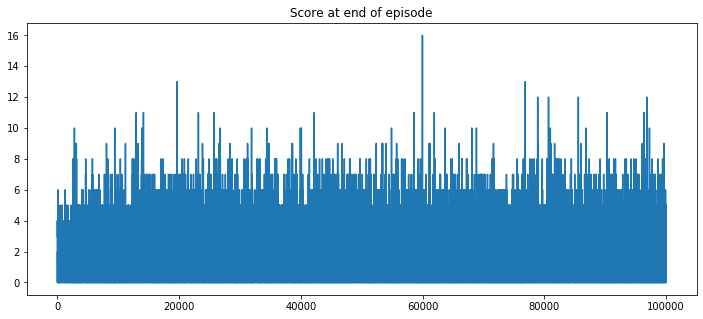

In [23]:
plt.figure(2,figsize=[12,5])
plt.title("Score at end of episode")
plt.plot(reward_total[:frames_total])
plt.show()

In [24]:
print("Average number of steps: {}". format(np.average(steps_total[:frames_total])))

Average number of steps: 213.32622


In [25]:
print("Average number of steps=reward: {}". format(np.average(steps_total)))
print("Average reward in last 100 episodes: {}". format(np.average(reward_total[frames_total-100:frames_total])))



Average number of steps=reward: 213.32622
Average reward in last 100 episodes: nan


/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

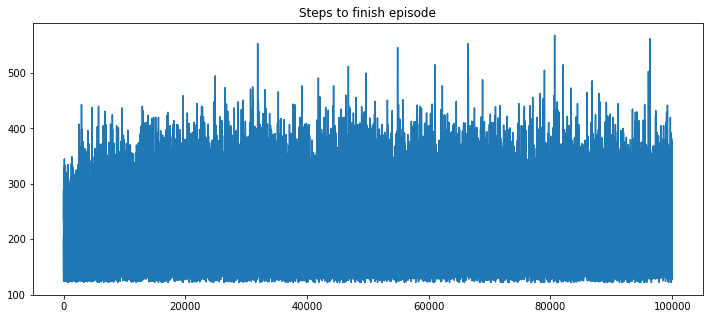

In [26]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total[:frames_total])
plt.show()